In [11]:
%reload_ext autoreload

%autoreload 2

In [2]:
from minisom import MiniSom
from sklearn.preprocessing import LabelEncoder
import sys
import sklearn.neighbors._base
sys.modules['sklearn.neighbors.base'] = sklearn.neighbors._base
import missingpy
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
from GEMA import map
from sklearn.model_selection import train_test_split
from sklearn.neural_network import MLPClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
from src import workflow as wf
import seaborn as sns
from keras.models import Sequential
from keras.layers import Dense
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification
from matplotlib.patches import Patch
from matplotlib.colors import LinearSegmentedColormap

c:\Users\Ceiec09\Documents\CEIEC_Diego\SOM\GithubSOM\SOM_desbalanceado\GEMA\map.py:68: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  self.neighbourhood = initial_neighbourhood if initial_neighbourhood is not 0 \
c:\Users\Ceiec09\Documents\CEIEC_Diego\SOM\GithubSOM\SOM_desbalanceado\GEMA\map.py:297: SyntaxWarning: "is not" with a literal. Did you mean "!="?
  if method is not 'none':


El error que se produce en la representación de GEMA es cosa de la librería pero no impide seguir ejecutando las cosas. TAmbién es posible ver como se ha representado osea que no influye en nada

## Importar dataset

In [3]:
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/oil-spill.csv'
missing_values = [' ', 'NaN', 'na', 'Na', '-', '--', 'n/a', '?']
columns = ['class']
data = pd.read_csv(url, na_values = missing_values, header=None)

In [ ]:
data

In [4]:
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 49)
datos_mode[49].value_counts()

Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  50


0.0    896
1.0     41
Name: 49, dtype: int64

## Estandarización de los datos 

In [5]:
datos_mode=datos_mode.drop(columns = [49])
data_std = wf.min_max_normalization(datos_mode)
target = data[49].values
label_names={0:'Not_spiled', 1:'Spiled'}
data_som=data_std.to_numpy()

In [ ]:
print(data_som.shape[1])

In [ ]:
data_std

## Entrenamiento de SOM

In [5]:
n_neurons = 16
m_neurons = 16

som = MiniSom(n_neurons, m_neurons, data_som.shape[1], learning_rate=0.24760602354016653, random_seed=42)
som.train(data_som, num_iteration=10000, verbose=True)  # random training
print("Topological error:",som.topographic_error(data_som))


 [ 10000 / 10000 ] 100% - 0:00:00 left 
 quantization error: 0.37110744521361994
Topological error: 0.15048025613660618


In [ ]:
plt.figure(figsize=(n_neurons, m_neurons))

plt.pcolor(som.distance_map().T, cmap='Greys')  # plotting the distance map as background
plt.colorbar()

plt.show()

## Entrenamiento GEMA

In [15]:
main_map = GEMA.Map(data_som, 
                    9, 
                    7500, 
                    initial_lr=0.20, 
                    initial_neighbourhood = 0,
                    distance = 'euclidean',
                    use_decay= False,
                    presentation= 'random',
                    weights = 'PCA')

main_classification = GEMA.Classification(main_map, data_som)
print(main_classification.quantization_error)
print(main_classification.topological_error)

TRAINING...


  0%|          | 0/7500 [00:00<?, ?it/s]

FINISHED.


  0%|          | 0/937 [00:00<?, ?it/s]

0.4979882710779082
0.08537886872998933


In [ ]:
#GEMA.Visualization.codebook_vectors(main_map, np.array(["Not Spiled", "Spiled"]))

## SMOTE

In [14]:
## Smote + Tomed_links
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 49)
data_std = wf.min_max_normalization(datos_mode)

Smote_tomed=wf.smote_tomed_link(data_std,49)
print(Smote_tomed[49].value_counts())
# Smote_tomed= Smote_tomed.reset_index(drop=True, inplace=True)
# data_std= data_std.reset_index(drop=True, inplace=True)
# diferentes=Smote_tomed[(Smote_tomed == data_std).all(axis=1) == False]
# print(diferentes)
data_balanced_dropped_smote_tomed = Smote_tomed.drop(columns = [49])
data_balanced_dropped_smote_tomed=data_balanced_dropped_smote_tomed.to_numpy()

## smote_edited_nearest_neighbor
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 49)
data_std = wf.min_max_normalization(datos_mode)

Smote_edited=wf.smote_edited_nearest_neighbor(data_std,49)
print(Smote_edited[49].value_counts())
data_balanced_dropped_smote_edited = Smote_edited.drop(columns = [49])
data_balanced_dropped_smote_edited=data_balanced_dropped_smote_edited.to_numpy()

## smote con CNN (condensed nearest neighbors)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 49)
data_std = wf.min_max_normalization(datos_mode)

Smote_cnn=wf.smote_cnn(data_std,49)
print(Smote_cnn[49].value_counts())
data_smote_cnn = Smote_cnn.drop(columns = [49])
data_smote_cnn=data_smote_cnn.to_numpy()

## smote con NCR (Neighboorhood cleaning rule)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 49)
data_std = wf.min_max_normalization(datos_mode)

Smote_ncr=wf.smote_ncr(data_std,49)
print(Smote_ncr[49].value_counts())
data_smote_ncr = Smote_ncr.drop(columns = [49])
data_smote_ncr=data_smote_ncr.to_numpy()

## smote con OSD (One sided selection)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 49)
data_std = wf.min_max_normalization(datos_mode)

Smote_oss=wf.smote_osd(data_std,49)
print(Smote_oss[49].value_counts())
data_smote_oss = Smote_oss.drop(columns = [49])
data_smote_oss=data_smote_oss.to_numpy()

Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  50
1.0    896
0.0    896
Name: 49, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  50
0.0    896
1.0    895
Name: 49, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  50
0.0    896
1.0    891
Name: 49, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  50
1.0    896
0.0    896
Name: 49, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  50
0.0    902
1.0    891
Name: 49, dtype: int64


## Clasificación con GEMA y SMOTE

In [ ]:
main_classification_smoted_tomed = GEMA.Classification(main_map, data_balanced_dropped_smote_tomed)
print("Smote+tommed quantification:",main_classification_smoted_tomed.quantization_error)
print("Smote+tommed topological:",main_classification_smoted_tomed.topological_error)

main_classification_smoted_edited= GEMA.Classification(main_map, data_balanced_dropped_smote_edited)
print("Smote+edited quantification:",main_classification_smoted_edited.quantization_error)
print("Smote+edited topological:",main_classification_smoted_edited.topological_error)

main_classification_smoted_cnn= GEMA.Classification(main_map, data_smote_cnn)
print("Smote+cnn quantification:",main_classification_smoted_cnn.quantization_error)
print("Smote+cnn topological:",main_classification_smoted_cnn.topological_error)

main_classification_smoted_ncr= GEMA.Classification(main_map, data_smote_ncr)
print("Smote+ncr quantification:",main_classification_smoted_ncr.quantization_error)
print("Smote+ncr topological:",main_classification_smoted_ncr.topological_error)

main_classification_smoted_oss= GEMA.Classification(main_map, data_smote_oss)
print("Smote+oss quantification:",main_classification_smoted_oss.quantization_error)
print("Smote+oss topological:",main_classification_smoted_oss.topological_error)

## Clasificacion con Minisom y SMOTE

In [ ]:
print("Smote+tommed")
print(som.quantization_error(data_balanced_dropped_smote_tomed), som.topographic_error(data_balanced_dropped_smote_tomed))
print("Smote+linked")
print(som.quantization_error(data_balanced_dropped_smote_edited), som.topographic_error(data_balanced_dropped_smote_edited))
print("Smote+cnn")
print(som.quantization_error(data_smote_cnn), som.topographic_error(data_smote_cnn))
print("Smote+ncr")
print(som.quantization_error(data_smote_ncr), som.topographic_error(data_smote_ncr))
print("Smote+oss")
print(som.quantization_error(data_smote_oss), som.topographic_error(data_smote_oss))

## ADASYN

In [16]:
## ADASYN + Tomed_links
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 49)
data_std = wf.min_max_normalization(datos_mode)

adasyn_tomek=wf.adasyn_tomek(data_std,49)
print(adasyn_tomek[49].value_counts())
data_adasyn_tomek = adasyn_tomek.drop(columns = [49])
data_adasyn_tomek=data_adasyn_tomek.to_numpy()

## ADASYN + ENN
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 49)
data_std = wf.min_max_normalization(datos_mode)

adasyn_edited=wf.adasyn_enn(data_std,49)
print(adasyn_edited[49].value_counts())
data_adasyn_edited = adasyn_edited.drop(columns = [49])
data_adasyn_edited=data_adasyn_edited.to_numpy()

## ADASYN con CNN (condensed nearest neighbors)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 49)
data_std = wf.min_max_normalization(datos_mode)

adasyn_cnn=wf.adasyn_cnn(data_std,49)
print(adasyn_cnn[49].value_counts())
data_adasyn_cnn = adasyn_cnn.drop(columns = [49])
data_adasyn_cnn=data_adasyn_cnn.to_numpy()

## ADASYN con NCR (Neighboorhood cleaning rule)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 49)
data_std = wf.min_max_normalization(datos_mode)

adasyn_ncr=wf.adasyn_ncr(data_std,49)
print(adasyn_ncr[49].value_counts())
data_adasyn_ncr = adasyn_ncr.drop(columns = [49])
data_adasyn_ncr=data_adasyn_ncr.to_numpy()

## ADASYN con OSD (One sided selection)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 49)
data_std = wf.min_max_normalization(datos_mode)

adasyn_oss=wf.adasyn_oss(data_std,49)
print(adasyn_oss[49].value_counts())
data_adasyn_oss = adasyn_oss.drop(columns = [49])
data_adasyn_oss=data_adasyn_oss.to_numpy()

Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  50
1.0    900
0.0    896
Name: 49, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  50
1.0    900
0.0    896
Name: 49, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  50
1.0    1048
0.0     977
Name: 49, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  50
1.0    860
0.0    854
Name: 49, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  50
0.0    896
1.0    867
Name: 49, dtype: int64


## Clasificación con GEMA y ADASYN

In [ ]:
main_classification_adasyn_tomek = GEMA.Classification(main_map, data_adasyn_tomek)
print("adasyn+tommed quantification:",main_classification_adasyn_tomek.quantization_error)
print("adasyn+tommed topological:",main_classification_adasyn_tomek.topological_error)

main_classification_adasyn_edited= GEMA.Classification(main_map, data_adasyn_edited)
print("adasyn+edited quantification:",main_classification_adasyn_edited.quantization_error)
print("adasyn+edited topological:",main_classification_adasyn_edited.topological_error)

main_classification_smoted_cnn= GEMA.Classification(main_map, data_smote_cnn)
print("adasyn+cnn quantification:",main_classification_smoted_cnn.quantization_error)
print("adasyn+cnn topological:",main_classification_smoted_cnn.topological_error)

main_classification_smoted_ncr= GEMA.Classification(main_map, data_smote_ncr)
print("adasyn+ncr quantification:",main_classification_smoted_ncr.quantization_error)
print("adasyn+ncr topological:",main_classification_smoted_ncr.topological_error)

main_classification_smoted_oss= GEMA.Classification(main_map, data_smote_oss)
print("adasyn+oss quantification:",main_classification_smoted_oss.quantization_error)
print("adasyn+oss topological:",main_classification_smoted_oss.topological_error)

## Clasificación con Minisom y ADASYN

In [ ]:
print("adasyn+tommed")
print(som.quantization_error(data_adasyn_tomek), som.topographic_error(data_adasyn_tomek))
print("adasyn+linked")
print(som.quantization_error(data_adasyn_edited), som.topographic_error(data_adasyn_edited))
print("adasyn+cnn")
print(som.quantization_error(data_adasyn_cnn), som.topographic_error(data_adasyn_cnn))
print("adasyn+ncr")
print(som.quantization_error(data_adasyn_ncr), som.topographic_error(data_adasyn_ncr))
print("adasyn+oss")
print(som.quantization_error(data_adasyn_oss), som.topographic_error(data_adasyn_oss))

## Borderline SMOTE

In [ ]:
## BSMOTE + Tomed_links
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 49)
data_std = wf.min_max_normalization(datos_mode)

bsmote_tomek=wf.BSMOTE_tomek(data_std,49)
print(bsmote_tomek[49].value_counts())
data_bsmote_tomek = bsmote_tomek.drop(columns = [49])
data_bsmote_tomek=data_bsmote_tomek.to_numpy()

## BSMOTE + ENN
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 49)
data_std = wf.min_max_normalization(datos_mode)

bsmote_edited=wf.BSMOTE_enn(data_std,49)
print(bsmote_edited[49].value_counts())
data_bsmote_edited = bsmote_edited.drop(columns = [49])
data_bsmote_edited=data_bsmote_edited.to_numpy()

## BSMOTE con CNN (condensed nearest neighbors)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 49)
data_std = wf.min_max_normalization(datos_mode)

bsmote_cnn=wf.BSMOTE_cnn(data_std,49)
print(bsmote_cnn[49].value_counts())
data_bsmote_cnn = bsmote_cnn.drop(columns = [49])
data_bsmote_cnn=data_bsmote_cnn.to_numpy()

## BSMOTE con NCR (Neighboorhood cleaning rule)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 49)
data_std = wf.min_max_normalization(datos_mode)

bsmote_ncr=wf.BSMOTE_ncr(data_std,49)
print(bsmote_ncr[49].value_counts())
data_bsmote_ncr = bsmote_ncr.drop(columns = [49])
data_bsmote_ncr=data_bsmote_ncr.to_numpy()

## BSMOTE con OSD (One sided selection)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 49)
data_std = wf.min_max_normalization(datos_mode)

bsmote_oss=wf.BSMOTE_oss(data_std,49)
print(bsmote_oss[49].value_counts())
data_bsmote_oss = bsmote_oss.drop(columns = [49])
data_bsmote_oss=data_bsmote_oss.to_numpy()

## Clasificación con GEMA y Borderline SMOTE

In [ ]:
main_classification_bsmote_tomek = GEMA.Classification(main_map, data_bsmote_tomek)
print("bsmote+tommed quantification:",main_classification_bsmote_tomek.quantization_error)
print("bsmote+tommed topological:",main_classification_bsmote_tomek.topological_error)

main_classification_bsmote_edited= GEMA.Classification(main_map, data_bsmote_edited)
print("bsmote+edited quantification:",main_classification_bsmote_edited.quantization_error)
print("bsmote+edited topological:",main_classification_bsmote_edited.topological_error)

main_classification_bsmote_cnn= GEMA.Classification(main_map, data_bsmote_cnn)
print("bsmote+cnn quantification:",main_classification_bsmote_cnn.quantization_error)
print("bsmote+cnn topological:",main_classification_bsmote_cnn.topological_error)

main_classification_bsmote_ncr= GEMA.Classification(main_map, data_bsmote_ncr)
print("bsmote+ncr quantification:",main_classification_bsmote_ncr.quantization_error)
print("bsmote+ncr topological:",main_classification_bsmote_ncr.topological_error)

main_classification_bsmote_oss= GEMA.Classification(main_map, data_bsmote_oss)
print("bsmote+oss quantification:",main_classification_bsmote_oss.quantization_error)
print("bsmote+oss topological:",main_classification_bsmote_oss.topological_error)

## Clasificación con Minisom y Borderline SMOTE

In [ ]:
print("bsmote+tommed")
print(som.quantization_error(data_bsmote_tomek), som.topographic_error(data_bsmote_tomek))
print("bsmote+linked")
print(som.quantization_error(data_bsmote_edited), som.topographic_error(data_bsmote_edited))
print("bsmote+cnn")
print(som.quantization_error(data_bsmote_cnn), som.topographic_error(data_bsmote_cnn))
print("bsmote+ncr")
print(som.quantization_error(data_bsmote_ncr), som.topographic_error(data_bsmote_ncr))
print("bsmote+oss")
print(som.quantization_error(data_bsmote_oss), som.topographic_error(data_bsmote_oss))

## SVM SMOTE

In [12]:
## SVMSMOTE + Tomed_links
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 49)
data_std = wf.min_max_normalization(datos_mode)

svmsmote_tomek=wf.SVMSMOTE_tomek(data_std,49)
print(svmsmote_tomek[49].value_counts())
data_svmsmote_tomek = svmsmote_tomek.drop(columns = [49])
data_svmsmote_tomek=data_svmsmote_tomek.to_numpy()

## SVMSMOTE + ENN
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 49)
data_std = wf.min_max_normalization(datos_mode)

svmsmote_edited=wf.SVMSMOTE_enn(data_std,49)
print(svmsmote_edited[49].value_counts())
data_svmsmote_edited = svmsmote_edited.drop(columns = [49])
data_svmsmote_edited=data_svmsmote_edited.to_numpy()

## SVMSMOTE con CNN (condensed nearest neighbors)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 49)
data_std = wf.min_max_normalization(datos_mode)

svmsmote_cnn=wf.SVMSMOTE_cnn(data_std,49)
print(svmsmote_cnn[49].value_counts())
data_svmsmote_cnn = svmsmote_cnn.drop(columns = [49])
data_svmsmote_cnn=data_svmsmote_cnn.to_numpy()

## SVMSMOTE con NCR (Neighboorhood cleaning rule)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 49)
data_std = wf.min_max_normalization(datos_mode)

svmsmote_ncr=wf.SVMSMOTE_ncr(data_std,49)
print(svmsmote_ncr[49].value_counts())
data_svmsmote_ncr = svmsmote_ncr.drop(columns = [49])
data_svmsmote_ncr=data_svmsmote_ncr.to_numpy()

## SVMSMOTE con OSD (One sided selection)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 49)
data_std = wf.min_max_normalization(datos_mode)

svmsmote_oss=wf.SVMSMOTE_oss(data_std,49)
print(svmsmote_oss[49].value_counts())
data_svmsmote_oss = svmsmote_oss.drop(columns = [49])
data_svmsmote_oss=data_svmsmote_oss.to_numpy()

Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  50
0.0    896
1.0    893
Name: 49, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  50
0.0    896
1.0    892
Name: 49, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  50
0.0    916
1.0    891
Name: 49, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  50
0.0    896
1.0    890
Name: 49, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  50
0.0    916
1.0    890
Name: 49, dtype: int64


## Clasificación con GEMA y SVM SMOTE

In [ ]:
main_classification_svmsmote_tomek = GEMA.Classification(main_map, data_svmsmote_tomek)
print("svmsmote+tommed quantification:",main_classification_svmsmote_tomek.quantization_error)
print("svmsmote+tommed topological:",main_classification_svmsmote_tomek.topological_error)

main_classification_svmsmote_edited= GEMA.Classification(main_map, data_svmsmote_edited)
print("svmsmote+edited quantification:",main_classification_svmsmote_edited.quantization_error)
print("svmsmote+edited topological:",main_classification_svmsmote_edited.topological_error)

main_classification_svmsmote_cnn= GEMA.Classification(main_map, data_svmsmote_cnn)
print("svmsmote+cnn quantification:",main_classification_svmsmote_cnn.quantization_error)
print("svmsmote+cnn topological:",main_classification_svmsmote_cnn.topological_error)

main_classification_svmsmote_ncr= GEMA.Classification(main_map, data_svmsmote_ncr)
print("svmsmote+ncr quantification:",main_classification_svmsmote_ncr.quantization_error)
print("svmsmote+ncr topological:",main_classification_svmsmote_ncr.topological_error)

main_classification_svmsmote_oss= GEMA.Classification(main_map, data_svmsmote_oss)
print("svmsmote+oss quantification:",main_classification_svmsmote_oss.quantization_error)
print("svmsmote+oss topological:",main_classification_svmsmote_oss.topological_error)

## Clasificación con Minisom y SVM SMOTE

In [ ]:
print("svmsmote+tommed")
print(som.quantization_error(data_svmsmote_tomek), som.topographic_error(data_svmsmote_tomek))
print("svmsmote+linked")
print(som.quantization_error(data_svmsmote_edited), som.topographic_error(data_svmsmote_edited))
print("svmsmote+cnn")
print(som.quantization_error(data_svmsmote_cnn), som.topographic_error(data_svmsmote_cnn))
print("svmsmote+ncr")
print(som.quantization_error(data_svmsmote_ncr), som.topographic_error(data_svmsmote_ncr))
print("svmsmote+oss")
print(som.quantization_error(data_svmsmote_oss), som.topographic_error(data_svmsmote_oss))

## Kmeans SMOTE

In [20]:
## KMSSMOTE + Tomed_links
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 49)
data_std = wf.min_max_normalization(datos_mode)

kmssmote_tomek=wf.KMSSMOTE_tomek(data_std,49)
print(kmssmote_tomek[49].value_counts())
data_kmssmote_tomek = kmssmote_tomek.drop(columns = [49])
data_kmssmote_tomek=data_kmssmote_tomek.to_numpy()

## KMSSMOTE + ENN
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 49)
data_std = wf.min_max_normalization(datos_mode)

kmssmote_edited=wf.KMSSMOTE_enn(data_std,49)
print(kmssmote_edited[49].value_counts())
data_kmssmote_edited = kmssmote_edited.drop(columns = [49])
data_kmssmote_edited=data_kmssmote_edited.to_numpy()

## KMSSMOTE con CNN (condensed nearest neighbors)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 49)
data_std = wf.min_max_normalization(datos_mode)

kmssmote_cnn=wf.KMSSMOTE_cnn(data_std,49)
print(kmssmote_cnn[49].value_counts())
data_kmssmote_cnn = kmssmote_cnn.drop(columns = [49])
data_kmssmote_cnn=data_kmssmote_cnn.to_numpy()

## KMSSMOTE con NCR (Neighboorhood cleaning rule)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 49)
data_std = wf.min_max_normalization(datos_mode)

kmssmote_ncr=wf.KMSSMOTE_ncr(data_std,49)
print(kmssmote_ncr[49].value_counts())
data_kmssmote_ncr = kmssmote_ncr.drop(columns = [49])
data_kmssmote_ncr=data_kmssmote_ncr.to_numpy()

## KMSSMOTE con OSD (One sided selection)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 49)
data_std = wf.min_max_normalization(datos_mode)

kmssmote_oss=wf.KMSSMOTE_oss(data_std,49)
print(kmssmote_oss[49].value_counts())
data_kmssmote_oss = kmssmote_oss.drop(columns = [49])
data_kmssmote_oss=data_kmssmote_oss.to_numpy()

Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  50
1.0    896
0.0    896
Name: 49, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  50
0.0    896
1.0    896
Name: 49, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  50
1.0    920
0.0    896
Name: 49, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  50
1.0    919
0.0    894
Name: 49, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  50
1.0    919
0.0    895
Name: 49, dtype: int64


## Clasificación con GEMA y Kmeans SMOTE

In [ ]:
main_classification_kmssmote_tomek = GEMA.Classification(main_map, data_kmssmote_tomek)
print("svmsmote+tommed quantification:",main_classification_kmssmote_tomek.quantization_error)
print("svmsmote+tommed topological:",main_classification_kmssmote_tomek.topological_error)

main_classification_kmssmote_edited= GEMA.Classification(main_map, data_kmssmote_edited)
print("svmsmote+edited quantification:",main_classification_kmssmote_edited.quantization_error)
print("svmsmote+edited topological:",main_classification_kmssmote_edited.topological_error)

main_classification_kmssmote_cnn= GEMA.Classification(main_map, data_kmssmote_cnn)
print("svmsmote+cnn quantification:",main_classification_kmssmote_cnn.quantization_error)
print("svmsmote+cnn topological:",main_classification_kmssmote_cnn.topological_error)

main_classification_kmssmote_ncr= GEMA.Classification(main_map, data_kmssmote_ncr)
print("svmsmote+ncr quantification:",main_classification_kmssmote_ncr.quantization_error)
print("svmsmote+ncr topological:",main_classification_kmssmote_ncr.topological_error)

main_classification_kmssmote_oss= GEMA.Classification(main_map, data_kmssmote_oss)
print("svmsmote+oss quantification:",main_classification_kmssmote_oss.quantization_error)
print("svmsmote+oss topological:",main_classification_kmssmote_oss.topological_error)

## Clasificación con Minisom y Kmeans SMOTE

In [ ]:
print("kmssmote+tommed")
print(som.quantization_error(data_kmssmote_tomek), som.topographic_error(data_kmssmote_tomek))
print("kmssmote+linked")
print(som.quantization_error(data_kmssmote_edited), som.topographic_error(data_kmssmote_edited))
print("kmssmote+cnn")
print(som.quantization_error(data_kmssmote_cnn), som.topographic_error(data_kmssmote_cnn))
print("kmssmote+ncr")
print(som.quantization_error(data_kmssmote_ncr), som.topographic_error(data_kmssmote_ncr))
print("kmssmote+oss")
print(som.quantization_error(data_kmssmote_oss), som.topographic_error(data_kmssmote_oss))

## Importar dataset Cancer de mama

In [2]:
## Importar dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/haberman.csv'
missing_values = [' ', 'NaN', 'na', 'Na', '-', '--', 'n/a', '?']
columns = ['class']
data = pd.read_csv(url, na_values = missing_values, header=None)
data[3] = data[3].replace({1: 0, 2: 1})

In [ ]:
data

In [3]:
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 3)
datos_mode[3].value_counts()

Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  4


0    225
1     81
Name: 3, dtype: int64

In [4]:
datos_mode=datos_mode.drop(columns = [3])
data_std = wf.min_max_normalization(datos_mode)
target = data[3].values
label_names={0:'plus 5', 1:'minus 5'}
data_som=data_std.to_numpy()

In [ ]:
X = wf.min_max_normalization(data)
X = X.drop(X.columns[3], axis=1)
y = data.iloc[: , 3]

# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

# Dividir el conjunto de entrenamiento en conjunto de entrenamiento y conjunto de validación
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

# Escalar las características para mejorar el rendimiento del modelo
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_validation = scaler.transform(X_validation)
X_test = scaler.transform(X_test)

# Crear un modelo secuencial en Keras
model = Sequential()
model.add(Dense(units=64, activation='relu', input_dim=20))  # Capa de entrada con 20 características
model.add(Dense(units=32, activation='relu'))  # Capa oculta con 32 neuronas y función de activación ReLU
model.add(Dense(units=1, activation='sigmoid'))  # Capa de salida con una neurona y función de activación sigmoide

# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_validation, y_validation))

## Entrenamiento GEMA cancer

In [5]:
main_map = GEMA.Map(data_som, 
                    9, 
                    5000, 
                    initial_lr=0.3, 
                    initial_neighbourhood = 0,
                    distance = 'euclidean',
                    use_decay= False,
                    presentation= 'random',
                    weights = 'sample')

main_classification = GEMA.Classification(main_map, data_som)
print("quantification error:",main_classification.quantization_error)
print("Topological_error:",main_classification.topological_error)

TRAINING...


  0%|          | 0/5000 [00:00<?, ?it/s]

FINISHED.


  0%|          | 0/306 [00:00<?, ?it/s]

quantification error: 0.0852732026143791
Topological_error: 0.09803921568627451


(8, 4) 0
(8, 5) 0
(8, 2) 0
(8, 7) 0
(8, 2) 0
(8, 8) 0
(8, 6) 0
(8, 7) 1
(8, 1) 1
(3, 6) 0
(8, 6) 0
(8, 6) 0
(8, 0) 0
(8, 6) 0
(8, 4) 0
(8, 4) 0
(8, 6) 0
(8, 0) 0
(8, 6) 0
(8, 4) 0
(7, 8) 0
(8, 8) 0
(8, 7) 0
(8, 4) 0
(8, 0) 1
(8, 8) 0
(8, 6) 0
(8, 6) 0
(8, 5) 0
(8, 3) 0
(8, 1) 0
(8, 1) 0
(8, 6) 0
(8, 0) 0
(7, 1) 1
(8, 4) 0
(8, 1) 0
(7, 8) 0
(8, 8) 0
(8, 4) 0
(7, 8) 0
(7, 8) 0
(8, 2) 0
(3, 6) 1
(8, 3) 1
(7, 1) 1
(7, 8) 0
(8, 8) 0
(7, 8) 0
(8, 3) 0
(8, 0) 0
(8, 2) 0
(8, 2) 0
(5, 0) 1
(7, 7) 1
(7, 8) 0
(7, 7) 0
(7, 8) 0
(7, 6) 0
(3, 5) 0
(8, 2) 0
(7, 4) 0
(3, 5) 1
(7, 7) 1
(7, 3) 1
(7, 3) 1
(4, 4) 0
(7, 3) 0
(7, 3) 0
(7, 7) 0
(7, 4) 0
(7, 2) 0
(7, 1) 0
(7, 3) 1
(7, 8) 1
(3, 4) 1
(7, 6) 0
(7, 4) 0
(7, 6) 0
(7, 0) 0
(7, 2) 1
(7, 1) 1
(6, 0) 1
(6, 7) 0
(6, 0) 0
(3, 7) 0
(7, 3) 0
(5, 0) 0
(6, 0) 0
(6, 8) 1
(5, 0) 1
(7, 5) 1
(3, 4) 1
(7, 5) 0
(6, 8) 0
(6, 4) 0
(3, 4) 1
(6, 5) 1
(6, 2) 1
(6, 6) 0
(6, 4) 0
(6, 2) 0
(5, 1) 0
(6, 8) 0
(6, 7) 0
(5, 0) 0
(7, 0) 0
(3, 7) 1
(3, 7) 1
(6, 0) 1
(4, 6) 0
(

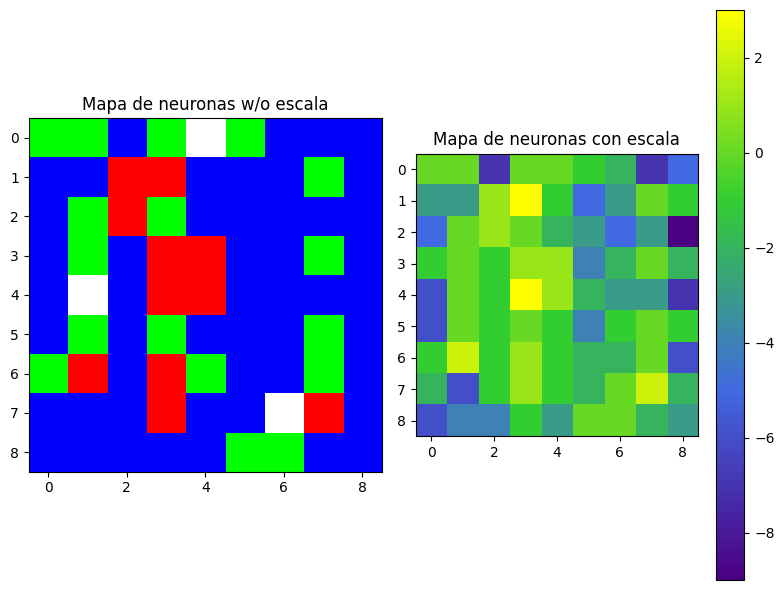

Number of blue neurons: 50
Number of red neurons: 11
Number of white neurons: 3
Number of green neurons: 17


In [17]:
#import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import LinearSegmentedColormap

porcentaje = 0.65

# Inicializa un mapa de colores del tamaño del SOM con todos los valores en blanco
color_map = np.ones((9, 9, 3))

# Inicializa un mapa de clases del tamaño del SOM con todos los valores en -1
class_map = -1 * np.ones((9, 9))

# Contadores para cada neurona
counts = np.zeros((9, 9, 2), dtype=int)

# Itera sobre cada dato y su clase correspondiente
for datum, class_ in zip(data_som, target):
    # Encuentra la neurona ganadora para este dato
    winner = main_map.calculate_bmu(datum)[1]
    
    # Actualiza el contador de la clase para la neurona ganadora
    counts[int(winner[0]), int(winner[1]), int(class_)] += 1
    
    # Actualiza el mapa de clases con la clase reconocida
    class_map[winner] = class_

# Itera sobre cada neurona para determinar el color final
for i in range(9):
    for j in range(9):
        # Calcula el porcentaje de cada clase para la neurona actual
        percent_class_0 = counts[i, j, 0] / (counts[i, j, 0] + counts[i, j, 1]) if counts[i, j, 0] + counts[i, j, 1] > 0 else 0
        percent_class_1 = counts[i, j, 1] / (counts[i, j, 0] + counts[i, j, 1]) if counts[i, j, 0] + counts[i, j, 1] > 0 else 0
        
        # Asigna el color según las condiciones especificadas
        if percent_class_0 >= porcentaje:
            color_map[i, j] = [0, 0, 1]  # Azul
        elif percent_class_1 >= porcentaje:
            color_map[i, j] = [1, 0, 0]  # Rojo
        elif counts[i, j, 0] + counts[i, j, 1] == 0:
            color_map[i, j] = [1, 1, 1]  # Blanco si no ha reconocido ningún patrón
        else:
            color_map[i, j] = [0, 1, 0]  # Verde si no alcanza el 80% de ninguna clase


# Count the number of neurons of each color
num_blue = np.sum(np.all(color_map == [0, 0, 1], axis=-1))
num_red = np.sum(np.all(color_map == [1, 0, 0], axis=-1))
num_white = np.sum(np.all(color_map == [1, 1, 1], axis=-1))
num_green = np.sum(np.all(color_map == [0, 1, 0], axis=-1))

# Crea una figura con diferentes tamaños para los subplots
fig = plt.figure(figsize=(8, 6))

# Crea una leyenda para el primer gráfico
legend_elements = [Patch(facecolor='blue', edgecolor='b', label='Clase 0'),
                   Patch(facecolor='red', edgecolor='r', label='Clase 1'),
                   Patch(facecolor='green', edgecolor='g', label='Ambas clases')]
ax1 = fig.add_subplot(121)  # 121 significa "1 fila, 2 columnas, primer gráfico"
# ax1.legend(handles=legend_elements, loc='upper right')
ax1.imshow(np.rot90(color_map))
ax1.set_title('Mapa de neuronas w/o escala')

# Inicializa un mapa de neuronas con ceros
neuron_map = np.zeros((9, 9))
ganadores = np.zeros((9, 9))

# Itera sobre los datos y las clases
for datum, clss in zip(data_som, target):
    # Obtiene la neurona ganadora para el dato actual
    winner = main_map.calculate_bmu(datum)[1]
    ganadores[winner] = 1
    print(winner, clss)
    # Si la clase es 0, resta 1, si la clase es 1, suma 1
    neuron_map[winner[0], winner[1]] += 1 if clss == 1 else -1

# Normaliza el mapa de neuronas para que los valores estén entre -1 y 1
# neuron_map = neuron_map / np.max(np.abs(neuron_map))

# Define los colores de la escala como azul, verde y amarillo
cmap_colors = ["indigo", "royalblue", "limegreen", "yellow"]

# Crea el mapa de colores
cmap = LinearSegmentedColormap.from_list("mycmap", cmap_colors)

# Dibuja el mapa de calor
ax2 = fig.add_subplot(122)  # 122 significa "1 fila, 2 columnas, segundo gráfico"
im = ax2.imshow(np.rot90(neuron_map), cmap=cmap, interpolation='nearest')
ax2.set_title('Mapa de neuronas con escala')

# Muestra la barra de colores
fig.colorbar(im, ax=ax2)

# Ajusta el layout
plt.tight_layout()

# Muestra el gráfico
plt.show()

# Print the number of neurons of each color
print(f"Number of blue neurons: {num_blue}")
print(f"Number of red neurons: {num_red}")
print(f"Number of white neurons: {num_white}")
print(f"Number of green neurons: {num_green}")

## Entrenamiento Minisom cancer

In [ ]:
n_neurons = 7
m_neurons = 7

som = MiniSom(n_neurons, m_neurons, data_som.shape[1], learning_rate=0.23097207947323742, random_seed=42)
som.train(data_som, num_iteration=5600, verbose=True)  # random training
print("Topological error:",som.topographic_error(data_som))

In [ ]:
u_matrix = visualization.Visualization.umatrix(main_classification)

In [ ]:
GEMA.Visualization.heat_map(main_classification)

In [ ]:
import plotly.express as px
import pandas as pd
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import numpy as np

# Calcular la U-Matrix
u_matrix = som.distance_map()

# Visualizar la U-Matrix
plt.imshow(u_matrix, cmap='gray', origin='lower')
plt.colorbar()
plt.show()

# Asigna colores basados en la cuarta columna (índice 3)
data['color'] = ['blue' if x == 0 else 'orange' for x in data.iloc[:,3]]

fig = px.scatter_3d(data, x=data.columns[0], y=data.columns[1], z=data.columns[2], color='color')

fig.show()

## SMOTE Cancer

In [13]:
## Smote + Tomed_links
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 3)
data_std = wf.min_max_normalization(datos_mode)

Smote_tomed=wf.smote_tomed_link(data_std,3)
print(Smote_tomed[3].value_counts())
# Smote_tomed= Smote_tomed.reset_index(drop=True, inplace=True)
# data_std= data_std.reset_index(drop=True, inplace=True)
# diferentes=Smote_tomed[(Smote_tomed == data_std).all(axis=1) == False]
# print(diferentes)
data_balanced_dropped_smote_tomed = Smote_tomed.drop(columns = [3])
data_balanced_dropped_smote_tomed=data_balanced_dropped_smote_tomed.to_numpy()

## smote_edited_nearest_neighbor
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 3)
data_std = wf.min_max_normalization(datos_mode)

Smote_edited=wf.smote_enn2(data_std,3)
print(Smote_edited[3].value_counts())
data_balanced_dropped_smote_edited = Smote_edited.drop(columns = [3])
data_balanced_dropped_smote_edited=data_balanced_dropped_smote_edited.to_numpy()

## smote con CNN (condensed nearest neighbors)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 3)
data_std = wf.min_max_normalization(datos_mode)

Smote_cnn=wf.smote_cnn(data_std,3)
print(Smote_cnn[3].value_counts())
data_smote_cnn = Smote_cnn.drop(columns = [3])
data_smote_cnn=data_smote_cnn.to_numpy()

## smote con NCR (Neighboorhood cleaning rule)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 3)
data_std = wf.min_max_normalization(datos_mode)

Smote_ncr=wf.smote_ncr(data_std,3)
print(Smote_ncr[3].value_counts())
data_smote_ncr = Smote_ncr.drop(columns = [3])
data_smote_ncr=data_smote_ncr.to_numpy()

## smote con OSD (One sided selection)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 3)
data_std = wf.min_max_normalization(datos_mode)

Smote_oss=wf.smote_osd(data_std,3)
print(Smote_oss[3].value_counts())
data_smote_oss = Smote_oss.drop(columns = [3])
data_smote_oss=data_smote_oss.to_numpy()

Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  4
1.0    225
0.0    211
Name: 3, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  4
0.0    225
1.0    199
Name: 3, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  4
1.0    239
0.0    220
Name: 3, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  4
0.0    225
1.0    188
Name: 3, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  4
1.0    244
0.0    218
Name: 3, dtype: int64


In [ ]:
y = Smote_tomed.iloc[: , 3]
X = Smote_tomed.drop(Smote_tomed.columns[3], axis=1)

# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

# Dividir el conjunto de entrenamiento en conjunto de entrenamiento y conjunto de validación
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

# Escalar las características para mejorar el rendimiento del modelo
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valn = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Crear un modelo secuencial en Keras
model = Sequential()
model.add(Dense(units=45, activation='relu', input_dim=3))  # Capa de entrada con 20 características
model.add(Dense(units=45, activation='relu'))  # Capa oculta con 32 neuronas y función de activación ReLU
model.add(Dense(units=1, activation='sigmoid'))  # Capa de salida con una neurona y función de activación sigmoide
pesos = model.get_weights()
# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_val, y_val))

# Calcular Accuracy en el conjunto de entrenamiento
train_accuracy = accuracy_score(y_train, model.predict(X_train) > 0.5)

# Calcular Accuracy en el conjunto de validación
validation_accuracy = accuracy_score(y_val, model.predict(X_val) > 0.5)

print(f'Training Accuracy: {train_accuracy}')
print(f'Validation Accuracy: {validation_accuracy}')

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)  # Convertir las probabilidades en etiquetas binarias (0 o 1)

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Calcular la especificidad
TN = conf_matrix[0][0]  # Verdaderos negativos
FP = conf_matrix[0][1]  # Falsos positivos
specificity = TN / (TN + FP)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall (Sensibility): {recall}')
print(f'Specificity: {specificity}')

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Crear la matriz de confusión gráfica
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
y = Smote_ncr.iloc[: , 3]
X = Smote_ncr.drop(Smote_ncr.columns[3], axis=1)

# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

# Dividir el conjunto de entrenamiento en conjunto de entrenamiento y conjunto de validación
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

# Escalar las características para mejorar el rendimiento del modelo
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valn = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Crear un modelo secuencial en Keras
model = Sequential()
model.add(Dense(units=45, activation='relu', input_dim=3))  # Capa de entrada con 20 características
model.add(Dense(units=45, activation='relu'))  # Capa oculta con 32 neuronas y función de activación ReLU
model.add(Dense(units=1, activation='sigmoid'))  # Capa de salida con una neurona y función de activación sigmoide
model.set_weights(pesos)
# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Calcular Accuracy en el conjunto de entrenamiento
train_accuracy = accuracy_score(y_train, model.predict(X_train) > 0.5)

# Calcular Accuracy en el conjunto de validación
validation_accuracy = accuracy_score(y_val, model.predict(X_val) > 0.5)

print(f'Training Accuracy: {train_accuracy}')
print(f'Validation Accuracy: {validation_accuracy}')

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)  # Convertir las probabilidades en etiquetas binarias (0 o 1)

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Calcular la especificidad
TN = conf_matrix[0][0]  # Verdaderos negativos
FP = conf_matrix[0][1]  # Falsos positivos
specificity = TN / (TN + FP)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall (Sensibility): {recall}')
print(f'Specificity: {specificity}')

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Crear la matriz de confusión gráfica
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Clasificación cancer con GEMA y SMOTE

In [ ]:
main_classification_smoted_tomed = GEMA.Classification(main_map, data_balanced_dropped_smote_tomed)
print("Smote+tommed quantification:",main_classification_smoted_tomed.quantization_error)
print("Smote+tommed topological:",main_classification_smoted_tomed.topological_error)

main_classification_smoted_edited= GEMA.Classification(main_map, data_balanced_dropped_smote_edited)
print("Smote+edited quantification:",main_classification_smoted_edited.quantization_error)
print("Smote+edited topological:",main_classification_smoted_edited.topological_error)

main_classification_smoted_cnn= GEMA.Classification(main_map, data_smote_cnn)
print("Smote+cnn quantification:",main_classification_smoted_cnn.quantization_error)
print("Smote+cnn topological:",main_classification_smoted_cnn.topological_error)

main_classification_smoted_ncr= GEMA.Classification(main_map, data_smote_ncr)
print("Smote+ncr quantification:",main_classification_smoted_ncr.quantization_error)
print("Smote+ncr topological:",main_classification_smoted_ncr.topological_error)

main_classification_smoted_oss= GEMA.Classification(main_map, data_smote_oss)
print("Smote+oss quantification:",main_classification_smoted_oss.quantization_error)
print("Smote+oss topological:",main_classification_smoted_oss.topological_error)

In [ ]:
from imblearn.over_sampling import RandomOverSampler, SMOTE, BorderlineSMOTE, SVMSMOTE, ADASYN, KMeansSMOTE
from imblearn.under_sampling import RandomUnderSampler, NearMiss, CondensedNearestNeighbour, TomekLinks, EditedNearestNeighbours, OneSidedSelection, NeighbourhoodCleaningRule
from imblearn.pipeline import Pipeline

In [ ]:
def smote_enn_clase0(dataset, target):

    print(dataset.head(5))
    print(dataset[3].value_counts())   

    # Separar las características y el target
    X = dataset.drop(target, axis=1)
    y = dataset[target]

    # Guardar los índices de las filas originales
    original_indices = X.index

    # Crear una instancia de SMOTE
    smote = SMOTE(sampling_strategy={0: int(len(y[y==0])*1.5), 1: len(y[y==1])})

    # Crear una instancia de Condensed Nearest Neighbour
    enn = EditedNearestNeighbours(sampling_strategy='all', n_neighbors= 1)
    pipeline = Pipeline([('SMOTE', smote), ('ENN', enn)])

    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Redimensionamos las clases.
    y_resampled = y_resampled.to_numpy().reshape(-1, 1)
    y_resampled = y_resampled.reshape(np.size(X_resampled, 0),1)
    
    cols_df = dataset.columns
    cols_df = cols_df.drop(target)
    
    synthetic_data = pd.DataFrame(X_resampled, columns=cols_df)
    synthetic_data[target] = y_resampled

    # Eliminar las filas del conjunto de datos sobremuestreado que corresponden a las filas originales
    synthetic_data_only = synthetic_data.drop(original_indices)
                
    return synthetic_data_only

def smote_enn_clase1(dataset, target):

    print(dataset.head(5))
    print(dataset[3].value_counts())   

    # Separar las características y el target
    X = dataset.drop(target, axis=1)
    y = dataset[target]

    # Guardar los índices de las filas originales
    original_indices = X.index

    # Crear una instancia de SMOTE
    smote = SMOTE(sampling_strategy='auto')

    # Crear una instancia de Condensed Nearest Neighbour
    enn = EditedNearestNeighbours(sampling_strategy='auto', n_neighbors= 1)
    pipeline = Pipeline([('SMOTE', smote), ('ENN', enn)])

    X_resampled, y_resampled = pipeline.fit_resample(X, y)

    # Redimensionamos las clases.
    y_resampled = y_resampled.to_numpy().reshape(-1, 1)
    y_resampled = y_resampled.reshape(np.size(X_resampled, 0),1)
    
    cols_df = dataset.columns
    cols_df = cols_df.drop(target)
    
    synthetic_data = pd.DataFrame(X_resampled, columns=cols_df)
    synthetic_data[target] = y_resampled

    # Eliminar las filas del conjunto de datos sobremuestreado que corresponden a las filas originales
    synthetic_data_only = synthetic_data.drop(original_indices)
                
    return synthetic_data_only

Smote_enn_sinteticos0=smote_enn_clase0(data_std,3)
Smote_enn_sinteticos1=smote_enn_clase1(data_std,3)
smote_enn_sinteticos = pd.concat([Smote_enn_sinteticos0, Smote_enn_sinteticos1], axis=0, ignore_index=True)
print(smote_enn_sinteticos.head(5))
print(smote_enn_sinteticos[3].value_counts())


(8, 4) 0.0
(8, 5) 0.0
(8, 2) 0.0
(8, 7) 0.0
(8, 2) 0.0
(8, 8) 0.0
(8, 6) 0.0
(3, 6) 0.0
(8, 6) 0.0
(8, 6) 0.0
(8, 0) 0.0
(8, 6) 0.0
(8, 4) 0.0
(8, 4) 0.0
(8, 6) 0.0
(8, 0) 0.0
(8, 6) 0.0
(8, 4) 0.0
(7, 8) 0.0
(8, 8) 0.0
(8, 7) 0.0
(8, 4) 0.0
(8, 8) 0.0
(8, 6) 0.0
(8, 6) 0.0
(8, 5) 0.0
(8, 3) 0.0
(8, 1) 0.0
(8, 1) 0.0
(8, 6) 0.0
(8, 0) 0.0
(8, 4) 0.0
(8, 1) 0.0
(7, 8) 0.0
(8, 8) 0.0
(8, 4) 0.0
(7, 8) 0.0
(7, 8) 0.0
(8, 2) 0.0
(7, 8) 0.0
(8, 8) 0.0
(7, 8) 0.0
(8, 3) 0.0
(8, 0) 0.0
(8, 2) 0.0
(8, 2) 0.0
(7, 8) 0.0
(7, 7) 0.0
(7, 8) 0.0
(7, 6) 0.0
(3, 5) 0.0
(8, 2) 0.0
(7, 4) 0.0
(4, 4) 0.0
(7, 3) 0.0
(7, 3) 0.0
(7, 7) 0.0
(7, 4) 0.0
(7, 2) 0.0
(7, 1) 0.0
(7, 6) 0.0
(7, 4) 0.0
(7, 6) 0.0
(7, 0) 0.0
(6, 7) 0.0
(6, 0) 0.0
(3, 7) 0.0
(7, 3) 0.0
(5, 0) 0.0
(6, 0) 0.0
(7, 5) 0.0
(6, 8) 0.0
(6, 4) 0.0
(6, 6) 0.0
(6, 4) 0.0
(6, 2) 0.0
(5, 1) 0.0
(6, 8) 0.0
(6, 7) 0.0
(5, 0) 0.0
(7, 0) 0.0
(4, 6) 0.0
(6, 5) 0.0
(6, 3) 0.0
(6, 2) 0.0
(6, 6) 0.0
(6, 5) 0.0
(6, 2) 0.0
(6, 7) 0.0
(6, 5) 0.0
(6, 4) 0.0

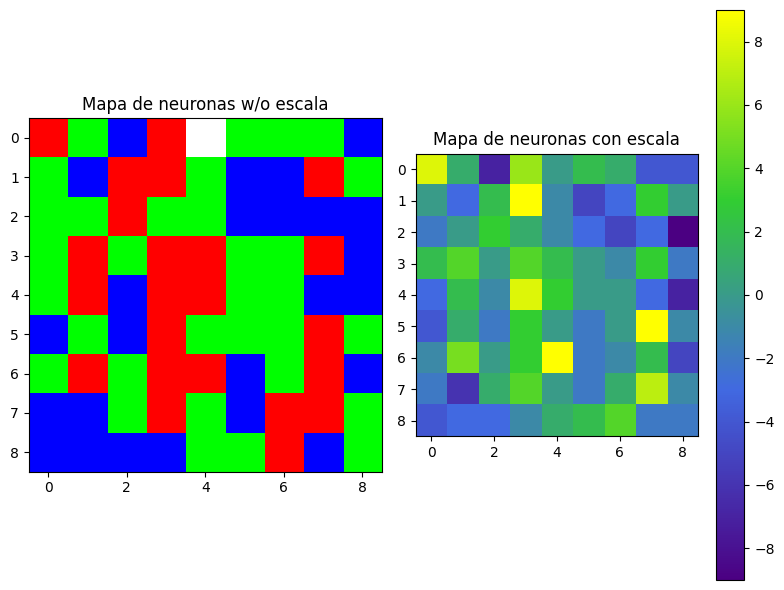

Number of blue neurons: 25
Number of red neurons: 23
Number of white neurons: 1
Number of green neurons: 32


NameError: name 'smote_enn_sinteticos' is not defined

In [52]:
y = adasyn_oss.iloc[: , 3]
X = adasyn_oss.drop(adasyn_oss.columns[3], axis=1)
y = y.to_numpy()
X = X.to_numpy()
porcentaje = 0.7

# Inicializa un mapa de colores del tamaño del SOM con todos los valores en blanco
color_map = np.ones((9, 9, 3))

# Inicializa un mapa de clases del tamaño del SOM con todos los valores en -1
class_map = -1 * np.ones((9, 9))

# Contadores para cada neurona
counts = np.zeros((9, 9, 2), dtype=int)

# Itera sobre cada dato y su clase correspondiente
for datum, class_ in zip(X, y):
    # Encuentra la neurona ganadora para este dato
    winner = main_map.calculate_bmu(datum)[1]
    
    # Actualiza el contador de la clase para la neurona ganadora
    counts[int(winner[0]), int(winner[1]), int(class_)] += 1
    
    # Actualiza el mapa de clases con la clase reconocida
    class_map[winner] = class_

# Itera sobre cada neurona para determinar el color final
for i in range(9):
    for j in range(9):
        # Calcula el porcentaje de cada clase para la neurona actual
        percent_class_0 = counts[i, j, 0] / (counts[i, j, 0] + counts[i, j, 1]) if counts[i, j, 0] + counts[i, j, 1] > 0 else 0
        percent_class_1 = counts[i, j, 1] / (counts[i, j, 0] + counts[i, j, 1]) if counts[i, j, 0] + counts[i, j, 1] > 0 else 0
        
        # Asigna el color según las condiciones especificadas
        if percent_class_0 >= porcentaje:
            color_map[i, j] = [0, 0, 1]  # Azul
        elif percent_class_1 >= porcentaje:
            color_map[i, j] = [1, 0, 0]  # Rojo
        elif counts[i, j, 0] + counts[i, j, 1] == 0:
            color_map[i, j] = [1, 1, 1]  # Blanco si no ha reconocido ningún patrón
        else:
            color_map[i, j] = [0, 1, 0]  # Verde si no alcanza el % de ninguna clase

# Crea una figura con diferentes tamaños para los subplots
fig = plt.figure(figsize=(8, 6))

# Crea una leyenda para el primer gráfico
legend_elements = [Patch(facecolor='blue', edgecolor='b', label='Clase 0'),
                   Patch(facecolor='red', edgecolor='r', label='Clase 1'),
                   Patch(facecolor='green', edgecolor='g', label='Ambas clases')]
ax1 = fig.add_subplot(121)  # 121 significa "1 fila, 2 columnas, primer gráfico"
#ax1.legend(handles=legend_elements, loc='upper right')
ax1.imshow(np.rot90(color_map))
ax1.set_title('Mapa de neuronas w/o escala')

# Inicializa un mapa de neuronas con ceros
neuron_map = np.zeros((9, 9))
ganadores = np.zeros((9, 9))

# Itera sobre los datos y las clases
for datum, clss in zip(X, y):
    # Obtiene la neurona ganadora para el dato actual
    winner = main_map.calculate_bmu(datum)[1]
    ganadores[winner] = 1
    print(winner, clss)
    # Si la clase es 0, resta 1, si la clase es 1, suma 1
    neuron_map[winner[0], winner[1]] += 1 if clss == 1 else -1

# Normaliza el mapa de neuronas para que los valores estén entre -1 y 1
# neuron_map = neuron_map / np.max(np.abs(neuron_map))

# Define los colores de la escala como azul, verde y amarillo
cmap_colors = ["indigo", "royalblue", "limegreen", "yellow"]

# Crea el mapa de colores
cmap = LinearSegmentedColormap.from_list("mycmap", cmap_colors)

# Dibuja el mapa de calor
ax2 = fig.add_subplot(122)  # 122 significa "1 fila, 2 columnas, segundo gráfico"
im = ax2.imshow(np.rot90(neuron_map), cmap=cmap, interpolation='nearest')
ax2.set_title('Mapa de neuronas con escala')

# Muestra la barra de colores
fig.colorbar(im, ax=ax2)

# Ajusta el layout
plt.tight_layout()

# Muestra el gráfico
plt.show()

num_blue = np.sum(np.all(color_map == [0, 0, 1], axis=-1))
num_red = np.sum(np.all(color_map == [1, 0, 0], axis=-1))
num_white = np.sum(np.all(color_map == [1, 1, 1], axis=-1))
num_green = np.sum(np.all(color_map == [0, 1, 0], axis=-1))
# Print the number of neurons of each color
print(f"Number of blue neurons: {num_blue}")
print(f"Number of red neurons: {num_red}")
print(f"Number of white neurons: {num_white}")
print(f"Number of green neurons: {num_green}")

data_balanced_dropped_smote_edited_sint = smote_enn_sinteticos.drop(columns = [3])
data_balanced_dropped_smote_edited_sint=data_balanced_dropped_smote_edited_sint.to_numpy()
main_classification_smoted_enn_sinteticos = GEMA.Classification(main_map, data_balanced_dropped_smote_edited_sint)
GEMA.Visualization.heat_map(main_classification_smoted_enn_sinteticos)

## Clasificación cancer con Minisom y SMOTE

In [ ]:
print("Smote+tommed")
print(som.quantization_error(data_balanced_dropped_smote_tomed), som.topographic_error(data_balanced_dropped_smote_tomed))
print("Smote+linked")
print(som.quantization_error(data_balanced_dropped_smote_edited), som.topographic_error(data_balanced_dropped_smote_edited))
print("Smote+cnn")
print(som.quantization_error(data_smote_cnn), som.topographic_error(data_smote_cnn))
print("Smote+ncr")
print(som.quantization_error(data_smote_ncr), som.topographic_error(data_smote_ncr))
print("Smote+oss")
print(som.quantization_error(data_smote_oss), som.topographic_error(data_smote_oss))

## ADASYN Cancer

In [19]:
## ADASYN + Tomed_links
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 3)
data_std = wf.min_max_normalization(datos_mode)

adasyn_tomek=wf.adasyn_tomek(data_std,3)
print(adasyn_tomek[3].value_counts())
data_adasyn_tomek = adasyn_tomek.drop(columns = [3])
data_adasyn_tomek=data_adasyn_tomek.to_numpy()

## ADASYN + ENN
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 3)
data_std = wf.min_max_normalization(datos_mode)

adasyn_edited=wf.adasyn_enn(data_std,3)
print(adasyn_edited[3].value_counts())
data_adasyn_edited = adasyn_edited.drop(columns = [3])
data_adasyn_edited=data_adasyn_edited.to_numpy()

## ADASYN con CNN (condensed nearest neighbors)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 3)
data_std = wf.min_max_normalization(datos_mode)

adasyn_cnn=wf.adasyn_cnn(data_std,3)
print(adasyn_cnn[3].value_counts())
data_adasyn_cnn = adasyn_cnn.drop(columns = [3])
data_adasyn_cnn=data_adasyn_cnn.to_numpy()

## ADASYN con NCR (Neighboorhood cleaning rule)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 3)
data_std = wf.min_max_normalization(datos_mode)

adasyn_ncr=wf.adasyn_ncr(data_std,3)
print(adasyn_ncr[3].value_counts())
data_adasyn_ncr = adasyn_ncr.drop(columns = [3])
data_adasyn_ncr=data_adasyn_ncr.to_numpy()

## ADASYN con OSD (One sided selection)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 3)
data_std = wf.min_max_normalization(datos_mode)

adasyn_oss=wf.adasyn_oss(data_std,3)
print(adasyn_oss[3].value_counts())
data_adasyn_oss = adasyn_oss.drop(columns = [3])
data_adasyn_oss=data_adasyn_oss.to_numpy()

Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  4
1.0    231
0.0    210
Name: 3, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  4
0.0    225
1.0    204
Name: 3, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  4
1.0    322
0.0    301
Name: 3, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  4
1.0    154
0.0    146
Name: 3, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  4
1.0    230
0.0    225
Name: 3, dtype: int64


In [ ]:
y = adasyn_tomek.iloc[: , 3]
X = adasyn_tomek.drop(adasyn_tomek.columns[3], axis=1)

# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

# Dividir el conjunto de entrenamiento en conjunto de entrenamiento y conjunto de validación
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

# Escalar las características para mejorar el rendimiento del modelo
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valn = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Crear un modelo secuencial en Keras
model = Sequential()
model.add(Dense(units=45, activation='relu', input_dim=3))  # Capa de entrada con 20 características
model.add(Dense(units=45, activation='relu'))  # Capa oculta con 32 neuronas y función de activación ReLU
model.add(Dense(units=1, activation='sigmoid'))  # Capa de salida con una neurona y función de activación sigmoide
pesos = model.get_weights()
# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Calcular Accuracy en el conjunto de entrenamiento
train_accuracy = accuracy_score(y_train, model.predict(X_train) > 0.5)

# Calcular Accuracy en el conjunto de validación
validation_accuracy = accuracy_score(y_val, model.predict(X_val) > 0.5)

print(f'Training Accuracy: {train_accuracy}')
print(f'Validation Accuracy: {validation_accuracy}')

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)  # Convertir las probabilidades en etiquetas binarias (0 o 1)

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Calcular la especificidad
TN = conf_matrix[0][0]  # Verdaderos negativos
FP = conf_matrix[0][1]  # Falsos positivos
specificity = TN / (TN + FP)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall (Sensibility): {recall}')
print(f'Specificity: {specificity}')

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Crear la matriz de confusión gráfica
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
y = adasyn_oss.iloc[: , 3]
X = adasyn_oss.drop(adasyn_oss.columns[3], axis=1)

# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

# Dividir el conjunto de entrenamiento en conjunto de entrenamiento y conjunto de validación
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

# Escalar las características para mejorar el rendimiento del modelo
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valn = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Crear un modelo secuencial en Keras
model = Sequential()
model.add(Dense(units=45, activation='relu', input_dim=3))  # Capa de entrada con 20 características
model.add(Dense(units=45, activation='relu'))  # Capa oculta con 32 neuronas y función de activación ReLU
model.add(Dense(units=1, activation='sigmoid'))  # Capa de salida con una neurona y función de activación sigmoide
model.set_weights(pesos)
# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Calcular Accuracy en el conjunto de entrenamiento
train_accuracy = accuracy_score(y_train, model.predict(X_train) > 0.5)

# Calcular Accuracy en el conjunto de validación
validation_accuracy = accuracy_score(y_val, model.predict(X_val) > 0.5)

print(f'Training Accuracy: {train_accuracy}')
print(f'Validation Accuracy: {validation_accuracy}')

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)  # Convertir las probabilidades en etiquetas binarias (0 o 1)

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Calcular la especificidad
TN = conf_matrix[0][0]  # Verdaderos negativos
FP = conf_matrix[0][1]  # Falsos positivos
specificity = TN / (TN + FP)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall (Sensibility): {recall}')
print(f'Specificity: {specificity}')

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Crear la matriz de confusión gráfica
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Clasificación cancer con GEMA y ADASYN

In [ ]:
main_classification_adasyn_tomek = GEMA.Classification(main_map, data_adasyn_tomek)
print("adasyn+tommed quantification:",main_classification_adasyn_tomek.quantization_error)
print("adasyn+tommed topological:",main_classification_adasyn_tomek.topological_error)

main_classification_adasyn_edited= GEMA.Classification(main_map, data_adasyn_edited)
print("adasyn+edited quantification:",main_classification_adasyn_edited.quantization_error)
print("adasyn+edited topological:",main_classification_adasyn_edited.topological_error)

main_classification_adasyn_cnn= GEMA.Classification(main_map, data_adasyn_cnn)
print("adasyn+cnn quantification:",main_classification_adasyn_cnn.quantization_error)
print("adasyn+cnn topological:",main_classification_adasyn_cnn.topological_error)

main_classification_adasyn_ncr= GEMA.Classification(main_map, data_adasyn_ncr)
print("adasyn+ncr quantification:",main_classification_adasyn_ncr.quantization_error)
print("adasyn+ncr topological:",main_classification_adasyn_ncr.topological_error)

main_classification_adasyn_oss= GEMA.Classification(main_map, data_adasyn_oss)
print("adasyn+oss quantification:",main_classification_adasyn_oss.quantization_error)
print("adasyn+oss topological:",main_classification_adasyn_oss.topological_error)

In [ ]:
def smote_enn_clase0(dataset, target):

    print(dataset.head(5))
    print(dataset[3].value_counts())   

    # Separar las características y el target
    X = dataset.drop(target, axis=1)
    y = dataset[target]

    # Guardar los índices de las filas originales
    original_indices = X.index

    # Crear una instancia de SMOTE
    smote = ADASYN(sampling_strategy={0: int(len(y[y==0])*1.6), 1: len(y[y==1])})

    # Crear una instancia de Condensed Nearest Neighbour
    enn = NeighbourhoodCleaningRule(sampling_strategy='all', n_neighbors= 1)
    pipeline = Pipeline([('SMOTE', smote), ('ENN', enn)])

    X_resampled, y_resampled = smote.fit_resample(X, y)

    # Redimensionamos las clases.
    y_resampled = y_resampled.to_numpy().reshape(-1, 1)
    y_resampled = y_resampled.reshape(np.size(X_resampled, 0),1)
    
    cols_df = dataset.columns
    cols_df = cols_df.drop(target)
    
    synthetic_data = pd.DataFrame(X_resampled, columns=cols_df)
    synthetic_data[target] = y_resampled

    # Eliminar las filas del conjunto de datos sobremuestreado que corresponden a las filas originales
    synthetic_data_only = synthetic_data.drop(original_indices)
                
    return synthetic_data_only

def smote_enn_clase1(dataset, target):

    print(dataset.head(5))
    print(dataset[3].value_counts())   

    # Separar las características y el target
    X = dataset.drop(target, axis=1)
    y = dataset[target]

    # Guardar los índices de las filas originales
    original_indices = X.index

    # Crear una instancia de SMOTE
    smote = ADASYN(sampling_strategy='auto')

    # Crear una instancia de Condensed Nearest Neighbour
    enn = NeighbourhoodCleaningRule(sampling_strategy='auto', n_neighbors= 1)
    pipeline = Pipeline([('SMOTE', smote), ('ENN', enn)])

    X_resampled, y_resampled = pipeline.fit_resample(X, y)

    # Redimensionamos las clases.
    y_resampled = y_resampled.to_numpy().reshape(-1, 1)
    y_resampled = y_resampled.reshape(np.size(X_resampled, 0),1)
    
    cols_df = dataset.columns
    cols_df = cols_df.drop(target)
    
    synthetic_data = pd.DataFrame(X_resampled, columns=cols_df)
    synthetic_data[target] = y_resampled

    # Eliminar las filas del conjunto de datos sobremuestreado que corresponden a las filas originales
    synthetic_data_only = synthetic_data.drop(original_indices)
                
    return synthetic_data_only

Smote_enn_sinteticos0=smote_enn_clase0(data_std,3)
Smote_enn_sinteticos1=smote_enn_clase1(data_std,3)
smote_enn_sinteticos = pd.concat([Smote_enn_sinteticos0, Smote_enn_sinteticos1], axis=0, ignore_index=True)
print(smote_enn_sinteticos.head(5))
print(smote_enn_sinteticos[3].value_counts())


In [ ]:
y = smote_enn_sinteticos.iloc[: , 3]
X = smote_enn_sinteticos.drop(smote_enn_sinteticos.columns[3], axis=1)
y = y.to_numpy()
X = X.to_numpy()
porcentaje = 0.8

# Inicializa un mapa de colores del tamaño del SOM con todos los valores en blanco
color_map = np.ones((9, 9, 3))

# Inicializa un mapa de clases del tamaño del SOM con todos los valores en -1
class_map = -1 * np.ones((9, 9))

# Contadores para cada neurona
counts = np.zeros((9, 9, 2), dtype=int)

# Itera sobre cada dato y su clase correspondiente
for datum, class_ in zip(X, y):
    # Encuentra la neurona ganadora para este dato
    winner = main_map.calculate_bmu(datum)[1]
    
    # Actualiza el contador de la clase para la neurona ganadora
    counts[int(winner[0]), int(winner[1]), int(class_)] += 1
    
    # Actualiza el mapa de clases con la clase reconocida
    class_map[winner] = class_

# Itera sobre cada neurona para determinar el color final
for i in range(9):
    for j in range(9):
        # Calcula el porcentaje de cada clase para la neurona actual
        percent_class_0 = counts[i, j, 0] / (counts[i, j, 0] + counts[i, j, 1]) if counts[i, j, 0] + counts[i, j, 1] > 0 else 0
        percent_class_1 = counts[i, j, 1] / (counts[i, j, 0] + counts[i, j, 1]) if counts[i, j, 0] + counts[i, j, 1] > 0 else 0
        
        # Asigna el color según las condiciones especificadas
        if percent_class_0 >= porcentaje:
            color_map[i, j] = [0, 0, 1]  # Azul
        elif percent_class_1 >= porcentaje:
            color_map[i, j] = [1, 0, 0]  # Rojo
        elif counts[i, j, 0] + counts[i, j, 1] == 0:
            color_map[i, j] = [1, 1, 1]  # Blanco si no ha reconocido ningún patrón
        else:
            color_map[i, j] = [0, 1, 0]  # Verde si no alcanza el 80% de ninguna clase

# Crea una figura con diferentes tamaños para los subplots
fig = plt.figure(figsize=(8, 6))

# Crea una leyenda para el primer gráfico
legend_elements = [Patch(facecolor='blue', edgecolor='b', label='Clase 0'),
                   Patch(facecolor='red', edgecolor='r', label='Clase 1'),
                   Patch(facecolor='green', edgecolor='g', label='Ambas clases')]
ax1 = fig.add_subplot(121)  # 121 significa "1 fila, 2 columnas, primer gráfico"
#ax1.legend(handles=legend_elements, loc='upper right')
ax1.imshow(np.rot90(color_map))
ax1.set_title('Mapa de neuronas w/o escala')

# Inicializa un mapa de neuronas con ceros
neuron_map = np.zeros((9, 9))
ganadores = np.zeros((9, 9))

# Itera sobre los datos y las clases
for datum, clss in zip(X, y):
    # Obtiene la neurona ganadora para el dato actual
    winner = main_map.calculate_bmu(datum)[1]
    ganadores[winner] = 1
    print(winner, clss)
    # Si la clase es 0, resta 1, si la clase es 1, suma 1
    neuron_map[winner[0], winner[1]] += 1 if clss == 1 else -1

# Normaliza el mapa de neuronas para que los valores estén entre -1 y 1
# neuron_map = neuron_map / np.max(np.abs(neuron_map))

# Define los colores de la escala como azul, verde y amarillo
cmap_colors = ["indigo", "royalblue", "limegreen", "yellow"]

# Crea el mapa de colores
cmap = LinearSegmentedColormap.from_list("mycmap", cmap_colors)

# Dibuja el mapa de calor
ax2 = fig.add_subplot(122)  # 122 significa "1 fila, 2 columnas, segundo gráfico"
im = ax2.imshow(np.rot90(neuron_map), cmap=cmap, interpolation='nearest')
ax2.set_title('Mapa de neuronas con escala')

# Muestra la barra de colores
fig.colorbar(im, ax=ax2)

# Ajusta el layout
plt.tight_layout()

# Muestra el gráfico
plt.show()

data_balanced_dropped_smote_edited_sint = smote_enn_sinteticos.drop(columns = [3])
data_balanced_dropped_smote_edited_sint=data_balanced_dropped_smote_edited_sint.to_numpy()
main_classification_smoted_enn_sinteticos = GEMA.Classification(main_map, data_balanced_dropped_smote_edited_sint)
GEMA.Visualization.heat_map(main_classification_smoted_enn_sinteticos)

## Clasificación cancer con Minisom y ADASYN

In [ ]:
print("adasyn+tommed")
print(som.quantization_error(data_adasyn_tomek), som.topographic_error(data_adasyn_tomek))
print("adasyn+linked")
print(som.quantization_error(data_adasyn_edited), som.topographic_error(data_adasyn_edited))
print("adasyn+cnn")
print(som.quantization_error(data_adasyn_cnn), som.topographic_error(data_adasyn_cnn))
print("adasyn+ncr")
print(som.quantization_error(data_adasyn_ncr), som.topographic_error(data_adasyn_ncr))
print("adasyn+oss")
print(som.quantization_error(data_adasyn_oss), som.topographic_error(data_adasyn_oss))

## Borderline SMOTE Cancer

In [24]:
## BSMOTE + Tomed_links
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 3)
data_std = wf.min_max_normalization(datos_mode)

bsmote_tomek=wf.BSMOTE_tomek(data_std,3)
print(bsmote_tomek[3].value_counts())
data_bsmote_tomek = bsmote_tomek.drop(columns = [3])
data_bsmote_tomek=data_bsmote_tomek.to_numpy()

## BSMOTE + ENN
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 3)
data_std = wf.min_max_normalization(datos_mode)

bsmote_edited=wf.BSMOTE_enn(data_std,3)
print(bsmote_edited[3].value_counts())
data_bsmote_edited = bsmote_edited.drop(columns = [3])
data_bsmote_edited=data_bsmote_edited.to_numpy()

## BSMOTE con CNN (condensed nearest neighbors)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 3)
data_std = wf.min_max_normalization(datos_mode)

bsmote_cnn=wf.BSMOTE_cnn(data_std,3)
print(bsmote_cnn[3].value_counts())
data_bsmote_cnn = bsmote_cnn.drop(columns = [3])
data_bsmote_cnn=data_bsmote_cnn.to_numpy()

## BSMOTE con NCR (Neighboorhood cleaning rule)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 3)
data_std = wf.min_max_normalization(datos_mode)

bsmote_ncr=wf.BSMOTE_ncr(data_std,3)
print(bsmote_ncr[3].value_counts())
data_bsmote_ncr = bsmote_ncr.drop(columns = [3])
data_bsmote_ncr=data_bsmote_ncr.to_numpy()

## BSMOTE con OSD (One sided selection)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 3)
data_std = wf.min_max_normalization(datos_mode)

bsmote_oss=wf.BSMOTE_oss(data_std,3)
print(bsmote_oss[3].value_counts())
data_bsmote_oss = bsmote_oss.drop(columns = [3])
data_bsmote_oss=data_bsmote_oss.to_numpy()

Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  4
0.0    212
1.0    212
Name: 3, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  4
0.0    225
1.0    192
Name: 3, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  4
0.0    245
1.0    241
Name: 3, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  4
1.0    183
0.0    151
Name: 3, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  4
0.0    245
1.0    225
Name: 3, dtype: int64


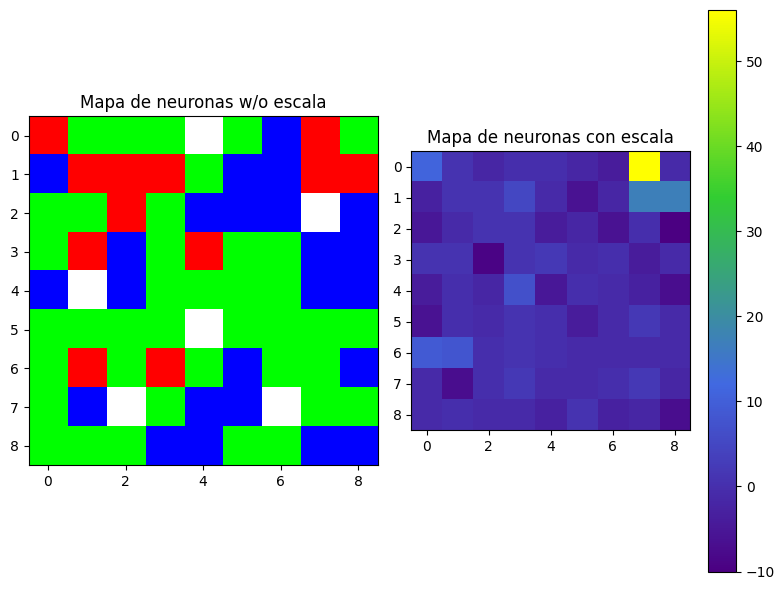

Number of blue neurons: 24
Number of red neurons: 12
Number of white neurons: 6
Number of green neurons: 39


NameError: name 'smote_enn_sinteticos' is not defined

In [88]:
y = kmssmote_oss.iloc[: , 3]
X = kmssmote_oss.drop(kmssmote_oss.columns[3], axis=1)
y = y.to_numpy()
X = X.to_numpy()
porcentaje = 0.8

# Inicializa un mapa de colores del tamaño del SOM con todos los valores en blanco
color_map = np.ones((9, 9, 3))

# Inicializa un mapa de clases del tamaño del SOM con todos los valores en -1
class_map = -1 * np.ones((9, 9))

# Contadores para cada neurona
counts = np.zeros((9, 9, 2), dtype=int)

# Itera sobre cada dato y su clase correspondiente
for datum, class_ in zip(X, y):
    # Encuentra la neurona ganadora para este dato
    winner = main_map.calculate_bmu(datum)[1]
    
    # Actualiza el contador de la clase para la neurona ganadora
    counts[int(winner[0]), int(winner[1]), int(class_)] += 1
    
    # Actualiza el mapa de clases con la clase reconocida
    class_map[winner] = class_

# Itera sobre cada neurona para determinar el color final
for i in range(9):
    for j in range(9):
        # Calcula el porcentaje de cada clase para la neurona actual
        percent_class_0 = counts[i, j, 0] / (counts[i, j, 0] + counts[i, j, 1]) if counts[i, j, 0] + counts[i, j, 1] > 0 else 0
        percent_class_1 = counts[i, j, 1] / (counts[i, j, 0] + counts[i, j, 1]) if counts[i, j, 0] + counts[i, j, 1] > 0 else 0
        
        # Asigna el color según las condiciones especificadas
        if percent_class_0 >= porcentaje:
            color_map[i, j] = [0, 0, 1]  # Azul
        elif percent_class_1 >= porcentaje:
            color_map[i, j] = [1, 0, 0]  # Rojo
        elif counts[i, j, 0] + counts[i, j, 1] == 0:
            color_map[i, j] = [1, 1, 1]  # Blanco si no ha reconocido ningún patrón
        else:
            color_map[i, j] = [0, 1, 0]  # Verde si no alcanza el % de ninguna clase

# Crea una figura con diferentes tamaños para los subplots
fig = plt.figure(figsize=(8, 6))

# Crea una leyenda para el primer gráfico
legend_elements = [Patch(facecolor='blue', edgecolor='b', label='Clase 0'),
                   Patch(facecolor='red', edgecolor='r', label='Clase 1'),
                   Patch(facecolor='green', edgecolor='g', label='Ambas clases')]
ax1 = fig.add_subplot(121)  # 121 significa "1 fila, 2 columnas, primer gráfico"
#ax1.legend(handles=legend_elements, loc='upper right')
ax1.imshow(np.rot90(color_map))
ax1.set_title('Mapa de neuronas w/o escala')

# Inicializa un mapa de neuronas con ceros
neuron_map = np.zeros((9, 9))
ganadores = np.zeros((9, 9))

# Itera sobre los datos y las clases
for datum, clss in zip(X, y):
    # Obtiene la neurona ganadora para el dato actual
    winner = main_map.calculate_bmu(datum)[1]
    ganadores[winner] = 1
    # Si la clase es 0, resta 1, si la clase es 1, suma 1
    neuron_map[winner[0], winner[1]] += 1 if clss == 1 else -1

# Normaliza el mapa de neuronas para que los valores estén entre -1 y 1
# neuron_map = neuron_map / np.max(np.abs(neuron_map))

# Define los colores de la escala como azul, verde y amarillo
cmap_colors = ["indigo", "royalblue", "limegreen", "yellow"]

# Crea el mapa de colores
cmap = LinearSegmentedColormap.from_list("mycmap", cmap_colors)

# Dibuja el mapa de calor
ax2 = fig.add_subplot(122)  # 122 significa "1 fila, 2 columnas, segundo gráfico"
im = ax2.imshow(np.rot90(neuron_map), cmap=cmap, interpolation='nearest')
ax2.set_title('Mapa de neuronas con escala')

# Muestra la barra de colores
fig.colorbar(im, ax=ax2)

# Ajusta el layout
plt.tight_layout()

# Muestra el gráfico
plt.show()

num_blue = np.sum(np.all(color_map == [0, 0, 1], axis=-1))
num_red = np.sum(np.all(color_map == [1, 0, 0], axis=-1))
num_white = np.sum(np.all(color_map == [1, 1, 1], axis=-1))
num_green = np.sum(np.all(color_map == [0, 1, 0], axis=-1))
# Print the number of neurons of each color
print(f"Number of blue neurons: {num_blue}")
print(f"Number of red neurons: {num_red}")
print(f"Number of white neurons: {num_white}")
print(f"Number of green neurons: {num_green}")

data_balanced_dropped_smote_edited_sint = smote_enn_sinteticos.drop(columns = [3])
data_balanced_dropped_smote_edited_sint=data_balanced_dropped_smote_edited_sint.to_numpy()
main_classification_smoted_enn_sinteticos = GEMA.Classification(main_map, data_balanced_dropped_smote_edited_sint)
GEMA.Visualization.heat_map(main_classification_smoted_enn_sinteticos)

In [ ]:
y = bsmote_tomek.iloc[: , 3]
X = bsmote_tomek.drop(bsmote_tomek.columns[3], axis=1)

# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

# Dividir el conjunto de entrenamiento en conjunto de entrenamiento y conjunto de validación
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

# Escalar las características para mejorar el rendimiento del modelo
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valn = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Crear un modelo secuencial en Keras
model = Sequential()
model.add(Dense(units=45, activation='relu', input_dim=3))  # Capa de entrada con 20 características
model.add(Dense(units=45, activation='relu'))  # Capa oculta con 32 neuronas y función de activación ReLU
model.add(Dense(units=1, activation='sigmoid'))  # Capa de salida con una neurona y función de activación sigmoide
pesos = model.get_weights()
# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=10, batch_size=32, validation_data=(X_val, y_val))

# Calcular Accuracy en el conjunto de entrenamiento
train_accuracy = accuracy_score(y_train, model.predict(X_train) > 0.5)

# Calcular Accuracy en el conjunto de validación
validation_accuracy = accuracy_score(y_val, model.predict(X_val) > 0.5)

print(f'Training Accuracy: {train_accuracy}')
print(f'Validation Accuracy: {validation_accuracy}')

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)  # Convertir las probabilidades en etiquetas binarias (0 o 1)

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Calcular la especificidad
TN = conf_matrix[0][0]  # Verdaderos negativos
FP = conf_matrix[0][1]  # Falsos positivos
specificity = TN / (TN + FP)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall (Sensibility): {recall}')
print(f'Specificity: {specificity}')

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Crear la matriz de confusión gráfica
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
y = bsmote_oss.iloc[: , 3]
X = bsmote_oss.drop(bsmote_oss.columns[3], axis=1)

# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

# Dividir el conjunto de entrenamiento en conjunto de entrenamiento y conjunto de validación
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

# Escalar las características para mejorar el rendimiento del modelo
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valn = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Crear un modelo secuencial en Keras
model = Sequential()
model.add(Dense(units=45, activation='relu', input_dim=3))  # Capa de entrada con 20 características
model.add(Dense(units=45, activation='relu'))  # Capa oculta con 32 neuronas y función de activación ReLU
model.add(Dense(units=1, activation='sigmoid'))  # Capa de salida con una neurona y función de activación sigmoide
model.set_weights(pesos)
# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_val, y_val))

# Calcular Accuracy en el conjunto de entrenamiento
train_accuracy = accuracy_score(y_train, model.predict(X_train) > 0.5)

# Calcular Accuracy en el conjunto de validación
validation_accuracy = accuracy_score(y_val, model.predict(X_val) > 0.5)

print(f'Training Accuracy: {train_accuracy}')
print(f'Validation Accuracy: {validation_accuracy}')

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)  # Convertir las probabilidades en etiquetas binarias (0 o 1)

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Calcular la especificidad
TN = conf_matrix[0][0]  # Verdaderos negativos
FP = conf_matrix[0][1]  # Falsos positivos
specificity = TN / (TN + FP)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall (Sensibility): {recall}')
print(f'Specificity: {specificity}')

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Crear la matriz de confusión gráfica
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Clasificación cancer con GEMA y Borderline SMOTE

In [ ]:
main_classification_bsmote_tomek = GEMA.Classification(main_map, data_bsmote_tomek)
print("bsmote+tommed quantification:",main_classification_bsmote_tomek.quantization_error)
print("bsmote+tommed topological:",main_classification_bsmote_tomek.topological_error)

main_classification_bsmote_edited= GEMA.Classification(main_map, data_bsmote_edited)
print("bsmote+edited quantification:",main_classification_bsmote_edited.quantization_error)
print("bsmote+edited topological:",main_classification_bsmote_edited.topological_error)

main_classification_bsmote_cnn= GEMA.Classification(main_map, data_bsmote_cnn)
print("bsmote+cnn quantification:",main_classification_bsmote_cnn.quantization_error)
print("bsmote+cnn topological:",main_classification_bsmote_cnn.topological_error)

main_classification_bsmote_ncr= GEMA.Classification(main_map, data_bsmote_ncr)
print("bsmote+ncr quantification:",main_classification_bsmote_ncr.quantization_error)
print("bsmote+ncr topological:",main_classification_bsmote_ncr.topological_error)

main_classification_bsmote_oss= GEMA.Classification(main_map, data_bsmote_oss)
print("bsmote+oss quantification:",main_classification_bsmote_oss.quantization_error)
print("bsmote+oss topological:",main_classification_bsmote_oss.topological_error)

In [ ]:
def smote_enn_clase0(dataset, target):

    print(dataset.head(5))
    print(dataset[3].value_counts())   

    # Separar las características y el target
    X = dataset.drop(target, axis=1)
    y = dataset[target]

    # Guardar los índices de las filas originales
    original_indices = X.index

    # Crear una instancia de SMOTE
    smote = BorderlineSMOTE(sampling_strategy={0: int(len(y[y==0])*1.7), 1: len(y[y==1])})

    # Crear una instancia de Condensed Nearest Neighbour
    enn = TomekLinks(sampling_strategy='all')
    pipeline = Pipeline([('BSMOTE', smote), ('TMK', enn)])

    X_resampled, y_resampled = pipeline.fit_resample(X, y)

    # Redimensionamos las clases.
    y_resampled = y_resampled.to_numpy().reshape(-1, 1)
    y_resampled = y_resampled.reshape(np.size(X_resampled, 0),1)
    
    cols_df = dataset.columns
    cols_df = cols_df.drop(target)
    
    synthetic_data = pd.DataFrame(X_resampled, columns=cols_df)
    synthetic_data[target] = y_resampled

    # Eliminar las filas del conjunto de datos sobremuestreado que corresponden a las filas originales
    synthetic_data_only = synthetic_data.drop(original_indices)
                
    return synthetic_data_only

def smote_enn_clase1(dataset, target):

    print(dataset.head(5))
    print(dataset[3].value_counts())   

    # Separar las características y el target
    X = dataset.drop(target, axis=1)
    y = dataset[target]

    # Guardar los índices de las filas originales
    original_indices = X.index

    # Crear una instancia de SMOTE
    smote = BorderlineSMOTE(sampling_strategy='auto')

    # Crear una instancia de Condensed Nearest Neighbour
    enn = TomekLinks(sampling_strategy='all')
    pipeline = Pipeline([('BSMOTE', smote), ('TMK', enn)])

    X_resampled, y_resampled = pipeline.fit_resample(X, y)

    # Redimensionamos las clases.
    y_resampled = y_resampled.to_numpy().reshape(-1, 1)
    y_resampled = y_resampled.reshape(np.size(X_resampled, 0),1)
    
    cols_df = dataset.columns
    cols_df = cols_df.drop(target)
    
    synthetic_data = pd.DataFrame(X_resampled, columns=cols_df)
    synthetic_data[target] = y_resampled

    # Eliminar las filas del conjunto de datos sobremuestreado que corresponden a las filas originales
    synthetic_data_only = synthetic_data.drop(original_indices)
                
    return synthetic_data_only

Smote_enn_sinteticos0=smote_enn_clase0(data_std,3)
Smote_enn_sinteticos1=smote_enn_clase1(data_std,3)
smote_enn_sinteticos = pd.concat([Smote_enn_sinteticos0, Smote_enn_sinteticos1], axis=0, ignore_index=True)
print(smote_enn_sinteticos.head(5))
print(smote_enn_sinteticos[3].value_counts())

In [ ]:
y = smote_enn_sinteticos.iloc[: , 3]
X = smote_enn_sinteticos.drop(smote_enn_sinteticos.columns[3], axis=1)
y = y.to_numpy()
X = X.to_numpy()
porcentaje = 0.8

# Inicializa un mapa de colores del tamaño del SOM con todos los valores en blanco
color_map = np.ones((9, 9, 3))

# Inicializa un mapa de clases del tamaño del SOM con todos los valores en -1
class_map = -1 * np.ones((9, 9))

# Contadores para cada neurona
counts = np.zeros((9, 9, 2), dtype=int)

# Itera sobre cada dato y su clase correspondiente
for datum, class_ in zip(X, y):
    # Encuentra la neurona ganadora para este dato
    winner = main_map.calculate_bmu(datum)[1]
    
    # Actualiza el contador de la clase para la neurona ganadora
    counts[int(winner[0]), int(winner[1]), int(class_)] += 1
    
    # Actualiza el mapa de clases con la clase reconocida
    class_map[winner] = class_

# Itera sobre cada neurona para determinar el color final
for i in range(9):
    for j in range(9):
        # Calcula el porcentaje de cada clase para la neurona actual
        percent_class_0 = counts[i, j, 0] / (counts[i, j, 0] + counts[i, j, 1]) if counts[i, j, 0] + counts[i, j, 1] > 0 else 0
        percent_class_1 = counts[i, j, 1] / (counts[i, j, 0] + counts[i, j, 1]) if counts[i, j, 0] + counts[i, j, 1] > 0 else 0
        
        # Asigna el color según las condiciones especificadas
        if percent_class_0 >= porcentaje:
            color_map[i, j] = [0, 0, 1]  # Azul
        elif percent_class_1 >= porcentaje:
            color_map[i, j] = [1, 0, 0]  # Rojo
        elif counts[i, j, 0] + counts[i, j, 1] == 0:
            color_map[i, j] = [1, 1, 1]  # Blanco si no ha reconocido ningún patrón
        else:
            color_map[i, j] = [0, 1, 0]  # Verde si no alcanza el 80% de ninguna clase

# Crea una figura con diferentes tamaños para los subplots
fig = plt.figure(figsize=(8, 6))

# Crea una leyenda para el primer gráfico
legend_elements = [Patch(facecolor='blue', edgecolor='b', label='Clase 0'),
                   Patch(facecolor='red', edgecolor='r', label='Clase 1'),
                   Patch(facecolor='green', edgecolor='g', label='Ambas clases')]
ax1 = fig.add_subplot(121)  # 121 significa "1 fila, 2 columnas, primer gráfico"
#ax1.legend(handles=legend_elements, loc='upper right')
ax1.imshow(np.rot90(color_map))
ax1.set_title('Mapa de neuronas w/o escala')

# Inicializa un mapa de neuronas con ceros
neuron_map = np.zeros((9, 9))
ganadores = np.zeros((9, 9))

# Itera sobre los datos y las clases
for datum, clss in zip(X, y):
    # Obtiene la neurona ganadora para el dato actual
    winner = main_map.calculate_bmu(datum)[1]
    ganadores[winner] = 1
    print(winner, clss)
    # Si la clase es 0, resta 1, si la clase es 1, suma 1
    neuron_map[winner[0], winner[1]] += 1 if clss == 1 else -1

# Normaliza el mapa de neuronas para que los valores estén entre -1 y 1
# neuron_map = neuron_map / np.max(np.abs(neuron_map))

# Define los colores de la escala como azul, verde y amarillo
cmap_colors = ["indigo", "royalblue", "limegreen", "yellow"]

# Crea el mapa de colores
cmap = LinearSegmentedColormap.from_list("mycmap", cmap_colors)

# Dibuja el mapa de calor
ax2 = fig.add_subplot(122)  # 122 significa "1 fila, 2 columnas, segundo gráfico"
im = ax2.imshow(np.rot90(neuron_map), cmap=cmap, interpolation='nearest')
ax2.set_title('Mapa de neuronas con escala')

# Muestra la barra de colores
fig.colorbar(im, ax=ax2)

# Ajusta el layout
plt.tight_layout()

# Muestra el gráfico
plt.show()

data_balanced_dropped_smote_edited_sint = smote_enn_sinteticos.drop(columns = [3])
data_balanced_dropped_smote_edited_sint=data_balanced_dropped_smote_edited_sint.to_numpy()
main_classification_smoted_enn_sinteticos = GEMA.Classification(main_map, data_balanced_dropped_smote_edited_sint)
GEMA.Visualization.heat_map(main_classification_smoted_enn_sinteticos)

## Clasificación cancer con Minisom y Borderline SMOTE

In [ ]:
print("bsmote+tommed")
print(som.quantization_error(data_bsmote_tomek), som.topographic_error(data_bsmote_tomek))
print("bsmote+linked")
print(som.quantization_error(data_bsmote_edited), som.topographic_error(data_bsmote_edited))
print("bsmote+cnn")
print(som.quantization_error(data_bsmote_cnn), som.topographic_error(data_bsmote_cnn))
print("bsmote+ncr")
print(som.quantization_error(data_bsmote_ncr), som.topographic_error(data_bsmote_ncr))
print("bsmote+oss")
print(som.quantization_error(data_bsmote_oss), som.topographic_error(data_bsmote_oss))

## SVM SMOTE Cancer

In [67]:
## SVMSMOTE + Tomed_links
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 3)
data_std = wf.min_max_normalization(datos_mode)

svmsmote_tomek=wf.SVMSMOTE_tomek(data_std,3)
print(svmsmote_tomek[3].value_counts())
data_svmsmote_tomek = svmsmote_tomek.drop(columns = [3])
data_svmsmote_tomek=data_svmsmote_tomek.to_numpy()

## SVMSMOTE + ENN
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 3)
data_std = wf.min_max_normalization(datos_mode)

svmsmote_edited=wf.SVMSMOTE_enn(data_std,3)
print(svmsmote_edited[3].value_counts())
data_svmsmote_edited = svmsmote_edited.drop(columns = [3])
data_svmsmote_edited=data_svmsmote_edited.to_numpy()

## SVMSMOTE con CNN (condensed nearest neighbors)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 3)
data_std = wf.min_max_normalization(datos_mode)

svmsmote_cnn=wf.SVMSMOTE_cnn(data_std,3)
print(svmsmote_cnn[3].value_counts())
data_svmsmote_cnn = svmsmote_cnn.drop(columns = [3])
data_svmsmote_cnn=data_svmsmote_cnn.to_numpy()

## SVMSMOTE con NCR (Neighboorhood cleaning rule)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 3)
data_std = wf.min_max_normalization(datos_mode)

svmsmote_ncr=wf.SVMSMOTE_ncr(data_std,3)
print(svmsmote_ncr[3].value_counts())
data_svmsmote_ncr = svmsmote_ncr.drop(columns = [3])
data_svmsmote_ncr=data_svmsmote_ncr.to_numpy()

## SVMSMOTE con OSD (One sided selection)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 3)
data_std = wf.min_max_normalization(datos_mode)

svmsmote_oss=wf.SVMSMOTE_oss(data_std,3)
print(svmsmote_oss[3].value_counts())
data_svmsmote_oss = svmsmote_oss.drop(columns = [3])
data_svmsmote_oss=data_svmsmote_oss.to_numpy()

Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  4
0.0    225
1.0    206
Name: 3, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  4
0.0    225
1.0    184
Name: 3, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  4
0.0    245
1.0    237
Name: 3, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  4
0.0    225
1.0    184
Name: 3, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  4
0.0    245
1.0    232
Name: 3, dtype: int64


In [ ]:
y = svmsmote_tomek.iloc[: , 3]
X = svmsmote_tomek.drop(svmsmote_tomek.columns[3], axis=1)

# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

# Dividir el conjunto de entrenamiento en conjunto de entrenamiento y conjunto de validación
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

# Escalar las características para mejorar el rendimiento del modelo
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valn = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Crear un modelo secuencial en Keras
model = Sequential()
model.add(Dense(units=45, activation='relu', input_dim=3))  # Capa de entrada con 20 características
model.add(Dense(units=45, activation='relu'))  # Capa oculta con 32 neuronas y función de activación ReLU
model.add(Dense(units=1, activation='sigmoid'))  # Capa de salida con una neurona y función de activación sigmoide
pesos = model.get_weights()
# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_val, y_val))

# Calcular Accuracy en el conjunto de entrenamiento
train_accuracy = accuracy_score(y_train, model.predict(X_train) > 0.5)

# Calcular Accuracy en el conjunto de validación
validation_accuracy = accuracy_score(y_val, model.predict(X_val) > 0.5)

print(f'Training Accuracy: {train_accuracy}')
print(f'Validation Accuracy: {validation_accuracy}')

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)  # Convertir las probabilidades en etiquetas binarias (0 o 1)

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Calcular la especificidad
TN = conf_matrix[0][0]  # Verdaderos negativos
FP = conf_matrix[0][1]  # Falsos positivos
specificity = TN / (TN + FP)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall (Sensibility): {recall}')
print(f'Specificity: {specificity}')

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Crear la matriz de confusión gráfica
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()


In [ ]:
y = svmsmote_oss.iloc[: , 3]
X = svmsmote_oss.drop(svmsmote_oss.columns[3], axis=1)

# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

# Dividir el conjunto de entrenamiento en conjunto de entrenamiento y conjunto de validación
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

# Escalar las características para mejorar el rendimiento del modelo
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valn = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Crear un modelo secuencial en Keras
model = Sequential()
model.add(Dense(units=45, activation='relu', input_dim=3))  # Capa de entrada con 20 características
model.add(Dense(units=45, activation='relu'))  # Capa oculta con 32 neuronas y función de activación ReLU
model.add(Dense(units=1, activation='sigmoid'))  # Capa de salida con una neurona y función de activación sigmoide
model.set_weights(pesos)
# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_val, y_val))

# Calcular Accuracy en el conjunto de entrenamiento
train_accuracy = accuracy_score(y_train, model.predict(X_train) > 0.5)

# Calcular Accuracy en el conjunto de validación
validation_accuracy = accuracy_score(y_val, model.predict(X_val) > 0.5)

print(f'Training Accuracy: {train_accuracy}')
print(f'Validation Accuracy: {validation_accuracy}')

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)  # Convertir las probabilidades en etiquetas binarias (0 o 1)

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Calcular la especificidad
TN = conf_matrix[0][0]  # Verdaderos negativos
FP = conf_matrix[0][1]  # Falsos positivos
specificity = TN / (TN + FP)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall (Sensibility): {recall}')
print(f'Specificity: {specificity}')

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Crear la matriz de confusión gráfica
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Clasificación cancer con GEMA y SVM SMOTE

In [ ]:
main_classification_svmsmote_tomek = GEMA.Classification(main_map, data_svmsmote_tomek)
print("svmsmote+tommed quantification:",main_classification_svmsmote_tomek.quantization_error)
print("svmsmote+tommed topological:",main_classification_svmsmote_tomek.topological_error)

main_classification_svmsmote_edited= GEMA.Classification(main_map, data_svmsmote_edited)
print("svmsmote+edited quantification:",main_classification_svmsmote_edited.quantization_error)
print("svmsmote+edited topological:",main_classification_svmsmote_edited.topological_error)

main_classification_svmsmote_cnn= GEMA.Classification(main_map, data_svmsmote_cnn)
print("svmsmote+cnn quantification:",main_classification_svmsmote_cnn.quantization_error)
print("svmsmote+cnn topological:",main_classification_svmsmote_cnn.topological_error)

main_classification_svmsmote_ncr= GEMA.Classification(main_map, data_svmsmote_ncr)
print("svmsmote+ncr quantification:",main_classification_svmsmote_ncr.quantization_error)
print("svmsmote+ncr topological:",main_classification_svmsmote_ncr.topological_error)

main_classification_svmsmote_oss= GEMA.Classification(main_map, data_svmsmote_oss)
print("svmsmote+oss quantification:",main_classification_svmsmote_oss.quantization_error)
print("svmsmote+oss topological:",main_classification_svmsmote_oss.topological_error)

## Clasificación cancer con Minisom y SVM SMOTE

In [ ]:
print("svmsmote+tommed")
print(som.quantization_error(data_svmsmote_tomek), som.topographic_error(data_svmsmote_tomek))
print("svmsmote+linked")
print(som.quantization_error(data_svmsmote_edited), som.topographic_error(data_svmsmote_edited))
print("svmsmote+cnn")
print(som.quantization_error(data_svmsmote_cnn), som.topographic_error(data_svmsmote_cnn))
print("svmsmote+ncr")
print(som.quantization_error(data_svmsmote_ncr), som.topographic_error(data_svmsmote_ncr))
print("svmsmote+oss")
print(som.quantization_error(data_svmsmote_oss), som.topographic_error(data_svmsmote_oss))

## Kmeans SMOTE cancer

In [79]:
## KMSSMOTE + Tomed_links
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 3)
data_std = wf.min_max_normalization(datos_mode)

kmssmote_tomek=wf.KMSSMOTE_tomek(data_std,3)
print(kmssmote_tomek[3].value_counts())
data_kmssmote_tomek = kmssmote_tomek.drop(columns = [3])
data_kmssmote_tomek=data_kmssmote_tomek.to_numpy()

## KMSSMOTE + ENN
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 3)
data_std = wf.min_max_normalization(datos_mode)

kmssmote_edited=wf.KMSSMOTE_enn(data_std,3)
print(kmssmote_edited[3].value_counts())
data_kmssmote_edited = kmssmote_edited.drop(columns = [3])
data_kmssmote_edited=data_kmssmote_edited.to_numpy()

## KMSSMOTE con CNN (condensed nearest neighbors)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 3)
data_std = wf.min_max_normalization(datos_mode)

kmssmote_cnn=wf.KMSSMOTE_cnn(data_std,3)
print(kmssmote_cnn[3].value_counts())
data_kmssmote_cnn = kmssmote_cnn.drop(columns = [3])
data_kmssmote_cnn=data_kmssmote_cnn.to_numpy()

## KMSSMOTE con NCR (Neighboorhood cleaning rule)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 3)
data_std = wf.min_max_normalization(datos_mode)

kmssmote_ncr=wf.KMSSMOTE_ncr(data_std,3)
print(kmssmote_ncr[3].value_counts())
data_kmssmote_ncr = kmssmote_ncr.drop(columns = [3])
data_kmssmote_ncr=data_kmssmote_ncr.to_numpy()

## KMSSMOTE con OSD (One sided selection)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 3)
data_std = wf.min_max_normalization(datos_mode)

kmssmote_oss=wf.KMSSMOTE_oss(data_std,3)
print(kmssmote_oss[3].value_counts())
data_kmssmote_oss = kmssmote_oss.drop(columns = [3])
data_kmssmote_oss=data_kmssmote_oss.to_numpy()

Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  4
0.0    225
1.0    215
Name: 3, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  4
0.0    225
1.0    189
Name: 3, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  4
1.0    248
0.0    241
Name: 3, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  4
1.0    248
0.0    188
Name: 3, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  4
1.0    248
0.0    232
Name: 3, dtype: int64


In [ ]:
y = kmssmote_tomek.iloc[: , 3]
X = kmssmote_tomek.drop(kmssmote_tomek.columns[3], axis=1)

# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

# Dividir el conjunto de entrenamiento en conjunto de entrenamiento y conjunto de validación
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

# Escalar las características para mejorar el rendimiento del modelo
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valn = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Crear un modelo secuencial en Keras
model = Sequential()
model.add(Dense(units=45, activation='relu', input_dim=3))  # Capa de entrada con 20 características
model.add(Dense(units=45, activation='relu'))  # Capa oculta con 32 neuronas y función de activación ReLU
model.add(Dense(units=1, activation='sigmoid'))  # Capa de salida con una neurona y función de activación sigmoide
pesos = model.get_weights()
# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_val, y_val))

# Calcular Accuracy en el conjunto de entrenamiento
train_accuracy = accuracy_score(y_train, model.predict(X_train) > 0.5)

# Calcular Accuracy en el conjunto de validación
validation_accuracy = accuracy_score(y_val, model.predict(X_val) > 0.5)

print(f'Training Accuracy: {train_accuracy}')
print(f'Validation Accuracy: {validation_accuracy}')

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)  # Convertir las probabilidades en etiquetas binarias (0 o 1)

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Calcular la especificidad
TN = conf_matrix[0][0]  # Verdaderos negativos
FP = conf_matrix[0][1]  # Falsos positivos
specificity = TN / (TN + FP)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall (Sensibility): {recall}')
print(f'Specificity: {specificity}')

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Crear la matriz de confusión gráfica
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

In [ ]:
y = kmssmote_oss.iloc[: , 3]
X = kmssmote_oss.drop(kmssmote_oss.columns[3], axis=1)

# Dividir los datos en conjunto de entrenamiento y conjunto de prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, shuffle=True)

# Dividir el conjunto de entrenamiento en conjunto de entrenamiento y conjunto de validación
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.2, random_state=42, shuffle=True)

# Escalar las características para mejorar el rendimiento del modelo
scaler = StandardScaler()
X_train = scaler.fit_transform(X_train)
X_valn = scaler.transform(X_val)
X_test = scaler.transform(X_test)

# Crear un modelo secuencial en Keras
model = Sequential()
model.add(Dense(units=45, activation='relu', input_dim=3))  # Capa de entrada con 20 características
model.add(Dense(units=45, activation='relu'))  # Capa oculta con 32 neuronas y función de activación ReLU
model.add(Dense(units=1, activation='sigmoid'))  # Capa de salida con una neurona y función de activación sigmoide
model.set_weights(pesos)
# Compilar el modelo
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['accuracy'])

# Entrenar el modelo
history = model.fit(X_train, y_train, epochs=25, batch_size=32, validation_data=(X_val, y_val))

# Calcular Accuracy en el conjunto de entrenamiento
train_accuracy = accuracy_score(y_train, model.predict(X_train) > 0.5)

# Calcular Accuracy en el conjunto de validación
validation_accuracy = accuracy_score(y_val, model.predict(X_val) > 0.5)

print(f'Training Accuracy: {train_accuracy}')
print(f'Validation Accuracy: {validation_accuracy}')

# Realizar predicciones en el conjunto de prueba
y_pred = model.predict(X_test)
y_pred = (y_pred > 0.5)  # Convertir las probabilidades en etiquetas binarias (0 o 1)

# Calcular métricas
accuracy = accuracy_score(y_test, y_pred)
precision = precision_score(y_test, y_pred)
recall = recall_score(y_test, y_pred)
# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Calcular la especificidad
TN = conf_matrix[0][0]  # Verdaderos negativos
FP = conf_matrix[0][1]  # Falsos positivos
specificity = TN / (TN + FP)

print(f'Accuracy: {accuracy}')
print(f'Precision: {precision}')
print(f'Recall (Sensibility): {recall}')
print(f'Specificity: {specificity}')

# Calcular la matriz de confusión
conf_matrix = confusion_matrix(y_test, y_pred)

# Crear la matriz de confusión gráfica
plt.figure(figsize=(6, 6))
sns.heatmap(conf_matrix, annot=True, fmt="d", cmap="Blues")
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.show()

## Clasificación cancer con GEMA y Kmeans SMOTE

In [ ]:
main_classification_kmssmote_tomek = GEMA.Classification(main_map, data_kmssmote_tomek)
print("svmsmote+tommed quantification:",main_classification_kmssmote_tomek.quantization_error)
print("svmsmote+tommed topological:",main_classification_kmssmote_tomek.topological_error)

main_classification_kmssmote_edited= GEMA.Classification(main_map, data_kmssmote_edited)
print("svmsmote+edited quantification:",main_classification_kmssmote_edited.quantization_error)
print("svmsmote+edited topological:",main_classification_kmssmote_edited.topological_error)

main_classification_kmssmote_cnn= GEMA.Classification(main_map, data_kmssmote_cnn)
print("svmsmote+cnn quantification:",main_classification_kmssmote_cnn.quantization_error)
print("svmsmote+cnn topological:",main_classification_kmssmote_cnn.topological_error)

main_classification_kmssmote_ncr= GEMA.Classification(main_map, data_kmssmote_ncr)
print("svmsmote+ncr quantification:",main_classification_kmssmote_ncr.quantization_error)
print("svmsmote+ncr topological:",main_classification_kmssmote_ncr.topological_error)

main_classification_kmssmote_oss= GEMA.Classification(main_map, data_kmssmote_oss)
print("svmsmote+oss quantification:",main_classification_kmssmote_oss.quantization_error)
print("svmsmote+oss topological:",main_classification_kmssmote_oss.topological_error)

## Clasificación cancer con Minisom y Kmeans SMOTE

In [ ]:
print("kmssmote+tommed")
print(som.quantization_error(data_kmssmote_tomek), som.topographic_error(data_kmssmote_tomek))
print("kmssmote+linked")
print(som.quantization_error(data_kmssmote_edited), som.topographic_error(data_kmssmote_edited))
print("kmssmote+cnn")
print(som.quantization_error(data_kmssmote_cnn), som.topographic_error(data_kmssmote_cnn))
print("kmssmote+ncr")
print(som.quantization_error(data_kmssmote_ncr), som.topographic_error(data_kmssmote_ncr))
print("kmssmote+oss")
print(som.quantization_error(data_kmssmote_oss), som.topographic_error(data_kmssmote_oss))

## Importar dataset de creditos bancarios


In [32]:
## Importar dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/german.csv'
missing_values = [' ', 'NaN', 'na', 'Na', '-', '--', 'n/a', '?']
columns = ['class']
data = pd.read_csv(url, na_values = missing_values, header=None)
columns_to_encode = [0, 2, 3, 4, 5, 6, 8, 9, 11, 13, 14, 16, 18, 19]

# Inicializar el LabelEncoder
label_encoder = LabelEncoder()

# Aplicar LabelEncoder a las columnas seleccionadas
for column in columns_to_encode:
    data[column] = label_encoder.fit_transform(data[column])

data[20] = data[20].replace({1: 0, 2: 1})

In [ ]:
data

In [33]:
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = data_dropped
datos_mode = wf.mode_imputation(data_dropped, 3)
datos_mode[20].value_counts()


Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  21


0    700
1    300
Name: 20, dtype: int64

In [34]:
datos_mode=datos_mode.drop(columns = [20])
df = datos_mode.astype(int, errors='ignore')
print(df)
data_std = wf.min_max_normalization(datos_mode)
target = data[20].values
label_names={0:'malo', 1:'bueno'}
data_som=data_std.to_numpy()

     0   1   2   3    4   5   6   7   8   9   10  11  12  13  14  15  16  17  \
0     0   6   4   4  142   4   4   4   2   0   4   0  67   2   1   2   2   1   
1     1  48   2   4  770   0   2   2   1   0   2   0  22   2   1   1   2   1   
2     3  12   4   7  390   0   3   2   2   0   3   0  49   2   1   1   1   2   
3     0  42   2   3  848   0   3   2   2   2   4   1  45   2   2   1   2   2   
4     0  24   3   0  734   0   2   3   2   0   4   3  53   2   2   2   2   2   
..   ..  ..  ..  ..  ...  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..  ..   
995   3  12   2   3  310   0   3   3   1   0   4   0  31   2   1   1   1   1   
996   0  30   2   1  661   0   2   4   0   0   4   1  40   2   1   1   3   1   
997   3  12   2   4   69   0   4   4   2   0   4   2  38   2   1   1   2   1   
998   0  45   2   4  332   0   2   4   2   0   4   3  23   2   2   1   2   1   
999   1  45   4   1  711   1   0   3   2   0   4   2  27   2   1   1   2   1   

     18  19  
0     1   0  
1     0   0

In [ ]:
data_som

## Entrenamiento GEMA créditos

In [35]:
main_map = GEMA.Map(data_som, 
                    13, 
                    5000, 
                    initial_lr=0.3, 
                    initial_neighbourhood = 0,
                    distance = 'euclidean',
                    use_decay= False,
                    presentation= 'random',
                    weights = 'random')

main_classification = GEMA.Classification(main_map, data_som)
print("quantification error:",main_classification.quantization_error)
print("Topological_error:",main_classification.topological_error)

TRAINING...


  0%|          | 0/5000 [00:00<?, ?it/s]

FINISHED.


  0%|          | 0/1000 [00:00<?, ?it/s]

quantification error: 0.97522858
Topological_error: 0.168


(4, 3) 0
(6, 10) 1
(9, 5) 0
(8, 6) 0
(4, 12) 1
(4, 0) 0
(8, 1) 0
(3, 8) 0
(7, 2) 0
(6, 10) 1
(11, 9) 1
(8, 12) 1
(2, 8) 0
(4, 11) 1
(7, 8) 0
(12, 8) 1
(6, 0) 0
(9, 12) 0
(3, 10) 1
(0, 0) 0
(1, 1) 0
(8, 6) 0
(8, 6) 0
(12, 5) 0
(9, 2) 0
(0, 8) 0
(9, 0) 0
(8, 2) 0
(9, 10) 0
(2, 11) 1
(0, 9) 0
(6, 10) 0
(3, 9) 0
(6, 0) 0
(0, 8) 0
(6, 10) 1
(0, 10) 0
(10, 10) 1
(2, 5) 0
(12, 6) 0
(11, 12) 0
(0, 6) 0
(6, 6) 0
(6, 8) 0
(4, 12) 1
(12, 2) 0
(8, 0) 0
(6, 6) 0
(10, 4) 0
(11, 3) 0
(11, 12) 0
(3, 9) 0
(11, 0) 0
(4, 2) 0
(0, 11) 1
(8, 4) 0
(1, 9) 1
(12, 0) 0
(11, 0) 0
(4, 7) 1
(0, 8) 0
(4, 3) 0
(3, 12) 1
(2, 9) 1
(1, 3) 0
(4, 0) 0
(10, 12) 0
(11, 8) 0
(1, 2) 1
(8, 0) 0
(10, 12) 0
(3, 1) 0
(0, 12) 0
(10, 11) 0
(4, 3) 1
(4, 12) 0
(7, 12) 1
(6, 9) 0
(7, 4) 0
(6, 10) 0
(4, 2) 1
(2, 2) 0
(12, 4) 0
(4, 6) 0
(12, 6) 0
(0, 5) 0
(12, 8) 0
(1, 12) 1
(1, 12) 0
(12, 6) 1
(12, 4) 0
(12, 7) 0
(6, 0) 1
(7, 0) 0
(4, 3) 0
(3, 8) 1
(6, 0) 0
(6, 12) 0
(12, 5) 0
(0, 12) 0
(9, 1) 0
(7, 12) 0
(11, 3) 0
(2, 6) 0
(4, 2) 0


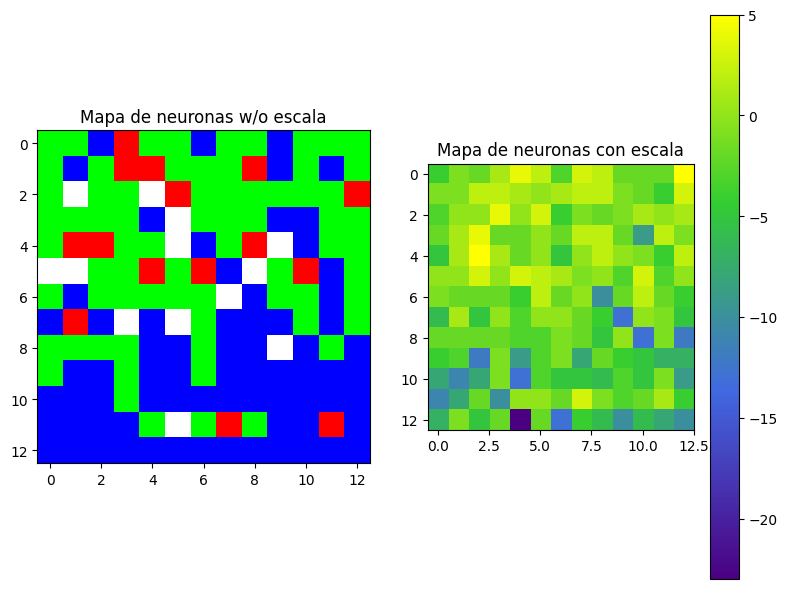

Number of blue neurons: 71
Number of red neurons: 15
Number of white neurons: 13
Number of green neurons: 70


In [37]:
#import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import LinearSegmentedColormap

porcentaje = 0.8

# Inicializa un mapa de colores del tamaño del SOM con todos los valores en blanco
color_map = np.ones((13, 13, 3))

# Inicializa un mapa de clases del tamaño del SOM con todos los valores en -1
class_map = -1 * np.ones((13, 13))

# Contadores para cada neurona
counts = np.zeros((13, 13, 2), dtype=int)

# Itera sobre cada dato y su clase correspondiente
for datum, class_ in zip(data_som, target):
    # Encuentra la neurona ganadora para este dato
    winner = main_map.calculate_bmu(datum)[1]
    
    # Actualiza el contador de la clase para la neurona ganadora
    counts[int(winner[0]), int(winner[1]), int(class_)] += 1
    
    # Actualiza el mapa de clases con la clase reconocida
    class_map[winner] = class_

# Itera sobre cada neurona para determinar el color final
for i in range(13):
    for j in range(13):
        # Calcula el porcentaje de cada clase para la neurona actual
        percent_class_0 = counts[i, j, 0] / (counts[i, j, 0] + counts[i, j, 1]) if counts[i, j, 0] + counts[i, j, 1] > 0 else 0
        percent_class_1 = counts[i, j, 1] / (counts[i, j, 0] + counts[i, j, 1]) if counts[i, j, 0] + counts[i, j, 1] > 0 else 0
        
        # Asigna el color según las condiciones especificadas
        if percent_class_0 >= porcentaje:
            color_map[i, j] = [0, 0, 1]  # Azul
        elif percent_class_1 >= porcentaje:
            color_map[i, j] = [1, 0, 0]  # Rojo
        elif counts[i, j, 0] + counts[i, j, 1] == 0:
            color_map[i, j] = [1, 1, 1]  # Blanco si no ha reconocido ningún patrón
        else:
            color_map[i, j] = [0, 1, 0]  # Verde si no alcanza el 80% de ninguna clase


# Count the number of neurons of each color
num_blue = np.sum(np.all(color_map == [0, 0, 1], axis=-1))
num_red = np.sum(np.all(color_map == [1, 0, 0], axis=-1))
num_white = np.sum(np.all(color_map == [1, 1, 1], axis=-1))
num_green = np.sum(np.all(color_map == [0, 1, 0], axis=-1))

# Crea una figura con diferentes tamaños para los subplots
fig = plt.figure(figsize=(8, 6))

# Crea una leyenda para el primer gráfico
legend_elements = [Patch(facecolor='blue', edgecolor='b', label='Clase 0'),
                   Patch(facecolor='red', edgecolor='r', label='Clase 1'),
                   Patch(facecolor='green', edgecolor='g', label='Ambas clases')]
ax1 = fig.add_subplot(121)  # 121 significa "1 fila, 2 columnas, primer gráfico"
# ax1.legend(handles=legend_elements, loc='upper right')
ax1.imshow(np.rot90(color_map))
ax1.set_title('Mapa de neuronas w/o escala')

# Inicializa un mapa de neuronas con ceros
neuron_map = np.zeros((13, 13))
ganadores = np.zeros((13, 13))

# Itera sobre los datos y las clases
for datum, clss in zip(data_som, target):
    # Obtiene la neurona ganadora para el dato actual
    winner = main_map.calculate_bmu(datum)[1]
    ganadores[winner] = 1
    print(winner, clss)
    # Si la clase es 0, resta 1, si la clase es 1, suma 1
    neuron_map[winner[0], winner[1]] += 1 if clss == 1 else -1

# Normaliza el mapa de neuronas para que los valores estén entre -1 y 1
# neuron_map = neuron_map / np.max(np.abs(neuron_map))

# Define los colores de la escala como azul, verde y amarillo
cmap_colors = ["indigo", "royalblue", "limegreen", "yellow"]

# Crea el mapa de colores
cmap = LinearSegmentedColormap.from_list("mycmap", cmap_colors)

# Dibuja el mapa de calor
ax2 = fig.add_subplot(122)  # 122 significa "1 fila, 2 columnas, segundo gráfico"
im = ax2.imshow(np.rot90(neuron_map), cmap=cmap, interpolation='nearest')
ax2.set_title('Mapa de neuronas con escala')

# Muestra la barra de colores
fig.colorbar(im, ax=ax2)

# Ajusta el layout
plt.tight_layout()

# Muestra el gráfico
plt.show()

# Print the number of neurons of each color
print(f"Number of blue neurons: {num_blue}")
print(f"Number of red neurons: {num_red}")
print(f"Number of white neurons: {num_white}")
print(f"Number of green neurons: {num_green}")

In [ ]:
#GEMA.Visualization.codebook_vectors(main_map, np.array(["Not Spiled", "Spiled"]))

## Entrenamiento Minisom créditos

In [ ]:
n_neurons = 17
m_neurons = 17

som = MiniSom(n_neurons, m_neurons, data_som.shape[1], learning_rate=0.27199933063716647, random_seed=42)
som.train(data_som, num_iteration=9400, verbose=True)  # random training
print("Topological error:",som.topographic_error(data_som))

## SMOTE créditos

In [29]:
## Smote + Tomed_links
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 20)
data_std = wf.min_max_normalization(datos_mode)

Smote_tomed=wf.smote_tomed_link(data_std,20)
print(Smote_tomed[20].value_counts())
# Smote_tomed= Smote_tomed.reset_index(drop=True, inplace=True)
# data_std= data_std.reset_index(drop=True, inplace=True)
# diferentes=Smote_tomed[(Smote_tomed == data_std).all(axis=1) == False]
# print(diferentes)
data_balanced_dropped_smote_tomed = Smote_tomed.drop(columns = [20])
data_balanced_dropped_smote_tomed=data_balanced_dropped_smote_tomed.to_numpy()

## smote_edited_nearest_neighbor
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 20)
data_std = wf.min_max_normalization(datos_mode)

Smote_edited=wf.smote_edited_nearest_neighbor(data_std,20)
print(Smote_edited[20].value_counts())
data_balanced_dropped_smote_edited = Smote_edited.drop(columns = [20])
data_balanced_dropped_smote_edited=data_balanced_dropped_smote_edited.to_numpy()

## smote con CNN (condensed nearest neighbors)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 20)
data_std = wf.min_max_normalization(datos_mode)

Smote_cnn=wf.smote_cnn(data_std,20)
print(Smote_cnn[20].value_counts())
data_smote_cnn = Smote_cnn.drop(columns = [20])
data_smote_cnn=data_smote_cnn.to_numpy()

## smote con NCR (Neighboorhood cleaning rule)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 20)
data_std = wf.min_max_normalization(datos_mode)

Smote_ncr=wf.smote_ncr(data_std,20)
print(Smote_ncr[20].value_counts())
data_smote_ncr = Smote_ncr.drop(columns = [20])
data_smote_ncr=data_smote_ncr.to_numpy()

## smote con OSD (One sided selection)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 20)
data_std = wf.min_max_normalization(datos_mode)

Smote_oss=wf.smote_osd(data_std,20)
print(Smote_oss[20].value_counts())
data_smote_oss = Smote_oss.drop(columns = [20])
data_smote_oss=data_smote_oss.to_numpy()

Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  21
1.0    700
0.0    688
Name: 20, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  21
0.0    700
1.0    533
Name: 20, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  21
1.0    711
0.0    695
Name: 20, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  21
0.0    700
1.0    634
Name: 20, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  21
1.0    722
0.0    691
Name: 20, dtype: int64


## Clasificación créditos con GEMA y SMOTE

In [ ]:
main_classification_smoted_tomed = GEMA.Classification(main_map, data_balanced_dropped_smote_tomed)
print("Smote+tommed quantification:",main_classification_smoted_tomed.quantization_error)
print("Smote+tommed topological:",main_classification_smoted_tomed.topological_error)

main_classification_smoted_edited= GEMA.Classification(main_map, data_balanced_dropped_smote_edited)
print("Smote+edited quantification:",main_classification_smoted_edited.quantization_error)
print("Smote+edited topological:",main_classification_smoted_edited.topological_error)

main_classification_smoted_cnn= GEMA.Classification(main_map, data_smote_cnn)
print("Smote+cnn quantification:",main_classification_smoted_cnn.quantization_error)
print("Smote+cnn topological:",main_classification_smoted_cnn.topological_error)

main_classification_smoted_ncr= GEMA.Classification(main_map, data_smote_ncr)
print("Smote+ncr quantification:",main_classification_smoted_ncr.quantization_error)
print("Smote+ncr topological:",main_classification_smoted_ncr.topological_error)

main_classification_smoted_oss= GEMA.Classification(main_map, data_smote_oss)
print("Smote+oss quantification:",main_classification_smoted_oss.quantization_error)
print("Smote+oss topological:",main_classification_smoted_oss.topological_error)

## Clasificación créditos con Minisom y SMOTE

In [ ]:
print("Smote+tommed")
print(som.quantization_error(data_balanced_dropped_smote_tomed), som.topographic_error(data_balanced_dropped_smote_tomed))
print("Smote+linked")
print(som.quantization_error(data_balanced_dropped_smote_edited), som.topographic_error(data_balanced_dropped_smote_edited))
print("Smote+cnn")
print(som.quantization_error(data_smote_cnn), som.topographic_error(data_smote_cnn))
print("Smote+ncr")
print(som.quantization_error(data_smote_ncr), som.topographic_error(data_smote_ncr))
print("Smote+oss")
print(som.quantization_error(data_smote_oss), som.topographic_error(data_smote_oss))

## ADASYN créditos

In [38]:
## ADASYN + Tomed_links
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 20)
data_std = wf.min_max_normalization(datos_mode)

adasyn_tomek=wf.adasyn_tomek(data_std,20)
print(adasyn_tomek[20].value_counts())
data_adasyn_tomek = adasyn_tomek.drop(columns = [20])
data_adasyn_tomek=data_adasyn_tomek.to_numpy()

## ADASYN + ENN
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 20)
data_std = wf.min_max_normalization(datos_mode)

adasyn_edited=wf.adasyn_enn(data_std,20)
print(adasyn_edited[20].value_counts())
data_adasyn_edited = adasyn_edited.drop(columns = [20])
data_adasyn_edited=data_adasyn_edited.to_numpy()

## ADASYN con CNN (condensed nearest neighbors)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 20)
data_std = wf.min_max_normalization(datos_mode)

adasyn_cnn=wf.adasyn_cnn(data_std,20)
print(adasyn_cnn[20].value_counts())
data_adasyn_cnn = adasyn_cnn.drop(columns = [20])
data_adasyn_cnn=data_adasyn_cnn.to_numpy()

## ADASYN con NCR (Neighboorhood cleaning rule)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 20)
data_std = wf.min_max_normalization(datos_mode)

adasyn_ncr=wf.adasyn_ncr(data_std,20)
print(adasyn_ncr[20].value_counts())
data_adasyn_ncr = adasyn_ncr.drop(columns = [20])
data_adasyn_ncr=data_adasyn_ncr.to_numpy()

## ADASYN con OSD (One sided selection)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 20)
data_std = wf.min_max_normalization(datos_mode)

adasyn_oss=wf.adasyn_oss(data_std,20)
print(adasyn_oss[20].value_counts())
data_adasyn_oss = adasyn_oss.drop(columns = [20])
data_adasyn_oss=data_adasyn_oss.to_numpy()

Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  21
0.0    697
1.0    636
Name: 20, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  21
1.0    639
0.0    532
Name: 20, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  21
1.0    808
0.0    729
Name: 20, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  21
1.0    616
0.0    425
Name: 20, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  21
0.0    690
1.0    639
Name: 20, dtype: int64


## Clasificación créditos con GEMA y ADASYN

In [ ]:
main_classification_adasyn_tomek = GEMA.Classification(main_map, data_adasyn_tomek)
print("adasyn+tommed quantification:",main_classification_adasyn_tomek.quantization_error)
print("adasyn+tommed topological:",main_classification_adasyn_tomek.topological_error)

main_classification_adasyn_edited= GEMA.Classification(main_map, data_adasyn_edited)
print("adasyn+edited quantification:",main_classification_adasyn_edited.quantization_error)
print("adasyn+edited topological:",main_classification_adasyn_edited.topological_error)

main_classification_smoted_cnn= GEMA.Classification(main_map, data_smote_cnn)
print("adasyn+cnn quantification:",main_classification_smoted_cnn.quantization_error)
print("adasyn+cnn topological:",main_classification_smoted_cnn.topological_error)

main_classification_smoted_ncr= GEMA.Classification(main_map, data_smote_ncr)
print("adasyn+ncr quantification:",main_classification_smoted_ncr.quantization_error)
print("adasyn+ncr topological:",main_classification_smoted_ncr.topological_error)

main_classification_smoted_oss= GEMA.Classification(main_map, data_smote_oss)
print("adasyn+oss quantification:",main_classification_smoted_oss.quantization_error)
print("adasyn+oss topological:",main_classification_smoted_oss.topological_error)

## Clasificación créditos con Minisom y ADASYN

In [ ]:
print("adasyn+tommed")
print(som.quantization_error(data_adasyn_tomek), som.topographic_error(data_adasyn_tomek))
print("adasyn+linked")
print(som.quantization_error(data_adasyn_edited), som.topographic_error(data_adasyn_edited))
print("adasyn+cnn")
print(som.quantization_error(data_adasyn_cnn), som.topographic_error(data_adasyn_cnn))
print("adasyn+ncr")
print(som.quantization_error(data_adasyn_ncr), som.topographic_error(data_adasyn_ncr))
print("adasyn+oss")
print(som.quantization_error(data_adasyn_oss), som.topographic_error(data_adasyn_oss))

## Borderline SMOTE créditos

In [40]:
## BSMOTE + Tomed_links
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 20)
data_std = wf.min_max_normalization(datos_mode)

bsmote_tomek=wf.BSMOTE_tomek(data_std,20)
print(bsmote_tomek[20].value_counts())
data_bsmote_tomek = bsmote_tomek.drop(columns = [20])
data_bsmote_tomek=data_bsmote_tomek.to_numpy()

## BSMOTE + ENN
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 20)
data_std = wf.min_max_normalization(datos_mode)

bsmote_edited=wf.BSMOTE_enn(data_std,20)
print(bsmote_edited[20].value_counts())
data_bsmote_edited = bsmote_edited.drop(columns = [20])
data_bsmote_edited=data_bsmote_edited.to_numpy()

## BSMOTE con CNN (condensed nearest neighbors)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 20)
data_std = wf.min_max_normalization(datos_mode)

bsmote_cnn=wf.BSMOTE_cnn(data_std,20)
print(bsmote_cnn[20].value_counts())
data_bsmote_cnn = bsmote_cnn.drop(columns = [20])
data_bsmote_cnn=data_bsmote_cnn.to_numpy()

## BSMOTE con NCR (Neighboorhood cleaning rule)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 20)
data_std = wf.min_max_normalization(datos_mode)

bsmote_ncr=wf.BSMOTE_ncr(data_std,20)
print(bsmote_ncr[20].value_counts())
data_bsmote_ncr = bsmote_ncr.drop(columns = [20])
data_bsmote_ncr=data_bsmote_ncr.to_numpy()

## BSMOTE con OSD (One sided selection)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 20)
data_std = wf.min_max_normalization(datos_mode)

bsmote_oss=wf.BSMOTE_oss(data_std,20)
print(bsmote_oss[20].value_counts())
data_bsmote_oss = bsmote_oss.drop(columns = [20])
data_bsmote_oss=data_bsmote_oss.to_numpy()

Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  21
0.0    690
1.0    690
Name: 20, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  21
0.0    700
1.0    679
Name: 20, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  21
0.0    720
1.0    712
Name: 20, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  21
1.0    661
0.0    472
Name: 20, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  21
0.0    720
1.0    706
Name: 20, dtype: int64


## Clasificación créditos con GEMA y Borderline SMOTE

In [ ]:
main_classification_bsmote_tomek = GEMA.Classification(main_map, data_bsmote_tomek)
print("bsmote+tommed quantification:",main_classification_bsmote_tomek.quantization_error)
print("bsmote+tommed topological:",main_classification_bsmote_tomek.topological_error)

main_classification_bsmote_edited= GEMA.Classification(main_map, data_bsmote_edited)
print("bsmote+edited quantification:",main_classification_bsmote_edited.quantization_error)
print("bsmote+edited topological:",main_classification_bsmote_edited.topological_error)

main_classification_bsmote_cnn= GEMA.Classification(main_map, data_bsmote_cnn)
print("bsmote+cnn quantification:",main_classification_bsmote_cnn.quantization_error)
print("bsmote+cnn topological:",main_classification_bsmote_cnn.topological_error)

main_classification_bsmote_ncr= GEMA.Classification(main_map, data_bsmote_ncr)
print("bsmote+ncr quantification:",main_classification_bsmote_ncr.quantization_error)
print("bsmote+ncr topological:",main_classification_bsmote_ncr.topological_error)

main_classification_bsmote_oss= GEMA.Classification(main_map, data_bsmote_oss)
print("bsmote+oss quantification:",main_classification_bsmote_oss.quantization_error)
print("bsmote+oss topological:",main_classification_bsmote_oss.topological_error)

## Clasificación créditos Minisom y Borderline SMOTE

In [ ]:
print("bsmote+tommed")
print(som.quantization_error(data_bsmote_tomek), som.topographic_error(data_bsmote_tomek))
print("bsmote+linked")
print(som.quantization_error(data_bsmote_edited), som.topographic_error(data_bsmote_edited))
print("bsmote+cnn")
print(som.quantization_error(data_bsmote_cnn), som.topographic_error(data_bsmote_cnn))
print("bsmote+ncr")
print(som.quantization_error(data_bsmote_ncr), som.topographic_error(data_bsmote_ncr))
print("bsmote+oss")
print(som.quantization_error(data_bsmote_oss), som.topographic_error(data_bsmote_oss))

## SVM SMOTE créditos

In [44]:
## SVMSMOTE + Tomed_links
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 20)
data_std = wf.min_max_normalization(datos_mode)

svmsmote_tomek=wf.SVMSMOTE_tomek(data_std,20)
print(svmsmote_tomek[20].value_counts())
data_svmsmote_tomek = svmsmote_tomek.drop(columns = [20])
data_svmsmote_tomek=data_svmsmote_tomek.to_numpy()

## SVMSMOTE + ENN
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 20)
data_std = wf.min_max_normalization(datos_mode)

svmsmote_edited=wf.SVMSMOTE_enn(data_std,20)
print(svmsmote_edited[20].value_counts())
data_svmsmote_edited = svmsmote_edited.drop(columns = [20])
data_svmsmote_edited=data_svmsmote_edited.to_numpy()

## SVMSMOTE con CNN (condensed nearest neighbors)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 20)
data_std = wf.min_max_normalization(datos_mode)

svmsmote_cnn=wf.SVMSMOTE_cnn(data_std,20)
print(svmsmote_cnn[20].value_counts())
data_svmsmote_cnn = svmsmote_cnn.drop(columns = [20])
data_svmsmote_cnn=data_svmsmote_cnn.to_numpy()

## SVMSMOTE con NCR (Neighboorhood cleaning rule)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 20)
data_std = wf.min_max_normalization(datos_mode)

svmsmote_ncr=wf.SVMSMOTE_ncr(data_std,20)
print(svmsmote_ncr[20].value_counts())
data_svmsmote_ncr = svmsmote_ncr.drop(columns = [20])
data_svmsmote_ncr=data_svmsmote_ncr.to_numpy()

## SVMSMOTE con OSD (One sided selection)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 20)
data_std = wf.min_max_normalization(datos_mode)

svmsmote_oss=wf.SVMSMOTE_oss(data_std,20)
print(svmsmote_oss[20].value_counts())
data_svmsmote_oss = svmsmote_oss.drop(columns = [20])
data_svmsmote_oss=data_svmsmote_oss.to_numpy()

Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  21
0.0    700
1.0    684
Name: 20, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  21
0.0    700
1.0    647
Name: 20, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  21
0.0    720
1.0    711
Name: 20, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  21
0.0    700
1.0    634
Name: 20, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  21
1.0    724
0.0    720
Name: 20, dtype: int64


## Clasificación créditos GEMA y SVM SMOTE

In [ ]:
main_classification_svmsmote_tomek = GEMA.Classification(main_map, data_svmsmote_tomek)
print("svmsmote+tommed quantification:",main_classification_svmsmote_tomek.quantization_error)
print("svmsmote+tommed topological:",main_classification_svmsmote_tomek.topological_error)

main_classification_svmsmote_edited= GEMA.Classification(main_map, data_svmsmote_edited)
print("svmsmote+edited quantification:",main_classification_svmsmote_edited.quantization_error)
print("svmsmote+edited topological:",main_classification_svmsmote_edited.topological_error)

main_classification_svmsmote_cnn= GEMA.Classification(main_map, data_svmsmote_cnn)
print("svmsmote+cnn quantification:",main_classification_svmsmote_cnn.quantization_error)
print("svmsmote+cnn topological:",main_classification_svmsmote_cnn.topological_error)

main_classification_svmsmote_ncr= GEMA.Classification(main_map, data_svmsmote_ncr)
print("svmsmote+ncr quantification:",main_classification_svmsmote_ncr.quantization_error)
print("svmsmote+ncr topological:",main_classification_svmsmote_ncr.topological_error)

main_classification_svmsmote_oss= GEMA.Classification(main_map, data_svmsmote_oss)
print("svmsmote+oss quantification:",main_classification_svmsmote_oss.quantization_error)
print("svmsmote+oss topological:",main_classification_svmsmote_oss.topological_error)

## Clasificación créditos Minisom y SVM SMOTE

In [ ]:
print("svmsmote+tommed")
print(som.quantization_error(data_svmsmote_tomek), som.topographic_error(data_svmsmote_tomek))
print("svmsmote+linked")
print(som.quantization_error(data_svmsmote_edited), som.topographic_error(data_svmsmote_edited))
print("svmsmote+cnn")
print(som.quantization_error(data_svmsmote_cnn), som.topographic_error(data_svmsmote_cnn))
print("svmsmote+ncr")
print(som.quantization_error(data_svmsmote_ncr), som.topographic_error(data_svmsmote_ncr))
print("svmsmote+oss")
print(som.quantization_error(data_svmsmote_oss), som.topographic_error(data_svmsmote_oss))

## Kmeans SMOTE créditos

In [47]:
## KMSSMOTE + Tomed_links
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 20)
data_std = wf.min_max_normalization(datos_mode)

kmssmote_tomek=wf.KMSSMOTE_tomek(data_std,20)
print(kmssmote_tomek[20].value_counts())
data_kmssmote_tomek = kmssmote_tomek.drop(columns = [20])
data_kmssmote_tomek=data_kmssmote_tomek.to_numpy()

## KMSSMOTE + ENN
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 20)
data_std = wf.min_max_normalization(datos_mode)

kmssmote_edited=wf.KMSSMOTE_enn(data_std,20)
print(kmssmote_edited[20].value_counts())
data_kmssmote_edited = kmssmote_edited.drop(columns = [20])
data_kmssmote_edited=data_kmssmote_edited.to_numpy()

## KMSSMOTE con CNN (condensed nearest neighbors)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 20)
data_std = wf.min_max_normalization(datos_mode)

kmssmote_cnn=wf.KMSSMOTE_cnn(data_std,20)
print(kmssmote_cnn[20].value_counts())
data_kmssmote_cnn = kmssmote_cnn.drop(columns = [20])
data_kmssmote_cnn=data_kmssmote_cnn.to_numpy()

## KMSSMOTE con NCR (Neighboorhood cleaning rule)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 20)
data_std = wf.min_max_normalization(datos_mode)

kmssmote_ncr=wf.KMSSMOTE_ncr(data_std,20)
print(kmssmote_ncr[20].value_counts())
data_kmssmote_ncr = kmssmote_ncr.drop(columns = [20])
data_kmssmote_ncr=data_kmssmote_ncr.to_numpy()

## KMSSMOTE con OSD (One sided selection)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 20)
data_std = wf.min_max_normalization(datos_mode)

kmssmote_oss=wf.KMSSMOTE_oss(data_std,20)
print(kmssmote_oss[20].value_counts())
data_kmssmote_oss = kmssmote_oss.drop(columns = [20])
data_kmssmote_oss=data_kmssmote_oss.to_numpy()

Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  21
0.0    700
1.0    685
Name: 20, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  21
0.0    700
1.0    662
Name: 20, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  21
0.0    723
1.0    709
Name: 20, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  21
0.0    724
1.0    681
Name: 20, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  21
0.0    724
1.0    707
Name: 20, dtype: int64


## Clasificación créditos con GEMA y Kmeans SMOTE

In [ ]:
main_classification_kmssmote_tomek = GEMA.Classification(main_map, data_kmssmote_tomek)
print("svmsmote+tommed quantification:",main_classification_kmssmote_tomek.quantization_error)
print("svmsmote+tommed topological:",main_classification_kmssmote_tomek.topological_error)

main_classification_kmssmote_edited= GEMA.Classification(main_map, data_kmssmote_edited)
print("svmsmote+edited quantification:",main_classification_kmssmote_edited.quantization_error)
print("svmsmote+edited topological:",main_classification_kmssmote_edited.topological_error)

main_classification_kmssmote_cnn= GEMA.Classification(main_map, data_kmssmote_cnn)
print("svmsmote+cnn quantification:",main_classification_kmssmote_cnn.quantization_error)
print("svmsmote+cnn topological:",main_classification_kmssmote_cnn.topological_error)

main_classification_kmssmote_ncr= GEMA.Classification(main_map, data_kmssmote_ncr)
print("svmsmote+ncr quantification:",main_classification_kmssmote_ncr.quantization_error)
print("svmsmote+ncr topological:",main_classification_kmssmote_ncr.topological_error)

main_classification_kmssmote_oss= GEMA.Classification(main_map, data_kmssmote_oss)
print("svmsmote+oss quantification:",main_classification_kmssmote_oss.quantization_error)
print("svmsmote+oss topological:",main_classification_kmssmote_oss.topological_error)

## Clasificación créditos con Minisom y Kmeans SMOTE

In [ ]:
print("kmssmote+tommed")
print(som.quantization_error(data_kmssmote_tomek), som.topographic_error(data_kmssmote_tomek))
print("kmssmote+linked")
print(som.quantization_error(data_kmssmote_edited), som.topographic_error(data_kmssmote_edited))
print("kmssmote+cnn")
print(som.quantization_error(data_kmssmote_cnn), som.topographic_error(data_kmssmote_cnn))
print("kmssmote+ncr")
print(som.quantization_error(data_kmssmote_ncr), som.topographic_error(data_kmssmote_ncr))
print("kmssmote+oss")
print(som.quantization_error(data_kmssmote_oss), som.topographic_error(data_kmssmote_oss))

## Fonemas

In [51]:
## Importar dataset
url = 'https://raw.githubusercontent.com/jbrownlee/Datasets/master/phoneme.csv'
missing_values = [' ', 'NaN', 'na', 'Na', '-', '--', 'n/a', '?']
columns = ['class']
data = pd.read_csv(url, na_values = missing_values, header=None)

In [ ]:
data

In [52]:
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 5)
datos_mode[5].value_counts()

Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  6


0.0    3818
1.0    1586
Name: 5, dtype: int64

In [53]:
datos_mode=datos_mode.drop(columns = [5])
data_std = wf.min_max_normalization(datos_mode)
target = data[5].values
label_names={0:'Nasals', 1:'Orals'}
data_som=data_std.to_numpy()

## Entrenamiento GEMA fonemas

In [54]:
main_map = GEMA.Map(data_som, 
                    19, 
                    1000, 
                    initial_lr=0.2, 
                    initial_neighbourhood = 0,
                    distance = 'euclidean',
                    use_decay= False,
                    presentation= 'random',
                    weights = 'random')

main_classification = GEMA.Classification(main_map, data_som)
print("quantification error:",main_classification.quantization_error)
print("Topological_error:",main_classification.topological_error)

TRAINING...


  0%|          | 0/1000 [00:00<?, ?it/s]

FINISHED.


  0%|          | 0/5404 [00:00<?, ?it/s]

quantification error: 0.14071369170984455
Topological_error: 0.2531458179126573


(18, 7) 0
(18, 12) 0
(2, 9) 0
(18, 18) 0
(18, 18) 0
(17, 7) 0
(0, 2) 0
(17, 17) 0
(14, 6) 0
(7, 10) 1
(4, 16) 1
(0, 18) 1
(15, 9) 1
(18, 3) 1
(5, 7) 0
(18, 4) 0
(11, 12) 0
(18, 3) 0
(18, 14) 1
(18, 15) 0
(10, 16) 0
(18, 0) 0
(10, 13) 1
(13, 4) 0
(18, 18) 1
(11, 4) 0
(18, 3) 0
(15, 9) 0
(13, 3) 0
(8, 2) 0
(18, 10) 0
(0, 12) 0
(18, 0) 0
(0, 18) 1
(9, 4) 0
(7, 11) 0
(11, 4) 0
(3, 3) 0
(0, 10) 1
(18, 18) 1
(0, 1) 0
(18, 5) 0
(7, 15) 0
(0, 5) 0
(18, 1) 0
(18, 4) 0
(13, 11) 1
(16, 0) 0
(5, 18) 1
(10, 6) 0
(18, 10) 0
(15, 7) 0
(7, 1) 0
(17, 8) 0
(17, 0) 0
(5, 16) 1
(12, 7) 0
(18, 2) 0
(18, 10) 1
(0, 0) 0
(14, 4) 0
(18, 17) 0
(0, 18) 0
(5, 18) 1
(7, 11) 1
(12, 6) 0
(5, 12) 1
(18, 13) 1
(18, 3) 0
(16, 16) 0
(18, 3) 0
(14, 0) 0
(10, 5) 0
(18, 0) 0
(17, 0) 0
(7, 15) 0
(13, 6) 0
(18, 1) 0
(0, 7) 0
(17, 17) 0
(0, 18) 0
(1, 11) 1
(12, 1) 0
(18, 0) 0
(0, 1) 0
(18, 18) 0
(5, 18) 1
(1, 6) 0
(12, 6) 0
(8, 11) 1
(18, 1) 0
(3, 18) 1
(18, 8) 1
(5, 18) 1
(18, 13) 1
(8, 1) 0
(5, 13) 1
(18, 4) 0
(8, 18) 0
(17

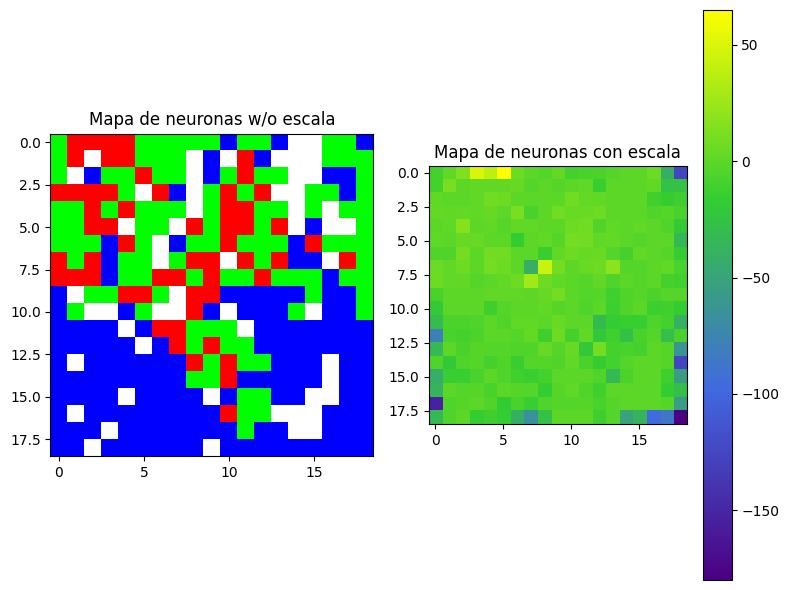

Number of blue neurons: 145
Number of red neurons: 57
Number of white neurons: 55
Number of green neurons: 104


In [56]:
#import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.colors import LinearSegmentedColormap

porcentaje = 0.8

# Inicializa un mapa de colores del tamaño del SOM con todos los valores en blanco
color_map = np.ones((19, 19, 3))

# Inicializa un mapa de clases del tamaño del SOM con todos los valores en -1
class_map = -1 * np.ones((19, 19))

# Contadores para cada neurona
counts = np.zeros((19, 19, 2), dtype=int)

# Itera sobre cada dato y su clase correspondiente
for datum, class_ in zip(data_som, target):
    # Encuentra la neurona ganadora para este dato
    winner = main_map.calculate_bmu(datum)[1]
    
    # Actualiza el contador de la clase para la neurona ganadora
    counts[int(winner[0]), int(winner[1]), int(class_)] += 1
    
    # Actualiza el mapa de clases con la clase reconocida
    class_map[winner] = class_

# Itera sobre cada neurona para determinar el color final
for i in range(19):
    for j in range(19):
        # Calcula el porcentaje de cada clase para la neurona actual
        percent_class_0 = counts[i, j, 0] / (counts[i, j, 0] + counts[i, j, 1]) if counts[i, j, 0] + counts[i, j, 1] > 0 else 0
        percent_class_1 = counts[i, j, 1] / (counts[i, j, 0] + counts[i, j, 1]) if counts[i, j, 0] + counts[i, j, 1] > 0 else 0
        
        # Asigna el color según las condiciones especificadas
        if percent_class_0 >= porcentaje:
            color_map[i, j] = [0, 0, 1]  # Azul
        elif percent_class_1 >= porcentaje:
            color_map[i, j] = [1, 0, 0]  # Rojo
        elif counts[i, j, 0] + counts[i, j, 1] == 0:
            color_map[i, j] = [1, 1, 1]  # Blanco si no ha reconocido ningún patrón
        else:
            color_map[i, j] = [0, 1, 0]  # Verde si no alcanza el 80% de ninguna clase


# Count the number of neurons of each color
num_blue = np.sum(np.all(color_map == [0, 0, 1], axis=-1))
num_red = np.sum(np.all(color_map == [1, 0, 0], axis=-1))
num_white = np.sum(np.all(color_map == [1, 1, 1], axis=-1))
num_green = np.sum(np.all(color_map == [0, 1, 0], axis=-1))

# Crea una figura con diferentes tamaños para los subplots
fig = plt.figure(figsize=(8, 6))

# Crea una leyenda para el primer gráfico
legend_elements = [Patch(facecolor='blue', edgecolor='b', label='Clase 0'),
                   Patch(facecolor='red', edgecolor='r', label='Clase 1'),
                   Patch(facecolor='green', edgecolor='g', label='Ambas clases')]
ax1 = fig.add_subplot(121)  # 121 significa "1 fila, 2 columnas, primer gráfico"
# ax1.legend(handles=legend_elements, loc='upper right')
ax1.imshow(np.rot90(color_map))
ax1.set_title('Mapa de neuronas w/o escala')

# Inicializa un mapa de neuronas con ceros
neuron_map = np.zeros((19, 19))
ganadores = np.zeros((19, 19))

# Itera sobre los datos y las clases
for datum, clss in zip(data_som, target):
    # Obtiene la neurona ganadora para el dato actual
    winner = main_map.calculate_bmu(datum)[1]
    ganadores[winner] = 1
    print(winner, clss)
    # Si la clase es 0, resta 1, si la clase es 1, suma 1
    neuron_map[winner[0], winner[1]] += 1 if clss == 1 else -1

# Normaliza el mapa de neuronas para que los valores estén entre -1 y 1
# neuron_map = neuron_map / np.max(np.abs(neuron_map))

# Define los colores de la escala como azul, verde y amarillo
cmap_colors = ["indigo", "royalblue", "limegreen", "yellow"]

# Crea el mapa de colores
cmap = LinearSegmentedColormap.from_list("mycmap", cmap_colors)

# Dibuja el mapa de calor
ax2 = fig.add_subplot(122)  # 122 significa "1 fila, 2 columnas, segundo gráfico"
im = ax2.imshow(np.rot90(neuron_map), cmap=cmap, interpolation='nearest')
ax2.set_title('Mapa de neuronas con escala')

# Muestra la barra de colores
fig.colorbar(im, ax=ax2)

# Ajusta el layout
plt.tight_layout()

# Muestra el gráfico
plt.show()

# Print the number of neurons of each color
print(f"Number of blue neurons: {num_blue}")
print(f"Number of red neurons: {num_red}")
print(f"Number of white neurons: {num_white}")
print(f"Number of green neurons: {num_green}")

In [ ]:
#GEMA.Visualization.codebook_vectors(main_map, np.array(["Not Spiled", "Spiled"]))

In [ ]:
n_neurons = 6
m_neurons = 6

som = MiniSom(n_neurons, m_neurons, data_som.shape[1], learning_rate=0.12947086423703813, random_seed=42)
som.train(data_som, num_iteration=4900, verbose=True)  # random training
print("Topological error:",som.topographic_error(data_som))

## SMOTE fonemas

In [55]:
## Smote + Tomed_links
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 5)
data_std = wf.min_max_normalization(datos_mode)

Smote_tomed=wf.smote_tomed_link(data_std,5)
print(Smote_tomed[5].value_counts())
data_balanced_dropped_smote_tomed = Smote_tomed.drop(columns = [5])
data_balanced_dropped_smote_tomed=data_balanced_dropped_smote_tomed.to_numpy()

## smote_edited_nearest_neighbor
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 5)
data_std = wf.min_max_normalization(datos_mode)

Smote_edited=wf.smote_edited_nearest_neighbor(data_std,5)
print(Smote_edited[5].value_counts())
data_balanced_dropped_smote_edited = Smote_edited.drop(columns = [5])
data_balanced_dropped_smote_edited=data_balanced_dropped_smote_edited.to_numpy()

## smote con CNN (condensed nearest neighbors)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 5)
data_std = wf.min_max_normalization(datos_mode)

Smote_cnn=wf.smote_cnn(data_std,5)
print(Smote_cnn[5].value_counts())
data_smote_cnn = Smote_cnn.drop(columns = [5])
data_smote_cnn=data_smote_cnn.to_numpy()

## smote con NCR (Neighboorhood cleaning rule)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 5)
data_std = wf.min_max_normalization(datos_mode)

Smote_ncr=wf.smote_ncr(data_std,5)
print(Smote_ncr[5].value_counts())
data_smote_ncr = Smote_ncr.drop(columns = [5])
data_smote_ncr=data_smote_ncr.to_numpy()

## smote con OSD (One sided selection)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 5)
data_std = wf.min_max_normalization(datos_mode)

Smote_oss=wf.smote_osd(data_std,5)
print(Smote_oss[5].value_counts())
data_smote_oss = Smote_oss.drop(columns = [5])
data_smote_oss=data_smote_oss.to_numpy()

Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  6
1.0    3818
0.0    3773
Name: 5, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  6
0.0    3818
1.0    3319
Name: 5, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  6
1.0    3873
0.0    3813
Name: 5, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  6
0.0    3818
1.0    3655
Name: 5, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  6
1.0    3871
0.0    3788
Name: 5, dtype: int64


## Clasificación fonemas con GEMA y SMOTE

In [ ]:
main_classification_smoted_tomed = GEMA.Classification(main_map, data_balanced_dropped_smote_tomed)
print("Smote+tommed quantification:",main_classification_smoted_tomed.quantization_error)
print("Smote+tommed topological:",main_classification_smoted_tomed.topological_error)

main_classification_smoted_edited= GEMA.Classification(main_map, data_balanced_dropped_smote_edited)
print("Smote+edited quantification:",main_classification_smoted_edited.quantization_error)
print("Smote+edited topological:",main_classification_smoted_edited.topological_error)

main_classification_smoted_cnn= GEMA.Classification(main_map, data_smote_cnn)
print("Smote+cnn quantification:",main_classification_smoted_cnn.quantization_error)
print("Smote+cnn topological:",main_classification_smoted_cnn.topological_error)

main_classification_smoted_ncr= GEMA.Classification(main_map, data_smote_ncr)
print("Smote+ncr quantification:",main_classification_smoted_ncr.quantization_error)
print("Smote+ncr topological:",main_classification_smoted_ncr.topological_error)

main_classification_smoted_oss= GEMA.Classification(main_map, data_smote_oss)
print("Smote+oss quantification:",main_classification_smoted_oss.quantization_error)
print("Smote+oss topological:",main_classification_smoted_oss.topological_error)

## Clasificación fonemas con Minisom y SMOTE

In [ ]:
print("Smote+tommed")
print(som.quantization_error(data_balanced_dropped_smote_tomed), som.topographic_error(data_balanced_dropped_smote_tomed))
print("Smote+linked")
print(som.quantization_error(data_balanced_dropped_smote_edited), som.topographic_error(data_balanced_dropped_smote_edited))
print("Smote+cnn")
print(som.quantization_error(data_smote_cnn), som.topographic_error(data_smote_cnn))
print("Smote+ncr")
print(som.quantization_error(data_smote_ncr), som.topographic_error(data_smote_ncr))
print("Smote+oss")
print(som.quantization_error(data_smote_oss), som.topographic_error(data_smote_oss))

## ADASYN fonemas

In [60]:
## ADASYN + Tomed_links
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 5)
data_std = wf.min_max_normalization(datos_mode)

adasyn_tomek=wf.adasyn_tomek(data_std,5)
print(adasyn_tomek[5].value_counts())
data_adasyn_tomek = adasyn_tomek.drop(columns = [5])
data_adasyn_tomek=data_adasyn_tomek.to_numpy()

## ADASYN + ENN
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 5)
data_std = wf.min_max_normalization(datos_mode)

adasyn_edited=wf.adasyn_enn(data_std,5)
print(adasyn_edited[5].value_counts())
data_adasyn_edited = adasyn_edited.drop(columns = [5])
data_adasyn_edited=data_adasyn_edited.to_numpy()

## ADASYN con CNN (condensed nearest neighbors)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 5)
data_std = wf.min_max_normalization(datos_mode)

adasyn_cnn=wf.adasyn_cnn_fon(data_std,5)
print(adasyn_cnn[5].value_counts())
data_adasyn_cnn = adasyn_cnn.drop(columns = [5])
data_adasyn_cnn=data_adasyn_cnn.to_numpy()

## ADASYN con NCR (Neighboorhood cleaning rule)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 5)
data_std = wf.min_max_normalization(datos_mode)

adasyn_ncr=wf.adasyn_ncr(data_std,5)
print(adasyn_ncr[5].value_counts())
data_adasyn_ncr = adasyn_ncr.drop(columns = [5])
data_adasyn_ncr=data_adasyn_ncr.to_numpy()

## ADASYN con OSD (One sided selection)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 5)
data_std = wf.min_max_normalization(datos_mode)

adasyn_oss=wf.adasyn_oss(data_std,5)
print(adasyn_oss[5].value_counts())
data_adasyn_oss = adasyn_oss.drop(columns = [5])
data_adasyn_oss=data_adasyn_oss.to_numpy()

Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  6
0.0    3782
1.0    3744
Name: 5, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  6
1.0    3780
0.0    3542
Name: 5, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  6
1.0    4605
0.0    4386
Name: 5, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  6
1.0    3709
0.0    3232
Name: 5, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  6
0.0    3782
1.0    3780
Name: 5, dtype: int64


## Clasificación fonemas con GEMA y ADASYN

In [ ]:
main_classification_adasyn_tomek = GEMA.Classification(main_map, data_adasyn_tomek)
print("adasyn+tommed quantification:",main_classification_adasyn_tomek.quantization_error)
print("adasyn+tommed topological:",main_classification_adasyn_tomek.topological_error)

main_classification_adasyn_edited= GEMA.Classification(main_map, data_adasyn_edited)
print("adasyn+edited quantification:",main_classification_adasyn_edited.quantization_error)
print("adasyn+edited topological:",main_classification_adasyn_edited.topological_error)

main_classification_smoted_cnn= GEMA.Classification(main_map, data_smote_cnn)
print("adasyn+cnn quantification:",main_classification_smoted_cnn.quantization_error)
print("adasyn+cnn topological:",main_classification_smoted_cnn.topological_error)

main_classification_smoted_ncr= GEMA.Classification(main_map, data_smote_ncr)
print("adasyn+ncr quantification:",main_classification_smoted_ncr.quantization_error)
print("adasyn+ncr topological:",main_classification_smoted_ncr.topological_error)

main_classification_smoted_oss= GEMA.Classification(main_map, data_smote_oss)
print("adasyn+oss quantification:",main_classification_smoted_oss.quantization_error)
print("adasyn+oss topological:",main_classification_smoted_oss.topological_error)

## Clasificación fonemas con Minisom y ADASYN

In [ ]:
print("adasyn+tommed")
print(som.quantization_error(data_adasyn_tomek), som.topographic_error(data_adasyn_tomek))
print("adasyn+linked")
print(som.quantization_error(data_adasyn_edited), som.topographic_error(data_adasyn_edited))
print("adasyn+cnn")
print(som.quantization_error(data_adasyn_cnn), som.topographic_error(data_adasyn_cnn))
print("adasyn+ncr")
print(som.quantization_error(data_adasyn_ncr), som.topographic_error(data_adasyn_ncr))
print("adasyn+oss")
print(som.quantization_error(data_adasyn_oss), som.topographic_error(data_adasyn_oss))

## Borderline SMOTE fonemas

In [ ]:
## BSMOTE + Tomed_links
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 5)
data_std = wf.min_max_normalization(datos_mode)

bsmote_tomek=wf.BSMOTE_tomek(data_std,5)
print(bsmote_tomek[5].value_counts())
data_bsmote_tomek = bsmote_tomek.drop(columns = [5])
data_bsmote_tomek=data_bsmote_tomek.to_numpy()

## BSMOTE + ENN
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 5)
data_std = wf.min_max_normalization(datos_mode)

bsmote_edited=wf.BSMOTE_enn(data_std,5)
print(bsmote_edited[5].value_counts())
data_bsmote_edited = bsmote_edited.drop(columns = [5])
data_bsmote_edited=data_bsmote_edited.to_numpy()

## BSMOTE con CNN (condensed nearest neighbors)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 5)
data_std = wf.min_max_normalization(datos_mode)

bsmote_cnn=wf.BSMOTE_cnn(data_std,5)
print(bsmote_cnn[5].value_counts())
data_bsmote_cnn = bsmote_cnn.drop(columns = [5])
data_bsmote_cnn=data_bsmote_cnn.to_numpy()

## BSMOTE con NCR (Neighboorhood cleaning rule)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 5)
data_std = wf.min_max_normalization(datos_mode)

bsmote_ncr=wf.BSMOTE_ncr(data_std,5)
print(bsmote_ncr[5].value_counts())
data_bsmote_ncr = bsmote_ncr.drop(columns = [5])
data_bsmote_ncr=data_bsmote_ncr.to_numpy()

## BSMOTE con OSD (One sided selection)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 5)
data_std = wf.min_max_normalization(datos_mode)

bsmote_oss=wf.BSMOTE_oss(data_std,5)
print(bsmote_oss[5].value_counts())
data_bsmote_oss = bsmote_oss.drop(columns = [5])
data_bsmote_oss=data_bsmote_oss.to_numpy()

## Clasificación fonemas con GEMA y Borderline SMOTE

In [ ]:
main_classification_bsmote_tomek = GEMA.Classification(main_map, data_bsmote_tomek)
print("bsmote+tommed quantification:",main_classification_bsmote_tomek.quantization_error)
print("bsmote+tommed topological:",main_classification_bsmote_tomek.topological_error)

main_classification_bsmote_edited= GEMA.Classification(main_map, data_bsmote_edited)
print("bsmote+edited quantification:",main_classification_bsmote_edited.quantization_error)
print("bsmote+edited topological:",main_classification_bsmote_edited.topological_error)

main_classification_bsmote_cnn= GEMA.Classification(main_map, data_bsmote_cnn)
print("bsmote+cnn quantification:",main_classification_bsmote_cnn.quantization_error)
print("bsmote+cnn topological:",main_classification_bsmote_cnn.topological_error)

main_classification_bsmote_ncr= GEMA.Classification(main_map, data_bsmote_ncr)
print("bsmote+ncr quantification:",main_classification_bsmote_ncr.quantization_error)
print("bsmote+ncr topological:",main_classification_bsmote_ncr.topological_error)

main_classification_bsmote_oss= GEMA.Classification(main_map, data_bsmote_oss)
print("bsmote+oss quantification:",main_classification_bsmote_oss.quantization_error)
print("bsmote+oss topological:",main_classification_bsmote_oss.topological_error)

## Clasificación fonemas con Minisom y Borderline SMOTE

In [ ]:
print("bsmote+tommed")
print(som.quantization_error(data_bsmote_tomek), som.topographic_error(data_bsmote_tomek))
print("bsmote+linked")
print(som.quantization_error(data_bsmote_edited), som.topographic_error(data_bsmote_edited))
print("bsmote+cnn")
print(som.quantization_error(data_bsmote_cnn), som.topographic_error(data_bsmote_cnn))
print("bsmote+ncr")
print(som.quantization_error(data_bsmote_ncr), som.topographic_error(data_bsmote_ncr))
print("bsmote+oss")
print(som.quantization_error(data_bsmote_oss), som.topographic_error(data_bsmote_oss))

## SVM SMOTE fonemas

In [ ]:
## SVMSMOTE + Tomed_links
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 5)
data_std = wf.min_max_normalization(datos_mode)

svmsmote_tomek=wf.SVMSMOTE_tomek(data_std,5)
print(svmsmote_tomek[5].value_counts())
data_svmsmote_tomek = svmsmote_tomek.drop(columns = [5])
data_svmsmote_tomek=data_svmsmote_tomek.to_numpy()

## SVMSMOTE + ENN
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 5)
data_std = wf.min_max_normalization(datos_mode)

svmsmote_edited=wf.SVMSMOTE_enn(data_std,5)
print(svmsmote_edited[5].value_counts())
data_svmsmote_edited = svmsmote_edited.drop(columns = [5])
data_svmsmote_edited=data_svmsmote_edited.to_numpy()

## SVMSMOTE con CNN (condensed nearest neighbors)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 5)
data_std = wf.min_max_normalization(datos_mode)

svmsmote_cnn=wf.SVMSMOTE_cnn(data_std,5)
print(svmsmote_cnn[5].value_counts())
data_svmsmote_cnn = svmsmote_cnn.drop(columns = [5])
data_svmsmote_cnn=data_svmsmote_cnn.to_numpy()

## SVMSMOTE con NCR (Neighboorhood cleaning rule)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 5)
data_std = wf.min_max_normalization(datos_mode)

svmsmote_ncr=wf.SVMSMOTE_ncr(data_std,5)
print(svmsmote_ncr[5].value_counts())
data_svmsmote_ncr = svmsmote_ncr.drop(columns = [5])
data_svmsmote_ncr=data_svmsmote_ncr.to_numpy()

## SVMSMOTE con OSD (One sided selection)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 5)
data_std = wf.min_max_normalization(datos_mode)

svmsmote_oss=wf.SVMSMOTE_oss(data_std,5)
print(svmsmote_oss[5].value_counts())
data_svmsmote_oss = svmsmote_oss.drop(columns = [5])
data_svmsmote_oss=data_svmsmote_oss.to_numpy()

## Clasificación fonemas con GEMA y SVM SMOTE

In [ ]:
main_classification_svmsmote_tomek = GEMA.Classification(main_map, data_svmsmote_tomek)
print("svmsmote+tommed quantification:",main_classification_svmsmote_tomek.quantization_error)
print("svmsmote+tommed topological:",main_classification_svmsmote_tomek.topological_error)

main_classification_svmsmote_edited= GEMA.Classification(main_map, data_svmsmote_edited)
print("svmsmote+edited quantification:",main_classification_svmsmote_edited.quantization_error)
print("svmsmote+edited topological:",main_classification_svmsmote_edited.topological_error)

main_classification_svmsmote_cnn= GEMA.Classification(main_map, data_svmsmote_cnn)
print("svmsmote+cnn quantification:",main_classification_svmsmote_cnn.quantization_error)
print("svmsmote+cnn topological:",main_classification_svmsmote_cnn.topological_error)

main_classification_svmsmote_ncr= GEMA.Classification(main_map, data_svmsmote_ncr)
print("svmsmote+ncr quantification:",main_classification_svmsmote_ncr.quantization_error)
print("svmsmote+ncr topological:",main_classification_svmsmote_ncr.topological_error)

main_classification_svmsmote_oss= GEMA.Classification(main_map, data_svmsmote_oss)
print("svmsmote+oss quantification:",main_classification_svmsmote_oss.quantization_error)
print("svmsmote+oss topological:",main_classification_svmsmote_oss.topological_error)

## Clasificación fonemas con Minisom y SVM SMOTE

In [ ]:
print("svmsmote+tommed")
print(som.quantization_error(data_svmsmote_tomek), som.topographic_error(data_svmsmote_tomek))
print("svmsmote+linked")
print(som.quantization_error(data_svmsmote_edited), som.topographic_error(data_svmsmote_edited))
print("svmsmote+cnn")
print(som.quantization_error(data_svmsmote_cnn), som.topographic_error(data_svmsmote_cnn))
print("svmsmote+ncr")
print(som.quantization_error(data_svmsmote_ncr), som.topographic_error(data_svmsmote_ncr))
print("svmsmote+oss")
print(som.quantization_error(data_svmsmote_oss), som.topographic_error(data_svmsmote_oss))

## Kmeans SMOTE fonemas

In [58]:
## KMSSMOTE + Tomed_links
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 5)
data_std = wf.min_max_normalization(datos_mode)

kmssmote_tomek=wf.KMSSMOTE_tomek(data_std,5)
print(kmssmote_tomek[5].value_counts())
data_kmssmote_tomek = kmssmote_tomek.drop(columns = [5])
data_kmssmote_tomek=data_kmssmote_tomek.to_numpy()

## KMSSMOTE + ENN
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 5)
data_std = wf.min_max_normalization(datos_mode)

kmssmote_edited=wf.KMSSMOTE_enn(data_std,5)
print(kmssmote_edited[5].value_counts())
data_kmssmote_edited = kmssmote_edited.drop(columns = [5])
data_kmssmote_edited=data_kmssmote_edited.to_numpy()

## KMSSMOTE con CNN (condensed nearest neighbors)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 5)
data_std = wf.min_max_normalization(datos_mode)

kmssmote_cnn=wf.KMSSMOTE_cnn(data_std,5)
print(kmssmote_cnn[5].value_counts())
data_kmssmote_cnn = kmssmote_cnn.drop(columns = [5])
data_kmssmote_cnn=data_kmssmote_cnn.to_numpy()

## KMSSMOTE con NCR (Neighboorhood cleaning rule)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 5)
data_std = wf.min_max_normalization(datos_mode)

kmssmote_ncr=wf.KMSSMOTE_ncr(data_std,5)
print(kmssmote_ncr[5].value_counts())
data_kmssmote_ncr = kmssmote_ncr.drop(columns = [5])
data_kmssmote_ncr=data_kmssmote_ncr.to_numpy()

## KMSSMOTE con OSD (One sided selection)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 5)
data_std = wf.min_max_normalization(datos_mode)

kmssmote_oss=wf.KMSSMOTE_oss(data_std,5)
print(kmssmote_oss[5].value_counts())
data_kmssmote_oss = kmssmote_oss.drop(columns = [5])
data_kmssmote_oss=data_kmssmote_oss.to_numpy()

Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  6
0.0    3818
1.0    3735
Name: 5, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  6
0.0    3818
1.0    3552
Name: 5, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  6
0.0    3869
1.0    3844
Name: 5, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  6
1.0    3844
0.0    3492
Name: 5, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  6
0.0    3869
1.0    3844
Name: 5, dtype: int64


## Clasificación fonemas con GEMA y Kmeans SMOTE

In [ ]:
main_classification_kmssmote_tomek = GEMA.Classification(main_map, data_kmssmote_tomek)
print("svmsmote+tommed quantification:",main_classification_kmssmote_tomek.quantization_error)
print("svmsmote+tommed topological:",main_classification_kmssmote_tomek.topological_error)

main_classification_kmssmote_edited= GEMA.Classification(main_map, data_kmssmote_edited)
print("svmsmote+edited quantification:",main_classification_kmssmote_edited.quantization_error)
print("svmsmote+edited topological:",main_classification_kmssmote_edited.topological_error)

main_classification_kmssmote_cnn= GEMA.Classification(main_map, data_kmssmote_cnn)
print("svmsmote+cnn quantification:",main_classification_kmssmote_cnn.quantization_error)
print("svmsmote+cnn topological:",main_classification_kmssmote_cnn.topological_error)

main_classification_kmssmote_ncr= GEMA.Classification(main_map, data_kmssmote_ncr)
print("svmsmote+ncr quantification:",main_classification_kmssmote_ncr.quantization_error)
print("svmsmote+ncr topological:",main_classification_kmssmote_ncr.topological_error)

main_classification_kmssmote_oss= GEMA.Classification(main_map, data_kmssmote_oss)
print("svmsmote+oss quantification:",main_classification_kmssmote_oss.quantization_error)
print("svmsmote+oss topological:",main_classification_kmssmote_oss.topological_error)

## Clasificación fonemas con Minisom y Kmeans SMOTE

In [ ]:
print("kmssmote+tommed")
print(som.quantization_error(data_kmssmote_tomek), som.topographic_error(data_kmssmote_tomek))
print("kmssmote+linked")
print(som.quantization_error(data_kmssmote_edited), som.topographic_error(data_kmssmote_edited))
print("kmssmote+cnn")
print(som.quantization_error(data_kmssmote_cnn), som.topographic_error(data_kmssmote_cnn))
print("kmssmote+ncr")
print(som.quantization_error(data_kmssmote_ncr), som.topographic_error(data_kmssmote_ncr))
print("kmssmote+oss")
print(som.quantization_error(data_kmssmote_oss), som.topographic_error(data_kmssmote_oss))

## Importar dataset de fraudes de créditos bancarios

In [62]:
## Importar dataset
url = '../../PROYECTO SOM DESBALANCEADO/DATASET/creditcard.csv'
missing_values = [' ', 'NaN', 'na', 'Na', '-', '--', 'n/a', '?']
columns = ['class']
data = pd.read_csv(url, na_values = missing_values, header=None)
data[3] = data[3].replace({1: 0, 2: 1})
print(data[30].value_counts())

0        251650
0         32665
1           390
1           102
Class         1
Name: 30, dtype: int64


In [63]:
data = data.iloc[1:]
data

,0,1,2,3,4,5,6,7,8,9,...,21,22,23,24,25,26,27,28,29,30
1,0,-1.3598071336738,-0.0727811733098497,2.53634673796914,1.37815522427443,-0.338320769942518,0.462387777762292,0.239598554061257,0.0986979012610507,0.363786969611213,...,-0.018306777944153,0.277837575558899,-0.110473910188767,0.0669280749146731,0.128539358273528,-0.189114843888824,0.133558376740387,-0.0210530534538215,149.62,0
2,0,1.19185711131486,0.26615071205963,0.16648011335321,0.448154078460911,0.0600176492822243,-0.0823608088155687,-0.0788029833323113,0.0851016549148104,-0.255425128109186,...,-0.225775248033138,-0.638671952771851,0.101288021253234,-0.339846475529127,0.167170404418143,0.125894532368176,-0.00898309914322813,0.0147241691924927,2.69,0
3,1,-1.35835406159823,-1.34016307473609,1.77320934263119,0.379779593034328,-0.503198133318193,1.80049938079263,0.791460956450422,0.247675786588991,-1.51465432260583,...,0.247998153469754,0.771679401917229,0.909412262347719,-0.689280956490685,-0.327641833735251,-0.139096571514147,-0.0553527940384261,-0.0597518405929204,378.66,0
4,1,-0.966271711572087,-0.185226008082898,1.79299333957872,-0.863291275036453,-0.0103088796030823,1.24720316752486,0.23760893977178,0.377435874652262,-1.38702406270197,...,-0.108300452035545,0.00527359678253453,-0.190320518742841,-1.17557533186321,0.647376034602038,-0.221928844458407,0.0627228487293033,0.0614576285006353,123.5,0
5,2,-1.15823309349523,0.877736754848451,1.548717846511,0.403033933955121,-0.407193377311653,0.0959214624684256,0.592940745385545,-0.270532677192282,0.817739308235294,...,-0.00943069713232919,0.79827849458971,-0.137458079619063,0.141266983824769,-0.206009587619756,0.502292224181569,0.219422229513348,0.215153147499206,69.99,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
284803,172786,-11.881118,10.071785,-9.834783,-2.066656,-5.364473,-2.606837,-4.918215,7.305334,1.914428,...,0.213454,0.111864,1.01448,-0.509348,1.436807,0.250034,0.943651,0.823731,0.77,0
284804,172787,-0.732789,-0.05508,2.03503,-0.738589,0.868229,1.058415,0.02433,0.294869,0.5848,...,0.214205,0.924384,0.012463,-1.016226,-0.606624,-0.395255,0.068472,-0.053527,24.79,0
284805,172788,1.919565,-0.301254,-3.24964,-0.557828,2.630515,3.03126,-0.296827,0.708417,0.432454,...,0.232045,0.578229,-0.037501,0.640134,0.265745,-0.087371,0.004455,-0.026561,67.88,0
284806,172788,-0.24044,0.530483,0.70251,0.689799,-0.377961,0.623708,-0.68618,0.679145,0.392087,...,0.265245,0.800049,-0.163298,0.123205,-0.569159,0.546668,0.108821,0.104533,10.0,0


In [64]:
data = data.astype(float)
# Contar cuántas filas tienen un valor de 0 en la columna "columna_nombre"
filas_con_cero = data[data[30] == 0]

# Verificar si hay suficientes filas con 0 antes de eliminar
if len(filas_con_cero) >= 274000:
    # Eliminar las primeras 180,000 filas con 0
    data = data.drop(filas_con_cero.index[:274000])
datos_mode = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(datos_mode, 30)
datos_mode[30].value_counts()

Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  31


0.0    10315
1.0      492
Name: 30, dtype: int64

In [65]:
datos_mode=datos_mode.drop(columns = [30])
data_std = wf.min_max_normalization(datos_mode)
target = data[30].values
label_names={0:'No fraude', 1:'Fraude'}
data_som=data_std.to_numpy()

## Entrenamiento GEMA fraudes créditos

In [66]:
main_map = GEMA.Map(data_som, 
                    20, 
                    38386, 
                    initial_lr=0.01819940721573887, 
                    initial_neighbourhood = 0,
                    distance = 'euclidean',
                    use_decay= False,
                    presentation= 'random',
                    weights = 'random')

main_classification = GEMA.Classification(main_map, data_som)
print("quantification error:",main_classification.quantization_error)
print("Topological_error:",main_classification.topological_error)

TRAINING...


  0%|          | 0/38386 [00:00<?, ?it/s]

FINISHED.


  0%|          | 0/10807 [00:00<?, ?it/s]

quantification error: 0.18786832330896644
Topological_error: 0.10807809752937911


## Entrenamiento SOM Minisom fraudes créditos

In [ ]:
n_neurons = 20
m_neurons = 20

som = MiniSom(n_neurons, m_neurons, data_som.shape[1], learning_rate=0.005, random_seed=42)
som.train(data_som, num_iteration=38386, verbose=True)  # random training
print("Topological error:",som.topographic_error(data_som))

## SMOTE fraudes créditos

In [68]:
## Smote + Tomed_links
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 30)
data_std = wf.min_max_normalization(datos_mode)

Smote_tomed=wf.smote_tomed_link(data_std,30)
print(Smote_tomed[30].value_counts())
data_balanced_dropped_smote_tomed = Smote_tomed.drop(columns = [30])
data_balanced_dropped_smote_tomed=data_balanced_dropped_smote_tomed.to_numpy()

## smote_edited_nearest_neighbor
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 30)
data_std = wf.min_max_normalization(datos_mode)

Smote_edited=wf.smote_edited_nearest_neighbor(data_std,30)
print(Smote_edited[30].value_counts())
data_balanced_dropped_smote_edited = Smote_edited.drop(columns = [30])
data_balanced_dropped_smote_edited=data_balanced_dropped_smote_edited.to_numpy()

## smote con CNN (condensed nearest neighbors)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 30)
data_std = wf.min_max_normalization(datos_mode)

Smote_cnn=wf.smote_cnn(data_std,30)
print(Smote_cnn[30].value_counts())
data_smote_cnn = Smote_cnn.drop(columns = [30])
data_smote_cnn=data_smote_cnn.to_numpy()

## smote con NCR (Neighboorhood cleaning rule)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 30)
data_std = wf.min_max_normalization(datos_mode)

Smote_ncr=wf.smote_ncr(data_std,30)
print(Smote_ncr[30].value_counts())
data_smote_ncr = Smote_ncr.drop(columns = [30])
data_smote_ncr=data_smote_ncr.to_numpy()

## smote con OSD (One sided selection)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 30)
data_std = wf.min_max_normalization(datos_mode)

Smote_oss=wf.smote_osd(data_std,30)
print(Smote_oss[30].value_counts())
data_smote_oss = Smote_oss.drop(columns = [30])
data_smote_oss=data_smote_oss.to_numpy()

Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  31
1.0    10315
0.0    10315
Name: 30, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  31
0.0    10315
1.0    10314
Name: 30, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  31
0.0    10312
1.0    10310
Name: 30, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  31
1.0    10315
0.0    10315
Name: 30, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  31
0.0    10312
1.0    10310
Name: 30, dtype: int64


## Clasificación GEMA SMOTE fraudes

In [ ]:
main_classification_smoted_tomed = GEMA.Classification(main_map, data_balanced_dropped_smote_tomed)
print("Smote+tommed quantification:",main_classification_smoted_tomed.quantization_error)
print("Smote+tommed topological:",main_classification_smoted_tomed.topological_error)

main_classification_smoted_edited= GEMA.Classification(main_map, data_balanced_dropped_smote_edited)
print("Smote+edited quantification:",main_classification_smoted_edited.quantization_error)
print("Smote+edited topological:",main_classification_smoted_edited.topological_error)

main_classification_smoted_cnn= GEMA.Classification(main_map, data_smote_cnn)
print("Smote+cnn quantification:",main_classification_smoted_cnn.quantization_error)
print("Smote+cnn topological:",main_classification_smoted_cnn.topological_error)

main_classification_smoted_ncr= GEMA.Classification(main_map, data_smote_ncr)
print("Smote+ncr quantification:",main_classification_smoted_ncr.quantization_error)
print("Smote+ncr topological:",main_classification_smoted_ncr.topological_error)

main_classification_smoted_oss= GEMA.Classification(main_map, data_smote_oss)
print("Smote+oss quantification:",main_classification_smoted_oss.quantization_error)
print("Smote+oss topological:",main_classification_smoted_oss.topological_error)

## Clasificación Minisom SMOTE fraudes

In [ ]:
print("Smote+tommed")
print(som.quantization_error(data_balanced_dropped_smote_tomed), som.topographic_error(data_balanced_dropped_smote_tomed))
print("Smote+linked")
print(som.quantization_error(data_balanced_dropped_smote_edited), som.topographic_error(data_balanced_dropped_smote_edited))
print("Smote+cnn")
print(som.quantization_error(data_smote_cnn), som.topographic_error(data_smote_cnn))
print("Smote+ncr")
print(som.quantization_error(data_smote_ncr), som.topographic_error(data_smote_ncr))
print("Smote+oss")
print(som.quantization_error(data_smote_oss), som.topographic_error(data_smote_oss))

## ADASYN fraudes

In [ ]:
## ADASYN + Tomed_links
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 30)
data_std = wf.min_max_normalization(datos_mode)

adasyn_tomek=wf.adasyn_tomek(data_std,30)
print(adasyn_tomek[30].value_counts())
data_adasyn_tomek = adasyn_tomek.drop(columns = [30])
data_adasyn_tomek=data_adasyn_tomek.to_numpy()

## ADASYN + ENN
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 30)
data_std = wf.min_max_normalization(datos_mode)

adasyn_edited=wf.adasyn_enn(data_std,30)
print(adasyn_edited[30].value_counts())
data_adasyn_edited = adasyn_edited.drop(columns = [30])
data_adasyn_edited=data_adasyn_edited.to_numpy()

## ADASYN con CNN (condensed nearest neighbors)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 30)
data_std = wf.min_max_normalization(datos_mode)

adasyn_cnn=wf.adasyn_cnn_fon(data_std,30)
print(adasyn_cnn[30].value_counts())
data_adasyn_cnn = adasyn_cnn.drop(columns = [30])
data_adasyn_cnn=data_adasyn_cnn.to_numpy()

## ADASYN con NCR (Neighboorhood cleaning rule)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 30)
data_std = wf.min_max_normalization(datos_mode)

adasyn_ncr=wf.adasyn_ncr(data_std,30)
print(adasyn_ncr[30].value_counts())
data_adasyn_ncr = adasyn_ncr.drop(columns = [30])
data_adasyn_ncr=data_adasyn_ncr.to_numpy()

## ADASYN con OSD (One sided selection)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 30)
data_std = wf.min_max_normalization(datos_mode)

adasyn_oss=wf.adasyn_oss(data_std,30)
print(adasyn_oss[30].value_counts())
data_adasyn_oss = adasyn_oss.drop(columns = [30])
data_adasyn_oss=data_adasyn_oss.to_numpy()

## Clasificación GEMA ADASYN fraudes

In [ ]:
main_classification_adasyn_tomek = GEMA.Classification(main_map, data_adasyn_tomek)
print("adasyn+tommed quantification:",main_classification_adasyn_tomek.quantization_error)
print("adasyn+tommed topological:",main_classification_adasyn_tomek.topological_error)

main_classification_adasyn_edited= GEMA.Classification(main_map, data_adasyn_edited)
print("adasyn+edited quantification:",main_classification_adasyn_edited.quantization_error)
print("adasyn+edited topological:",main_classification_adasyn_edited.topological_error)

main_classification_smoted_cnn= GEMA.Classification(main_map, data_adasyn_cnn)
print("adasyn+cnn quantification:",main_classification_smoted_cnn.quantization_error)
print("adasyn+cnn topological:",main_classification_smoted_cnn.topological_error)

main_classification_smoted_ncr= GEMA.Classification(main_map, data_adasyn_ncr)
print("adasyn+ncr quantification:",main_classification_smoted_ncr.quantization_error)
print("adasyn+ncr topological:",main_classification_smoted_ncr.topological_error)

main_classification_smoted_oss= GEMA.Classification(main_map, data_smote_oss)
print("adasyn+oss quantification:",main_classification_smoted_oss.quantization_error)
print("adasyn+oss topological:",main_classification_smoted_oss.topological_error)

## Clasificación Minisom ADASYN fraudes

In [ ]:
print("adasyn+tommed")
print(som.quantization_error(data_adasyn_tomek), som.topographic_error(data_adasyn_tomek))
print("adasyn+linked")
print(som.quantization_error(data_adasyn_edited), som.topographic_error(data_adasyn_edited))
print("adasyn+cnn")
print(som.quantization_error(data_adasyn_cnn), som.topographic_error(data_adasyn_cnn))
print("adasyn+ncr")
print(som.quantization_error(data_adasyn_ncr), som.topographic_error(data_adasyn_ncr))
print("adasyn+oss")
print(som.quantization_error(data_adasyn_oss), som.topographic_error(data_adasyn_oss))

## Borderline SMOTE fraudes

In [ ]:
## BSMOTE + Tomed_links
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 30)
data_std = wf.min_max_normalization(datos_mode)

bsmote_tomek=wf.BSMOTE_tomek(data_std,30)
print(bsmote_tomek[30].value_counts())
data_bsmote_tomek = bsmote_tomek.drop(columns = [30])
data_bsmote_tomek=data_bsmote_tomek.to_numpy()

## BSMOTE + ENN
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 30)
data_std = wf.min_max_normalization(datos_mode)

bsmote_edited=wf.BSMOTE_enn(data_std,30)
print(bsmote_edited[30].value_counts())
data_bsmote_edited = bsmote_edited.drop(columns = [30])
data_bsmote_edited=data_bsmote_edited.to_numpy()

## BSMOTE con CNN (condensed nearest neighbors)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 30)
data_std = wf.min_max_normalization(datos_mode)

bsmote_cnn=wf.BSMOTE_cnn(data_std,30)
print(bsmote_cnn[30].value_counts())
data_bsmote_cnn = bsmote_cnn.drop(columns = [30])
data_bsmote_cnn=data_bsmote_cnn.to_numpy()

## BSMOTE con NCR (Neighboorhood cleaning rule)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 30)
data_std = wf.min_max_normalization(datos_mode)

bsmote_ncr=wf.BSMOTE_ncr(data_std,30)
print(bsmote_ncr[30].value_counts())
data_bsmote_ncr = bsmote_ncr.drop(columns = [30])
data_bsmote_ncr=data_bsmote_ncr.to_numpy()

## BSMOTE con OSD (One sided selection)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 30)
data_std = wf.min_max_normalization(datos_mode)

bsmote_oss=wf.BSMOTE_oss(data_std,30)
print(bsmote_oss[30].value_counts())
data_bsmote_oss = bsmote_oss.drop(columns = [30])
data_bsmote_oss=data_bsmote_oss.to_numpy()

## Clasificación GEMA BSMOTE Fraudes

In [ ]:
main_classification_bsmote_tomek = GEMA.Classification(main_map, data_bsmote_tomek)
print("bsmote+tommed quantification:",main_classification_bsmote_tomek.quantization_error)
print("bsmote+tommed topological:",main_classification_bsmote_tomek.topological_error)

main_classification_bsmote_edited= GEMA.Classification(main_map, data_bsmote_edited)
print("bsmote+edited quantification:",main_classification_bsmote_edited.quantization_error)
print("bsmote+edited topological:",main_classification_bsmote_edited.topological_error)

main_classification_bsmote_cnn= GEMA.Classification(main_map, data_bsmote_cnn)
print("bsmote+cnn quantification:",main_classification_bsmote_cnn.quantization_error)
print("bsmote+cnn topological:",main_classification_bsmote_cnn.topological_error)

main_classification_bsmote_ncr= GEMA.Classification(main_map, data_bsmote_ncr)
print("bsmote+ncr quantification:",main_classification_bsmote_ncr.quantization_error)
print("bsmote+ncr topological:",main_classification_bsmote_ncr.topological_error)

main_classification_bsmote_oss= GEMA.Classification(main_map, data_bsmote_oss)
print("bsmote+oss quantification:",main_classification_bsmote_oss.quantization_error)
print("bsmote+oss topological:",main_classification_bsmote_oss.topological_error)

## Clasificación Minisom BSMOTE Fraudes

In [ ]:
print("bsmote+tommed")
print(som.quantization_error(data_bsmote_tomek), som.topographic_error(data_bsmote_tomek))
print("bsmote+linked")
print(som.quantization_error(data_bsmote_edited), som.topographic_error(data_bsmote_edited))
print("bsmote+cnn")
print(som.quantization_error(data_bsmote_cnn), som.topographic_error(data_bsmote_cnn))
print("bsmote+ncr")
print(som.quantization_error(data_bsmote_ncr), som.topographic_error(data_bsmote_ncr))
print("bsmote+oss")
print(som.quantization_error(data_bsmote_oss), som.topographic_error(data_bsmote_oss))

## SVM SMOTE fraudes

In [71]:
## SVMSMOTE + Tomed_links
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 30)
data_std = wf.min_max_normalization(datos_mode)

svmsmote_tomek=wf.SVMSMOTE_tomek(data_std,30)
print(svmsmote_tomek[30].value_counts())
data_svmsmote_tomek = svmsmote_tomek.drop(columns = [30])
data_svmsmote_tomek=data_svmsmote_tomek.to_numpy()

## SVMSMOTE + ENN
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 30)
data_std = wf.min_max_normalization(datos_mode)

svmsmote_edited=wf.SVMSMOTE_enn(data_std,30)
print(svmsmote_edited[30].value_counts())
data_svmsmote_edited = svmsmote_edited.drop(columns = [30])
data_svmsmote_edited=data_svmsmote_edited.to_numpy()

## SVMSMOTE con CNN (condensed nearest neighbors)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 30)
data_std = wf.min_max_normalization(datos_mode)

svmsmote_cnn=wf.SVMSMOTE_cnn(data_std,30)
print(svmsmote_cnn[30].value_counts())
data_svmsmote_cnn = svmsmote_cnn.drop(columns = [30])
data_svmsmote_cnn=data_svmsmote_cnn.to_numpy()

## SVMSMOTE con NCR (Neighboorhood cleaning rule)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 30)
data_std = wf.min_max_normalization(datos_mode)

svmsmote_ncr=wf.SVMSMOTE_ncr(data_std,30)
print(svmsmote_ncr[30].value_counts())
data_svmsmote_ncr = svmsmote_ncr.drop(columns = [30])
data_svmsmote_ncr=data_svmsmote_ncr.to_numpy()

## SVMSMOTE con OSD (One sided selection)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 30)
data_std = wf.min_max_normalization(datos_mode)

svmsmote_oss=wf.SVMSMOTE_oss(data_std,30)
print(svmsmote_oss[30].value_counts())
data_svmsmote_oss = svmsmote_oss.drop(columns = [30])
data_svmsmote_oss=data_svmsmote_oss.to_numpy()

Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  31
1.0    10315
0.0    10315
Name: 30, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  31
0.0    10315
1.0    10310
Name: 30, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  31
0.0    10335
1.0    10310
Name: 30, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  31
0.0    10315
1.0    10310
Name: 30, dtype: int64
Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  31
0.0    10335
1.0    10310
Name: 30, dtype: int64


(17, 19) 1.0
(15, 19) 1.0
(17, 19) 1.0
(19, 19) 1.0
(15, 19) 1.0
(18, 19) 1.0
(19, 19) 1.0
(18, 19) 1.0
(18, 19) 1.0
(19, 19) 1.0
(19, 19) 1.0
(18, 19) 1.0
(18, 19) 1.0
(18, 19) 1.0
(18, 19) 1.0
(19, 19) 1.0
(19, 19) 1.0
(19, 19) 1.0
(19, 19) 1.0
(19, 19) 1.0
(19, 19) 1.0
(19, 19) 1.0
(19, 19) 1.0
(19, 19) 1.0
(18, 19) 1.0
(19, 19) 1.0
(18, 19) 1.0
(19, 19) 1.0
(19, 19) 1.0
(18, 19) 1.0
(19, 19) 1.0
(19, 19) 1.0
(18, 19) 1.0
(19, 19) 1.0
(19, 19) 1.0
(19, 19) 1.0
(19, 19) 1.0
(19, 19) 1.0
(18, 19) 1.0
(15, 19) 1.0
(15, 19) 1.0
(15, 19) 1.0
(19, 19) 1.0
(19, 19) 1.0
(19, 19) 1.0
(19, 19) 1.0
(19, 19) 1.0
(19, 19) 1.0
(19, 19) 1.0
(19, 19) 1.0
(19, 19) 1.0
(19, 19) 1.0
(19, 19) 1.0
(19, 19) 1.0
(19, 19) 1.0
(19, 19) 1.0
(15, 19) 1.0
(19, 19) 1.0
(19, 19) 1.0
(19, 19) 1.0
(15, 19) 1.0
(19, 19) 1.0
(19, 19) 1.0
(19, 19) 1.0
(19, 19) 1.0
(19, 19) 1.0
(19, 19) 1.0
(19, 19) 1.0
(19, 19) 1.0
(19, 19) 1.0
(19, 19) 1.0
(19, 19) 1.0
(19, 19) 1.0
(16, 19) 1.0
(19, 19) 1.0
(17, 19) 1.0
(19, 19) 1.0

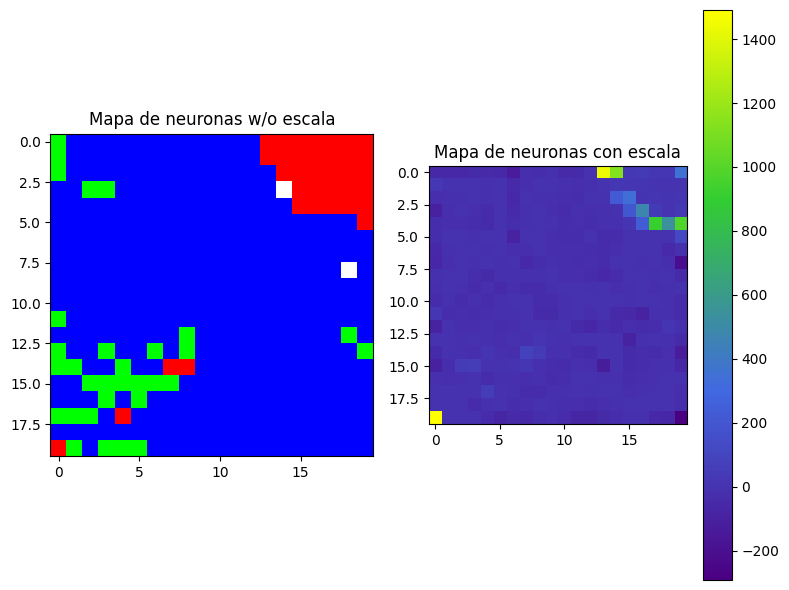

Number of blue neurons: 332
Number of red neurons: 35
Number of white neurons: 2
Number of green neurons: 31


NameError: name 'smote_enn_sinteticos' is not defined

In [72]:
y = svmsmote_ncr.iloc[: , 30]
X = svmsmote_ncr.drop(svmsmote_ncr.columns[30], axis=1)
y = y.to_numpy()
X = X.to_numpy()
porcentaje = 0.8
ladoMap = 20

# Inicializa un mapa de colores del tamaño del SOM con todos los valores en blanco
color_map = np.ones((ladoMap, ladoMap, 3))

# Inicializa un mapa de clases del tamaño del SOM con todos los valores en -1
class_map = -1 * np.ones((ladoMap, ladoMap))

# Contadores para cada neurona
counts = np.zeros((ladoMap, ladoMap, 2), dtype=int)

# Itera sobre cada dato y su clase correspondiente
for datum, class_ in zip(X, y):
    # Encuentra la neurona ganadora para este dato
    winner = main_map.calculate_bmu(datum)[1]
    
    # Actualiza el contador de la clase para la neurona ganadora
    counts[int(winner[0]), int(winner[1]), int(class_)] += 1
    
    # Actualiza el mapa de clases con la clase reconocida
    class_map[winner] = class_

# Itera sobre cada neurona para determinar el color final
for i in range(ladoMap):
    for j in range(ladoMap):
        # Calcula el porcentaje de cada clase para la neurona actual
        percent_class_0 = counts[i, j, 0] / (counts[i, j, 0] + counts[i, j, 1]) if counts[i, j, 0] + counts[i, j, 1] > 0 else 0
        percent_class_1 = counts[i, j, 1] / (counts[i, j, 0] + counts[i, j, 1]) if counts[i, j, 0] + counts[i, j, 1] > 0 else 0
        
        # Asigna el color según las condiciones especificadas
        if percent_class_0 >= porcentaje:
            color_map[i, j] = [0, 0, 1]  # Azul
        elif percent_class_1 >= porcentaje:
            color_map[i, j] = [1, 0, 0]  # Rojo
        elif counts[i, j, 0] + counts[i, j, 1] == 0:
            color_map[i, j] = [1, 1, 1]  # Blanco si no ha reconocido ningún patrón
        else:
            color_map[i, j] = [0, 1, 0]  # Verde si no alcanza el % de ninguna clase

# Crea una figura con diferentes tamaños para los subplots
fig = plt.figure(figsize=(8, 6))

# Crea una leyenda para el primer gráfico
legend_elements = [Patch(facecolor='blue', edgecolor='b', label='Clase 0'),
                   Patch(facecolor='red', edgecolor='r', label='Clase 1'),
                   Patch(facecolor='green', edgecolor='g', label='Ambas clases')]
ax1 = fig.add_subplot(121)  # 121 significa "1 fila, 2 columnas, primer gráfico"
#ax1.legend(handles=legend_elements, loc='upper right')
ax1.imshow(np.rot90(color_map))
ax1.set_title('Mapa de neuronas w/o escala')

# Inicializa un mapa de neuronas con ceros
neuron_map = np.zeros((ladoMap, ladoMap))
ganadores = np.zeros((ladoMap, ladoMap))

# Itera sobre los datos y las clases
for datum, clss in zip(X, y):
    # Obtiene la neurona ganadora para el dato actual
    winner = main_map.calculate_bmu(datum)[1]
    ganadores[winner] = 1
    print(winner, clss)
    # Si la clase es 0, resta 1, si la clase es 1, suma 1
    neuron_map[winner[0], winner[1]] += 1 if clss == 1 else -1

# Normaliza el mapa de neuronas para que los valores estén entre -1 y 1
# neuron_map = neuron_map / np.max(np.abs(neuron_map))

# Define los colores de la escala como azul, verde y amarillo
cmap_colors = ["indigo", "royalblue", "limegreen", "yellow"]

# Crea el mapa de colores
cmap = LinearSegmentedColormap.from_list("mycmap", cmap_colors)

# Dibuja el mapa de calor
ax2 = fig.add_subplot(122)  # 122 significa "1 fila, 2 columnas, segundo gráfico"
im = ax2.imshow(np.rot90(neuron_map), cmap=cmap, interpolation='nearest')
ax2.set_title('Mapa de neuronas con escala')

# Muestra la barra de colores
fig.colorbar(im, ax=ax2)

# Ajusta el layout
plt.tight_layout()

# Muestra el gráfico
plt.show()

num_blue = np.sum(np.all(color_map == [0, 0, 1], axis=-1))
num_red = np.sum(np.all(color_map == [1, 0, 0], axis=-1))
num_white = np.sum(np.all(color_map == [1, 1, 1], axis=-1))
num_green = np.sum(np.all(color_map == [0, 1, 0], axis=-1))
# Print the number of neurons of each color
print(f"Number of blue neurons: {num_blue}")
print(f"Number of red neurons: {num_red}")
print(f"Number of white neurons: {num_white}")
print(f"Number of green neurons: {num_green}")

data_balanced_dropped_smote_edited_sint = smote_enn_sinteticos.drop(columns = [3])
data_balanced_dropped_smote_edited_sint=data_balanced_dropped_smote_edited_sint.to_numpy()
main_classification_smoted_enn_sinteticos = GEMA.Classification(main_map, data_balanced_dropped_smote_edited_sint)
GEMA.Visualization.heat_map(main_classification_smoted_enn_sinteticos)

## Clasificación SVM SMOTE GEMA fraudes

In [ ]:
main_classification_svmsmote_tomek = GEMA.Classification(main_map, data_svmsmote_tomek)
print("svmsmote+tommed quantification:",main_classification_svmsmote_tomek.quantization_error)
print("svmsmote+tommed topological:",main_classification_svmsmote_tomek.topological_error)

main_classification_svmsmote_edited= GEMA.Classification(main_map, data_svmsmote_edited)
print("svmsmote+edited quantification:",main_classification_svmsmote_edited.quantization_error)
print("svmsmote+edited topological:",main_classification_svmsmote_edited.topological_error)

main_classification_svmsmote_cnn= GEMA.Classification(main_map, data_svmsmote_cnn)
print("svmsmote+cnn quantification:",main_classification_svmsmote_cnn.quantization_error)
print("svmsmote+cnn topological:",main_classification_svmsmote_cnn.topological_error)

main_classification_svmsmote_ncr= GEMA.Classification(main_map, data_svmsmote_ncr)
print("svmsmote+ncr quantification:",main_classification_svmsmote_ncr.quantization_error)
print("svmsmote+ncr topological:",main_classification_svmsmote_ncr.topological_error)

main_classification_svmsmote_oss= GEMA.Classification(main_map, data_svmsmote_oss)
print("svmsmote+oss quantification:",main_classification_svmsmote_oss.quantization_error)
print("svmsmote+oss topological:",main_classification_svmsmote_oss.topological_error)

## Clasificación Minisom SVM SMOTE fraudes

In [ ]:
print("svmsmote+tommed")
print(som.quantization_error(data_svmsmote_tomek), som.topographic_error(data_svmsmote_tomek))
print("svmsmote+linked")
print(som.quantization_error(data_svmsmote_edited), som.topographic_error(data_svmsmote_edited))
print("svmsmote+cnn")
print(som.quantization_error(data_svmsmote_cnn), som.topographic_error(data_svmsmote_cnn))
print("svmsmote+ncr")
print(som.quantization_error(data_svmsmote_ncr), som.topographic_error(data_svmsmote_ncr))
print("svmsmote+oss")
print(som.quantization_error(data_svmsmote_oss), som.topographic_error(data_svmsmote_oss))

## KMS SMOTE fraudes

In [ ]:
## KMSSMOTE + Tomed_links
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 30)
data_std = wf.min_max_normalization(datos_mode)

kmssmote_tomek=wf.KMSSMOTE_tomek(data_std,30)
print(kmssmote_tomek[30].value_counts())
data_kmssmote_tomek = kmssmote_tomek.drop(columns = [30])
data_kmssmote_tomek=data_kmssmote_tomek.to_numpy()

## KMSSMOTE + ENN
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 30)
data_std = wf.min_max_normalization(datos_mode)

kmssmote_edited=wf.KMSSMOTE_enn(data_std,30)
print(kmssmote_edited[30].value_counts())
data_kmssmote_edited = kmssmote_edited.drop(columns = [30])
data_kmssmote_edited=data_kmssmote_edited.to_numpy()

## KMSSMOTE con CNN (condensed nearest neighbors)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 30)
data_std = wf.min_max_normalization(datos_mode)

kmssmote_cnn=wf.KMSSMOTE_cnn(data_std,30)
print(kmssmote_cnn[30].value_counts())
data_kmssmote_cnn = kmssmote_cnn.drop(columns = [30])
data_kmssmote_cnn=data_kmssmote_cnn.to_numpy()

## KMSSMOTE con NCR (Neighboorhood cleaning rule)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 30)
data_std = wf.min_max_normalization(datos_mode)

kmssmote_ncr=wf.KMSSMOTE_ncr(data_std,30)
print(kmssmote_ncr[30].value_counts())
data_kmssmote_ncr = kmssmote_ncr.drop(columns = [30])
data_kmssmote_ncr=data_kmssmote_ncr.to_numpy()

## KMSSMOTE con OSD (One sided selection)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 30)
data_std = wf.min_max_normalization(datos_mode)

kmssmote_oss=wf.KMSSMOTE_oss(data_std,30)
print(kmssmote_oss[30].value_counts())
data_kmssmote_oss = kmssmote_oss.drop(columns = [30])
data_kmssmote_oss=data_kmssmote_oss.to_numpy()

## Clasificación GEMA KMS SMOTE fraudes

In [ ]:
main_classification_kmssmote_tomek = GEMA.Classification(main_map, data_kmssmote_tomek)
print("svmsmote+tommed quantification:",main_classification_kmssmote_tomek.quantization_error)
print("svmsmote+tommed topological:",main_classification_kmssmote_tomek.topological_error)

main_classification_kmssmote_edited= GEMA.Classification(main_map, data_kmssmote_edited)
print("svmsmote+edited quantification:",main_classification_kmssmote_edited.quantization_error)
print("svmsmote+edited topological:",main_classification_kmssmote_edited.topological_error)

main_classification_kmssmote_cnn= GEMA.Classification(main_map, data_kmssmote_cnn)
print("svmsmote+cnn quantification:",main_classification_kmssmote_cnn.quantization_error)
print("svmsmote+cnn topological:",main_classification_kmssmote_cnn.topological_error)

main_classification_kmssmote_ncr= GEMA.Classification(main_map, data_kmssmote_ncr)
print("svmsmote+ncr quantification:",main_classification_kmssmote_ncr.quantization_error)
print("svmsmote+ncr topological:",main_classification_kmssmote_ncr.topological_error)

main_classification_kmssmote_oss= GEMA.Classification(main_map, data_kmssmote_oss)
print("svmsmote+oss quantification:",main_classification_kmssmote_oss.quantization_error)
print("svmsmote+oss topological:",main_classification_kmssmote_oss.topological_error)

## Clasificación Minisom KMS SMOTE fraudes

In [ ]:
print("kmssmote+tommed")
print(som.quantization_error(data_kmssmote_tomek), som.topographic_error(data_kmssmote_tomek))
print("kmssmote+linked")
print(som.quantization_error(data_kmssmote_edited), som.topographic_error(data_kmssmote_edited))
print("kmssmote+cnn")
print(som.quantization_error(data_kmssmote_cnn), som.topographic_error(data_kmssmote_cnn))
print("kmssmote+ncr")
print(som.quantization_error(data_kmssmote_ncr), som.topographic_error(data_kmssmote_ncr))
print("kmssmote+oss")
print(som.quantization_error(data_kmssmote_oss), som.topographic_error(data_kmssmote_oss))

## Importar dataset 

In [73]:
## Importar dataset
url = '../../PROYECTO SOM DESBALANCEADO/DATASET/microcalcification.csv'
missing_values = [' ', 'NaN', 'na', 'Na', '-', '--', 'n/a', '?']
columns = ['class']
data = pd.read_csv(url, na_values = missing_values, header=None)
data = data.iloc[1:]
data[6] = data[6].str.strip("'").astype(int)
data[6] = data[6].replace({-1: 0})
data

,0,1,2,3,4,5,6
1,0.23001961,5.0725783,-0.27606055,0.83244412,-0.37786573,0.4803223,0
2,0.15549112,-0.16939038,0.67065219,-0.85955255,-0.37786573,-0.94572324,0
3,-0.78441482,-0.44365372,5.6747053,-0.85955255,-0.37786573,-0.94572324,0
4,0.54608818,0.13141457,-0.45638679,-0.85955255,-0.37786573,-0.94572324,0
5,-0.10298725,-0.3949941,-0.14081588,0.97970269,-0.37786573,1.0135658,0
...,...,...,...,...,...,...,...
11179,-0.25001164,-0.37729969,-0.32114211,1.2691565,3.652984,1.0927906,1
11180,0.28134264,-0.41711211,-0.36622367,0.85100967,2.7896491,1.3457004,1
11181,1.2049878,1.7637238,-0.50146835,1.5624078,6.4890725,0.93129397,1
11182,0.73664398,-0.22247361,-0.050652758,1.5096647,0.53926914,1.3152293,1


In [74]:
data = data.astype(float)
'''# Contar cuántas filas tienen un valor de 0 en la columna "columna_nombre"
filas_con_cero = data[data[30] == 0]

# Verificar si hay suficientes filas con 0 antes de eliminar
if len(filas_con_cero) >= 274000:
    # Eliminar las primeras 180,000 filas con 0
    data = data.drop(filas_con_cero.index[:274000])'''
datos_mode = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(datos_mode, 6)
datos_mode[6].value_counts()

Columnas dropeadas:  []
Numero de columnas dropeadas:  0
Numero de columnas tras aplicar el porcentaje:  7


0.0    10923
1.0      260
Name: 6, dtype: int64

In [75]:
datos_mode=datos_mode.drop(columns = [6])
data_std = wf.min_max_normalization(datos_mode)
target = data[6].values
label_names={0:'Micro', 1:'No micro'}
data_som=data_std.to_numpy()

## Entrenamiento GEMA microcalcificaciones

In [76]:
main_map = GEMA.Map(data_som, 
                    5, 
                    43000, 
                    initial_lr=0.05275041385159045, 
                    initial_neighbourhood = 0,
                    distance = 'euclidean',
                    use_decay= False,
                    presentation= 'random',
                    weights = 'random')

main_classification = GEMA.Classification(main_map, data_som)
print("quantification error:",main_classification.quantization_error)
print("Topological_error:",main_classification.topological_error)

TRAINING...


  0%|          | 0/43000 [00:00<?, ?it/s]

FINISHED.


  0%|          | 0/11183 [00:00<?, ?it/s]

quantification error: 0.051898791022087096
Topological_error: 0.10185102387552535


## Entrenamiento Minisom microcalcificaciones

In [ ]:
n_neurons = 5
m_neurons = 5

som = MiniSom(n_neurons, m_neurons, data_som.shape[1], learning_rate=0.05275041385159045, random_seed=42)
som.train(data_som, num_iteration=43000, verbose=True)  # random training
print("Topological error:",som.topographic_error(data_som))

## SMOTE Micro

In [ ]:
## Smote + Tomed_links
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 6)
data_std = wf.min_max_normalization(datos_mode)

Smote_tomed=wf.smote_tomed_link(data_std,6)
print(Smote_tomed[6].value_counts())
data_balanced_dropped_smote_tomed = Smote_tomed.drop(columns = [6])
data_balanced_dropped_smote_tomed=data_balanced_dropped_smote_tomed.to_numpy()

## smote_edited_nearest_neighbor
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 6)
data_std = wf.min_max_normalization(datos_mode)

Smote_edited=wf.smote_edited_nearest_neighbor(data_std,6)
print(Smote_edited[6].value_counts())
data_balanced_dropped_smote_edited = Smote_edited.drop(columns = [6])
data_balanced_dropped_smote_edited=data_balanced_dropped_smote_edited.to_numpy()

## smote con CNN (condensed nearest neighbors)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 6)
data_std = wf.min_max_normalization(datos_mode)

Smote_cnn=wf.smote_cnn(data_std,6)
print(Smote_cnn[6].value_counts())
data_smote_cnn = Smote_cnn.drop(columns = [6])
data_smote_cnn=data_smote_cnn.to_numpy()

## smote con NCR (Neighboorhood cleaning rule)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 6)
data_std = wf.min_max_normalization(datos_mode)

Smote_ncr=wf.smote_ncr(data_std,6)
print(Smote_ncr[6].value_counts())
data_smote_ncr = Smote_ncr.drop(columns = [6])
data_smote_ncr=data_smote_ncr.to_numpy()

## smote con OSD (One sided selection)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 6)
data_std = wf.min_max_normalization(datos_mode)

Smote_oss=wf.smote_osd(data_std,6)
print(Smote_oss[6].value_counts())
data_smote_oss = Smote_oss.drop(columns = [6])
data_smote_oss=data_smote_oss.to_numpy()

## Clasificación GEMA SMOTE Micro

In [ ]:
main_classification_smoted_tomed = GEMA.Classification(main_map, data_balanced_dropped_smote_tomed)
print("Smote+tommed quantification:",main_classification_smoted_tomed.quantization_error)
print("Smote+tommed topological:",main_classification_smoted_tomed.topological_error)

main_classification_smoted_edited= GEMA.Classification(main_map, data_balanced_dropped_smote_edited)
print("Smote+edited quantification:",main_classification_smoted_edited.quantization_error)
print("Smote+edited topological:",main_classification_smoted_edited.topological_error)

main_classification_smoted_cnn= GEMA.Classification(main_map, data_smote_cnn)
print("Smote+cnn quantification:",main_classification_smoted_cnn.quantization_error)
print("Smote+cnn topological:",main_classification_smoted_cnn.topological_error)

main_classification_smoted_ncr= GEMA.Classification(main_map, data_smote_ncr)
print("Smote+ncr quantification:",main_classification_smoted_ncr.quantization_error)
print("Smote+ncr topological:",main_classification_smoted_ncr.topological_error)

main_classification_smoted_oss= GEMA.Classification(main_map, data_smote_oss)
print("Smote+oss quantification:",main_classification_smoted_oss.quantization_error)
print("Smote+oss topological:",main_classification_smoted_oss.topological_error)

## Clasificación SMOTE Minisom micro

In [ ]:
print("Smote+tommed")
print(som.quantization_error(data_balanced_dropped_smote_tomed), som.topographic_error(data_balanced_dropped_smote_tomed))
print("Smote+linked")
print(som.quantization_error(data_balanced_dropped_smote_edited), som.topographic_error(data_balanced_dropped_smote_edited))
print("Smote+cnn")
print(som.quantization_error(data_smote_cnn), som.topographic_error(data_smote_cnn))
print("Smote+ncr")
print(som.quantization_error(data_smote_ncr), som.topographic_error(data_smote_ncr))
print("Smote+oss")
print(som.quantization_error(data_smote_oss), som.topographic_error(data_smote_oss))

## ADASYN micro

In [ ]:
## ADASYN + Tomed_links
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 6)
data_std = wf.min_max_normalization(datos_mode)

adasyn_tomek=wf.adasyn_tomek(data_std,6)
print(adasyn_tomek[6].value_counts())
data_adasyn_tomek = adasyn_tomek.drop(columns = [6])
data_adasyn_tomek=data_adasyn_tomek.to_numpy()

## ADASYN + ENN
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 6)
data_std = wf.min_max_normalization(datos_mode)

adasyn_edited=wf.adasyn_enn(data_std,6)
print(adasyn_edited[6].value_counts())
data_adasyn_edited = adasyn_edited.drop(columns = [6])
data_adasyn_edited=data_adasyn_edited.to_numpy()

## ADASYN con CNN (condensed nearest neighbors)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 6)
data_std = wf.min_max_normalization(datos_mode)

adasyn_cnn=wf.adasyn_cnn(data_std,6)
print(adasyn_cnn[6].value_counts())
data_adasyn_cnn = adasyn_cnn.drop(columns = [6])
data_adasyn_cnn=data_adasyn_cnn.to_numpy()

## ADASYN con NCR (Neighboorhood cleaning rule)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 6)
data_std = wf.min_max_normalization(datos_mode)

adasyn_ncr=wf.adasyn_ncr(data_std,6)
print(adasyn_ncr[6].value_counts())
data_adasyn_ncr = adasyn_ncr.drop(columns = [6])
data_adasyn_ncr=data_adasyn_ncr.to_numpy()

## ADASYN con OSD (One sided selection)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 6)
data_std = wf.min_max_normalization(datos_mode)

adasyn_oss=wf.adasyn_oss(data_std,6)
print(adasyn_oss[6].value_counts())
data_adasyn_oss = adasyn_oss.drop(columns = [6])
data_adasyn_oss=data_adasyn_oss.to_numpy()

## Clasificacion GEMA ADASYN Micro

In [ ]:
main_classification_adasyn_tomek = GEMA.Classification(main_map, data_adasyn_tomek)
print("adasyn+tommed quantification:",main_classification_adasyn_tomek.quantization_error)
print("adasyn+tommed topological:",main_classification_adasyn_tomek.topological_error)

main_classification_adasyn_edited= GEMA.Classification(main_map, data_adasyn_edited)
print("adasyn+edited quantification:",main_classification_adasyn_edited.quantization_error)
print("adasyn+edited topological:",main_classification_adasyn_edited.topological_error)

main_classification_smoted_cnn= GEMA.Classification(main_map, data_smote_cnn)
print("adasyn+cnn quantification:",main_classification_smoted_cnn.quantization_error)
print("adasyn+cnn topological:",main_classification_smoted_cnn.topological_error)

main_classification_smoted_ncr= GEMA.Classification(main_map, data_adasyn_ncr)
print("adasyn+ncr quantification:",main_classification_smoted_ncr.quantization_error)
print("adasyn+ncr topological:",main_classification_smoted_ncr.topological_error)

main_classification_smoted_oss= GEMA.Classification(main_map, data_adasyn_oss)
print("adasyn+oss quantification:",main_classification_smoted_oss.quantization_error)
print("adasyn+oss topological:",main_classification_smoted_oss.topological_error)

## Clasificación Minisom ADASYN Micro

In [ ]:
print("adasyn+tommed")
print(som.quantization_error(data_adasyn_tomek), som.topographic_error(data_adasyn_tomek))
print("adasyn+linked")
print(som.quantization_error(data_adasyn_edited), som.topographic_error(data_adasyn_edited))
print("adasyn+cnn")
print(som.quantization_error(data_smote_cnn), som.topographic_error(data_smote_cnn))
print("adasyn+ncr")
print(som.quantization_error(data_adasyn_ncr), som.topographic_error(data_adasyn_ncr))
print("adasyn+oss")
print(som.quantization_error(data_adasyn_oss), som.topographic_error(data_adasyn_oss))

## BSMOTE Micro

In [ ]:
## BSMOTE + Tomed_links
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 6)
data_std = wf.min_max_normalization(datos_mode)

bsmote_tomek=wf.BSMOTE_tomek(data_std,6)
print(bsmote_tomek[6].value_counts())
data_bsmote_tomek = bsmote_tomek.drop(columns = [6])
data_bsmote_tomek=data_bsmote_tomek.to_numpy()

## BSMOTE + ENN
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 6)
data_std = wf.min_max_normalization(datos_mode)

bsmote_edited=wf.BSMOTE_enn(data_std,6)
print(bsmote_edited[6].value_counts())
data_bsmote_edited = bsmote_edited.drop(columns = [6])
data_bsmote_edited=data_bsmote_edited.to_numpy()

## BSMOTE con CNN (condensed nearest neighbors)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 6)
data_std = wf.min_max_normalization(datos_mode)

bsmote_cnn=wf.BSMOTE_cnn(data_std,6)
print(bsmote_cnn[6].value_counts())
data_bsmote_cnn = bsmote_cnn.drop(columns = [6])
data_bsmote_cnn=data_bsmote_cnn.to_numpy()

## BSMOTE con NCR (Neighboorhood cleaning rule)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 6)
data_std = wf.min_max_normalization(datos_mode)

bsmote_ncr=wf.BSMOTE_ncr(data_std,6)
print(bsmote_ncr[6].value_counts())
data_bsmote_ncr = bsmote_ncr.drop(columns = [6])
data_bsmote_ncr=data_bsmote_ncr.to_numpy()

## BSMOTE con OSD (One sided selection)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 6)
data_std = wf.min_max_normalization(datos_mode)

bsmote_oss=wf.BSMOTE_oss(data_std,6)
print(bsmote_oss[6].value_counts())
data_bsmote_oss = bsmote_oss.drop(columns = [6])
data_bsmote_oss=data_bsmote_oss.to_numpy()

## Clasificación GEMA BSMOTE Micro

In [ ]:
main_classification_bsmote_tomek = GEMA.Classification(main_map, data_bsmote_tomek)
print("bsmote+tommed quantification:",main_classification_bsmote_tomek.quantization_error)
print("bsmote+tommed topological:",main_classification_bsmote_tomek.topological_error)

main_classification_bsmote_edited= GEMA.Classification(main_map, data_bsmote_edited)
print("bsmote+edited quantification:",main_classification_bsmote_edited.quantization_error)
print("bsmote+edited topological:",main_classification_bsmote_edited.topological_error)

main_classification_bsmote_cnn= GEMA.Classification(main_map, data_bsmote_cnn)
print("bsmote+cnn quantification:",main_classification_bsmote_cnn.quantization_error)
print("bsmote+cnn topological:",main_classification_bsmote_cnn.topological_error)

main_classification_bsmote_ncr= GEMA.Classification(main_map, data_bsmote_ncr)
print("bsmote+ncr quantification:",main_classification_bsmote_ncr.quantization_error)
print("bsmote+ncr topological:",main_classification_bsmote_ncr.topological_error)

main_classification_bsmote_oss= GEMA.Classification(main_map, data_bsmote_oss)
print("bsmote+oss quantification:",main_classification_bsmote_oss.quantization_error)
print("bsmote+oss topological:",main_classification_bsmote_oss.topological_error)

## Clasificación Minisom BSMOTE Micro

In [ ]:
print("bsmote+tommed")
print(som.quantization_error(data_bsmote_tomek), som.topographic_error(data_bsmote_tomek))
print("bsmote+linked")
print(som.quantization_error(data_bsmote_edited), som.topographic_error(data_bsmote_edited))
print("bsmote+cnn")
print(som.quantization_error(data_bsmote_cnn), som.topographic_error(data_bsmote_cnn))
print("bsmote+ncr")
print(som.quantization_error(data_bsmote_ncr), som.topographic_error(data_bsmote_ncr))
print("bsmote+oss")
print(som.quantization_error(data_bsmote_oss), som.topographic_error(data_bsmote_oss))

## SVM SMOTE Micro

In [ ]:
## SVMSMOTE + Tomed_links
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 6)
data_std = wf.min_max_normalization(datos_mode)

svmsmote_tomek=wf.SVMSMOTE_tomek(data_std,6)
print(svmsmote_tomek[6].value_counts())
data_svmsmote_tomek = svmsmote_tomek.drop(columns = [6])
data_svmsmote_tomek=data_svmsmote_tomek.to_numpy()

## SVMSMOTE + ENN
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 6)
data_std = wf.min_max_normalization(datos_mode)

svmsmote_edited=wf.SVMSMOTE_enn(data_std,6)
print(svmsmote_edited[6].value_counts())
data_svmsmote_edited = svmsmote_edited.drop(columns = [6])
data_svmsmote_edited=data_svmsmote_edited.to_numpy()

## SVMSMOTE con CNN (condensed nearest neighbors)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 6)
data_std = wf.min_max_normalization(datos_mode)

svmsmote_cnn=wf.SVMSMOTE_cnn(data_std,6)
print(svmsmote_cnn[6].value_counts())
data_svmsmote_cnn = svmsmote_cnn.drop(columns = [6])
data_svmsmote_cnn=data_svmsmote_cnn.to_numpy()

## SVMSMOTE con NCR (Neighboorhood cleaning rule)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 6)
data_std = wf.min_max_normalization(datos_mode)

svmsmote_ncr=wf.SVMSMOTE_ncr(data_std,6)
print(svmsmote_ncr[6].value_counts())
data_svmsmote_ncr = svmsmote_ncr.drop(columns = [6])
data_svmsmote_ncr=data_svmsmote_ncr.to_numpy()

## SVMSMOTE con OSD (One sided selection)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 6)
data_std = wf.min_max_normalization(datos_mode)

svmsmote_oss=wf.SVMSMOTE_oss(data_std,6)
print(svmsmote_oss[6].value_counts())
data_svmsmote_oss = svmsmote_oss.drop(columns = [6])
data_svmsmote_oss=data_svmsmote_oss.to_numpy()

## Clasificación GEMA SVM SMOTE Micro

In [ ]:
main_classification_svmsmote_tomek = GEMA.Classification(main_map, data_svmsmote_tomek)
print("svmsmote+tommed quantification:",main_classification_svmsmote_tomek.quantization_error)
print("svmsmote+tommed topological:",main_classification_svmsmote_tomek.topological_error)

main_classification_svmsmote_edited= GEMA.Classification(main_map, data_svmsmote_edited)
print("svmsmote+edited quantification:",main_classification_svmsmote_edited.quantization_error)
print("svmsmote+edited topological:",main_classification_svmsmote_edited.topological_error)

main_classification_svmsmote_cnn= GEMA.Classification(main_map, data_svmsmote_cnn)
print("svmsmote+cnn quantification:",main_classification_svmsmote_cnn.quantization_error)
print("svmsmote+cnn topological:",main_classification_svmsmote_cnn.topological_error)

main_classification_svmsmote_ncr= GEMA.Classification(main_map, data_svmsmote_ncr)
print("svmsmote+ncr quantification:",main_classification_svmsmote_ncr.quantization_error)
print("svmsmote+ncr topological:",main_classification_svmsmote_ncr.topological_error)

main_classification_svmsmote_oss= GEMA.Classification(main_map, data_svmsmote_oss)
print("svmsmote+oss quantification:",main_classification_svmsmote_oss.quantization_error)
print("svmsmote+oss topological:",main_classification_svmsmote_oss.topological_error)

## Clasificación SVM SMOTE Minisom Micro

In [ ]:
print("svmsmote+tommed")
print(som.quantization_error(data_svmsmote_tomek), som.topographic_error(data_svmsmote_tomek))
print("svmsmote+linked")
print(som.quantization_error(data_svmsmote_edited), som.topographic_error(data_svmsmote_edited))
print("svmsmote+cnn")
print(som.quantization_error(data_svmsmote_cnn), som.topographic_error(data_svmsmote_cnn))
print("svmsmote+ncr")
print(som.quantization_error(data_svmsmote_ncr), som.topographic_error(data_svmsmote_ncr))
print("svmsmote+oss")
print(som.quantization_error(data_svmsmote_oss), som.topographic_error(data_svmsmote_oss))

## KMS SMOTE Micro

In [ ]:
## KMSSMOTE + Tomed_links
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 6)
data_std = wf.min_max_normalization(datos_mode)

kmssmote_tomek=wf.KMSSMOTE_tomek(data_std,6)
print(kmssmote_tomek[6].value_counts())
data_kmssmote_tomek = kmssmote_tomek.drop(columns = [6])
data_kmssmote_tomek=data_kmssmote_tomek.to_numpy()

## KMSSMOTE + ENN
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 6)
data_std = wf.min_max_normalization(datos_mode)

kmssmote_edited=wf.KMSSMOTE_enn(data_std,6)
print(kmssmote_edited[6].value_counts())
data_kmssmote_edited = kmssmote_edited.drop(columns = [6])
data_kmssmote_edited=data_kmssmote_edited.to_numpy()

## KMSSMOTE con CNN (condensed nearest neighbors)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 6)
data_std = wf.min_max_normalization(datos_mode)

kmssmote_cnn=wf.KMSSMOTE_cnn(data_std,6)
print(kmssmote_cnn[6].value_counts())
data_kmssmote_cnn = kmssmote_cnn.drop(columns = [6])
data_kmssmote_cnn=data_kmssmote_cnn.to_numpy()

## KMSSMOTE con NCR (Neighboorhood cleaning rule)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 6)
data_std = wf.min_max_normalization(datos_mode)

kmssmote_ncr=wf.KMSSMOTE_ncr(data_std,6)
print(kmssmote_ncr[6].value_counts())
data_kmssmote_ncr = kmssmote_ncr.drop(columns = [6])
data_kmssmote_ncr=data_kmssmote_ncr.to_numpy()

## KMSSMOTE con OSD (One sided selection)
data_dropped = wf.drop_missing_values_columns(data, 5)
datos_mode = wf.mode_imputation(data_dropped, 6)
data_std = wf.min_max_normalization(datos_mode)

kmssmote_oss=wf.KMSSMOTE_oss(data_std,6)
print(kmssmote_oss[6].value_counts())
data_kmssmote_oss = kmssmote_oss.drop(columns = [6])
data_kmssmote_oss=data_kmssmote_oss.to_numpy()

## Clasificación GEMA KMS SMOTE Micro

In [ ]:
main_classification_kmssmote_tomek = GEMA.Classification(main_map, data_kmssmote_tomek)
print("svmsmote+tommed quantification:",main_classification_kmssmote_tomek.quantization_error)
print("svmsmote+tommed topological:",main_classification_kmssmote_tomek.topological_error)

main_classification_kmssmote_edited= GEMA.Classification(main_map, data_kmssmote_edited)
print("svmsmote+edited quantification:",main_classification_kmssmote_edited.quantization_error)
print("svmsmote+edited topological:",main_classification_kmssmote_edited.topological_error)

main_classification_kmssmote_cnn= GEMA.Classification(main_map, data_kmssmote_cnn)
print("svmsmote+cnn quantification:",main_classification_kmssmote_cnn.quantization_error)
print("svmsmote+cnn topological:",main_classification_kmssmote_cnn.topological_error)

main_classification_kmssmote_ncr= GEMA.Classification(main_map, data_kmssmote_ncr)
print("svmsmote+ncr quantification:",main_classification_kmssmote_ncr.quantization_error)
print("svmsmote+ncr topological:",main_classification_kmssmote_ncr.topological_error)

main_classification_kmssmote_oss= GEMA.Classification(main_map, data_kmssmote_oss)
print("svmsmote+oss quantification:",main_classification_kmssmote_oss.quantization_error)
print("svmsmote+oss topological:",main_classification_kmssmote_oss.topological_error)

## Clasificación KMS SMOTE Minisom Micro

In [ ]:
print("kmssmote+tommed")
print(som.quantization_error(data_kmssmote_tomek), som.topographic_error(data_kmssmote_tomek))
print("kmssmote+linked")
print(som.quantization_error(data_kmssmote_edited), som.topographic_error(data_kmssmote_edited))
print("kmssmote+cnn")
print(som.quantization_error(data_kmssmote_cnn), som.topographic_error(data_kmssmote_cnn))
print("kmssmote+ncr")
print(som.quantization_error(data_kmssmote_ncr), som.topographic_error(data_kmssmote_ncr))
print("kmssmote+oss")
print(som.quantization_error(data_kmssmote_oss), som.topographic_error(data_kmssmote_oss))